# 1.Import

In [1]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")
import csv
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
precision, recall = Precision(), Recall()
from auditokmaster import auditok
from auditok import AudioRegion
import sounddevice as sd
import soundfile as sf
from datetime import datetime
from scipy.signal import resample

Using TensorFlow backend.


# 2.Paths

In [2]:
mainPath ='./database_Google/'
dataPath ='./database_Google/data/'
dataNumpy ='./database_Google/numpy/'
dataNumpy8000 ='./database_Google/numpy/8000/'
dataNumpy16000 ='./database_Google/numpy/16000/'
dataRecord ='./database_Google/Records/'
txtPath ='./database_Google/txt/'

# 3.Load data 

## 3.1Train, validation and test split

### 3.1.1Validation & Test

Here we have a code to extract all file names corresponding to test and validation set

In [3]:
txtFiles= [f for f in os.listdir(txtPath) if f.endswith('.txt')]
print(txtFiles)
#TESTING LIST
testingList = open(txtPath+txtFiles[0], "r")
arrayTest = testingList.readlines()
testingList.close()
print("Length Test:{}".format(len(arrayTest)))
#Remove '\n' from samples
indexArrayTest=0
for i in arrayTest:
    arrayTest[indexArrayTest]=i.rstrip('\n')
    indexArrayTest=indexArrayTest+1
    
    
#VALIDATION LIST
validationList = open(txtPath+txtFiles[1], "r")
arrayVal = validationList.readlines()
validationList.close()
print("Length Validation:{}".format(len(arrayVal)))
#Remove '\n' from samples
indexArrayVal=0
for i in arrayVal:
    arrayVal[indexArrayVal]=i.rstrip('\n')
    indexArrayVal=indexArrayVal+1

['testing_list.txt', 'validation_list.txt']
Length Test:11005
Length Validation:9981


We put together both files in order to substract later this file names in train txt

In [4]:
#Array Test + Validation together
ArrayNotTrain=[]
ArrayNotTrain=np.append(arrayTest,arrayVal)
ArrayNotTrain=list(ArrayNotTrain)

Here we have a function to get unique labels from an array. Also we remove the last two characters from both test and validation list

In [5]:
# function to get unique values 
def unique(list1): 
    # intilize a null list 
    unique_list = [] 
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    return unique_list

In [6]:
#Convert array to list
ArrayNotTrain=list(ArrayNotTrain)
#Sort all samples
ArrayNotTrain.sort(reverse=False)
#Remove '\n' from samples
indexArray=0
for i in ArrayNotTrain:
    ArrayNotTrain[indexArray]=i.rstrip('\n')
    indexArray=indexArray+1
#Remove not unique samples
ArrayNotTrain=unique(ArrayNotTrain)

### 3.1.2 Train

Array label used for appending all file names for all labels

In [7]:
labels=['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 
        'five', 'follow', 'forward', 'four', 'go', 'happy', 'house',
        'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one',
        'right', 'seven', 'sheila', 'six', 'stop','three', 'tree', 
        'two', 'up','visual', 'wow', 'yes', 'zero','_background_noise_']

ArrayLabel=[]
for label in labels:
    print(label)
    #Processing all paths
    for f in os.listdir(dataPath + '/'+ label):
            string=''
            if f.endswith('.wav'):
                string=label+'/'+f
                ArrayLabel.append(string)
    
print(len(ArrayLabel))

backward
bed
bird
cat
dog
down
eight
five
follow
forward
four
go
happy
house
learn
left
marvin
nine
no
off
on
one
right
seven
sheila
six
stop
three
tree
two
up
visual
wow
yes
zero
_background_noise_
105835


Here we have to remove all file names from Array labels corresponding to both test and validation set, and the result is a rray used for training set

In [8]:
#Convert Array into list
ArrayLabel=list(ArrayLabel)
#Sort all samples
ArrayLabel.sort(reverse=False)
#Remove not unique samples
ArrayLabel=unique(ArrayLabel)

In [9]:
##TRAIN       
#Check which are corresponding to train
ArrayRest=[]
for sample in ArrayNotTrain:
    for labelSample in ArrayLabel:
        if sample==labelSample:
            ArrayLabel.remove(sample)
            ArrayRest.append(sample)

In [10]:
#Check how many samples are for validation and test together
ArrayNew=list(ArrayNotTrain)
for i in ArrayNotTrain:
    for j in ArrayRest:
        if i==j:
            ArrayNew.remove(i)

In [11]:
print('Length Test:{}'.format(len(arrayTest)))
print('Length Validation:{}'.format(len(arrayVal)))
print('Length Train:{}'.format(len(ArrayLabel)))

Length Test:11005
Length Validation:9981
Length Train:84849


# 3.2 Preprocessing data

Here we just load all samples inside the file names in their corresponding train, test and validation sets

In [12]:
all_wave_train = []
all_wave_val = []
all_wave_test = []
all_label_train = []
all_label_val = []
all_label_test = []
#VALIDATION
for wav in arrayVal:
    label,fileName=wav.split('/')
    samples, sample_rate = librosa.load(dataPath  + wav, sr = 16000)
    #samples = librosa.resample(samples, sample_rate, 8000)
    if(len(samples)== 16000) : 
        all_wave_val.append(samples)
        all_label_val.append(label)
print('Validation completed')
#TEST
for wav in arrayTest:
    label,fileName=wav.split('/')
    samples, sample_rate = librosa.load(dataPath  + wav, sr = 16000)
    #samples = librosa.resample(samples, sample_rate, 8000)
    if(len(samples)== 16000) : 
        all_wave_test.append(samples)
        all_label_test.append(label)
print('Test completed')
#TRAIN       
for wav in ArrayLabel:
    label,fileName=wav.split('/')
    samples, sample_rate = librosa.load(dataPath + wav, sr = 16000)
    #samples = librosa.resample(samples, sample_rate, 8000)
    if(len(samples)== 16000) : 
        all_wave_train.append(samples)
        all_label_train.append(label)
print('Train completed')

Validation completed
Test completed
Train completed


In [13]:
#VALIDATION
print('Validation all waves:{}'.format(len(all_wave_val)))
print('Validation all labels:{}'.format(len(all_label_val)))
#TEST
print('Test all waves:{}'.format(len(all_wave_test)))
print('Test all labels:{}'.format(len(all_label_test)))
#TRAIN
print('Train all waves:{}'.format(len(all_wave_train)))
print('Train all labels:{}'.format(len(all_label_train)))

Validation all waves:8947
Validation all labels:8947
Test all waves:10083
Test all labels:10083
Train all waves:76364
Train all labels:76364


In [19]:
# In case you want to save your data
#VALIDATION
np.save(dataNumpy8000+'val_x.npy', all_wave_val)
np.save(dataNumpy8000+'val_labels.npy', all_label_val)
print('Validation saved')
#TRAIN
np.save(dataNumpy8000+'train_x.npy', all_wave_train)
np.save(dataNumpy8000+'train_labels.npy', all_label_train)
print('Train saved')
#TEST
np.save(dataNumpy8000+'test_x.npy', all_wave_test)
np.save(dataNumpy8000+'test_labels.npy', all_label_test)
print('Test saved')

FileNotFoundError: [Errno 2] No such file or directory: './database_Google/numpy/8000/val_x.npy'

In [14]:
### To recorver Data if previously stored and saved
#16000 samples
#VALIDATION
all_wave_val=np.load(dataNumpy8000+'val_x.npy')
all_label_val=np.load(dataNumpy8000+'val_labels.npy')
#TRAIN
all_wave_train=np.load(dataNumpy8000+'train_x.npy')
all_label_train=np.load(dataNumpy8000+'train_labels.npy')
#TEST
all_wave_test=np.load(dataNumpy8000+'test_x.npy')
all_label_test=np.load(dataNumpy8000+'test_labels.npy')


FileNotFoundError: [Errno 2] No such file or directory: './database_Google/numpy/8000/val_x.npy'

In [20]:
#SHAPES ONCE LOADED NPY
#VALIDATION
print('Shape validation data:{}'.format(all_wave_val.shape))
print('Shape validation label:{}'.format(all_label_val.shape))
#TRAIN
print('Shape train data:{}'.format(all_wave_train.shape))
print('Shape train label:{}'.format(all_label_train.shape))
#TEST
print('Shape test data:{}'.format(all_wave_test.shape))
print('Shape test label:{}'.format(all_label_test.shape))

AttributeError: 'list' object has no attribute 'shape'

## 3.3 Preprocessing with spectrum

In [105]:
#Preprocess with spectrum
all_wave_train_reshape = []
all_wave_test_reshape = []
all_wave_val_reshape = []
#VALIDATION
for wavval in all_wave_val:
    D2=0
    #featureVector=0
    D2=librosa.power_to_db(librosa.feature.melspectrogram(wavval, sr=8000, n_fft=2048, fmin=10, fmax=10000, n_mels=200), ref=np.max)
    #D2 = librosa.amplitude_to_db(np.abs(librosa.stft(wavval,n_fft=256, hop_length=128, win_length=256,window='hann')), ref=np.max)
    #featureVector = np.mean(D2, axis=1)
    all_wave_val_reshape.append(D2)
#TRAIN
for wavtrain in all_wave_train:
    D2=0
    #featureVector=0
    D2=librosa.power_to_db(librosa.feature.melspectrogram(wavtrain, sr=8000, n_fft=2048, fmin=10, fmax=10000, n_mels=200), ref=np.max)
    all_wave_train_reshape.append(D2)
#TEST
for wavtest in all_wave_test:
    D2=0
    #featureVector=0
    D2=librosa.power_to_db(librosa.feature.melspectrogram(wavtest, sr=8000, n_fft=2048, fmin=10, fmax=10000, n_mels=200), ref=np.max)
    #featureVector = np.mean(D2, axis=1)
    all_wave_test_reshape.append(D2)

In [106]:
print('1 dimension:{}'.format(len(all_wave_test_reshape[0])))
print('2 dimension:{}'.format(len(all_wave_test_reshape[0][0])))

1 dimension:200
2 dimension:32


In [138]:
#VALIDATION
print('Shape validation data:{}'.format(len(all_wave_val_reshape)))
print('Shape validation label:{}'.format(len(all_label_val)))
#TRAIN
print('Shape train data:{}'.format(len(all_wave_train_reshape)))
print('Shape train label:{}'.format(len(all_label_train)))
#TEST
print('Shape test data:{}'.format(len(all_wave_test_reshape)))
print('Shape test label:{}'.format(len(all_label_test)))

Shape validation data:8947
Shape validation label:8947
Shape train data:76364
Shape train label:76364
Shape test data:10083
Shape test label:10083


###### Convert the output labels to integer encoded:

In [107]:
le = LabelEncoder()
#VALIDATION
yVal=le.fit_transform(all_label_val)
classesVal= list(le.classes_)
#TEST
yTest=le.fit_transform(all_label_test)
classesTest= list(le.classes_)
#TRAIN
yTrain=le.fit_transform(all_label_train)
classesTrain= list(le.classes_)

Now, convert the integer encoded labels to a one-hot vector since it is a multi-classification problem:

In [108]:
#VALIDATION
yVal=np_utils.to_categorical(yVal, num_classes=len(classesVal))
#TEST
yTest=np_utils.to_categorical(yTest, num_classes=len(classesTest))
#TRAIN
yTrain=np_utils.to_categorical(yTrain, num_classes=len(classesTrain))


## 3.4 Reshape 

Reshape the 2D array to 3D since the input to the conv1d must be a 3D array

In [109]:
#VALIDATION
all_wave_val_reshape = np.array(all_wave_val_reshape).reshape(-1,200,32)
#TEST
all_wave_test_reshape = np.array(all_wave_test_reshape).reshape(-1,200,32)
#TRAIN
all_wave_train_reshape = np.array(all_wave_train_reshape).reshape(-1,200,32)


In [79]:
print(all_wave_val_reshape.shape)

(8947, 200, 32)


## 3.5 Standard scaler

In [110]:
from sklearn.preprocessing import StandardScaler
scalers = {}
#TRAIN
for i in range(all_wave_train_reshape.shape[1]):
    scalers[i] = StandardScaler()
    all_wave_train_reshape[:, i, :] = scalers[i].fit_transform(all_wave_train_reshape[:, i, :]) 
#VALIDATION    
for i in range(all_wave_val_reshape.shape[1]):
    all_wave_val_reshape[:, i, :] = scalers[i].transform(all_wave_val_reshape[:, i, :]) 
#TEST
for i in range(all_wave_test_reshape.shape[1]):
    all_wave_test_reshape[:, i, :] = scalers[i].transform(all_wave_test_reshape[:, i, :]) 

# 4. Analysing data

## 4.1 Audio Visualization

samples:(16000,)
sample_rate:16000


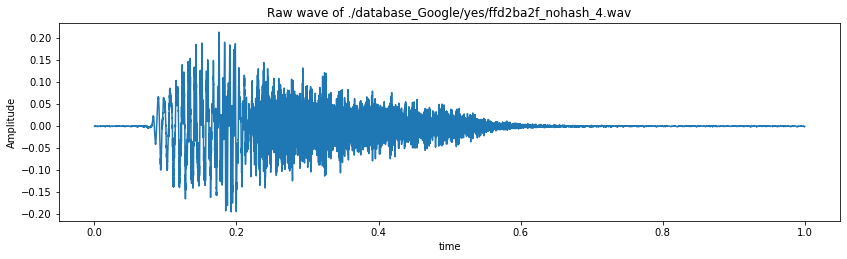

In [26]:
samples, sample_rate = librosa.load(dataPath+'yes/ffd2ba2f_nohash_4.wav', sr = 16000)
print('samples:{}'.format(samples.shape))
print('sample_rate:{}'.format(sample_rate))
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + './database_Google/yes/ffd2ba2f_nohash_4.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(samples)/sample_rate, len(samples)), samples)

## 4.2 Sampling and resampling

Here we have an audio sample

In [34]:
ipd.Audio(samples, rate=sample_rate)

Now we can observe how the quality is worse when resampling to a lower sample rate

In [156]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

## 4.3 Analysis of the classes

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero', '_background_noise_']
[1664, 2014, 2064, 2031, 2128, 3917, 3787, 4052, 1579, 1557, 3728, 3880, 2054, 2113, 1575, 3801, 2100, 3934, 3941, 3745, 3845, 3890, 3778, 3998, 2022, 3860, 3872, 3727, 1759, 3880, 3723, 1592, 2123, 4044, 4052, 6]


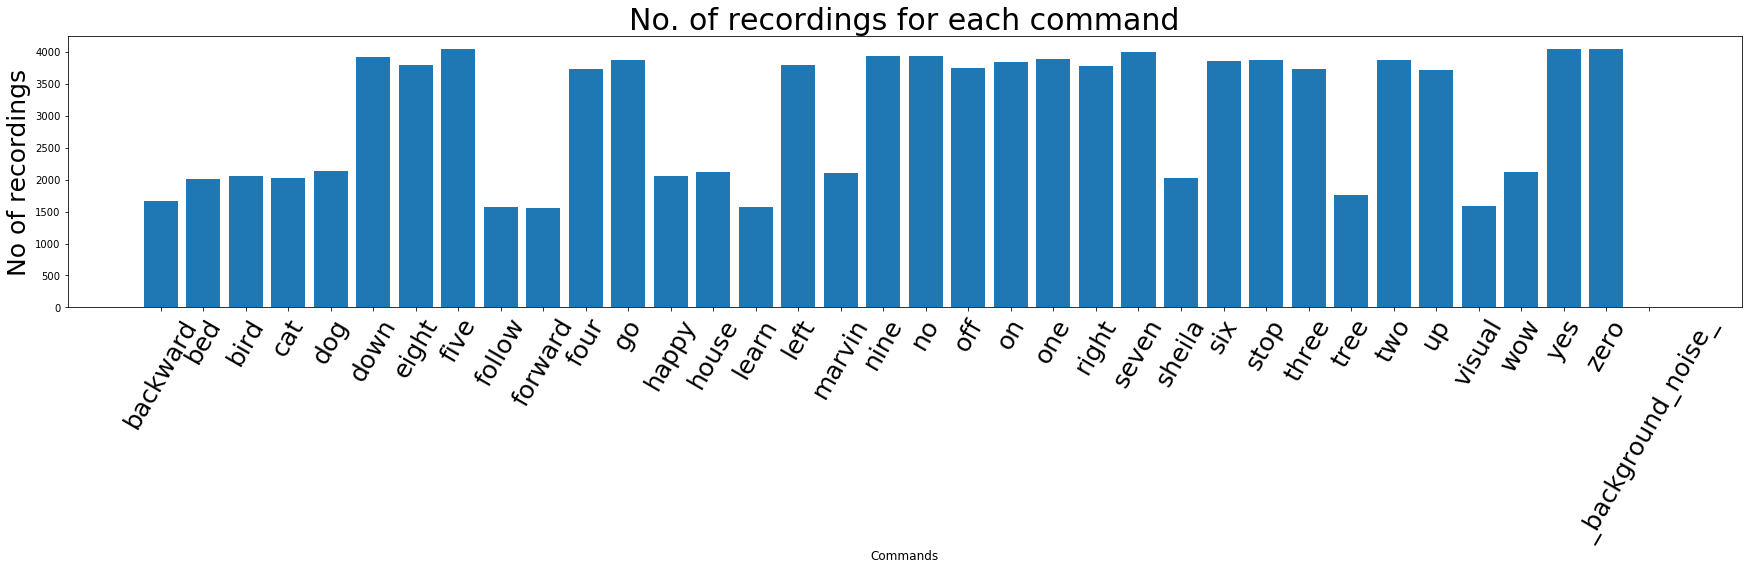

In [34]:
labels=os.listdir(dataPath)
print(labels)
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(dataPath + label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
print(no_of_recordings)
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=25)
plt.xticks(index, labels, fontsize=25, rotation=60)
plt.title('No. of recordings for each command',fontsize=30)
plt.show()

#labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
labels=['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 
        'five', 'follow', 'forward', 'four', 'go', 'happy', 'house',
        'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one',
        'right', 'seven', 'sheila', 'six', 'stop','three', 'tree', 'two', 'up','visual', 'wow', 'yes', 'zero','_background_noise_']

## 4.4 Duration of recordings

In [ ]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(dataPath + label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(dataPath + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))

In [26]:
#Number of samples per digit
n_classes=10
classes=np.zeros((n_classes))
targets=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']

for label in duration_of_recordings:
    if label<=0.1:
        classes[0]=classes[0]+1
        continue
    if label<=0.2:
        classes[1]=classes[1]+1
        continue
    if label<=0.3:
        classes[2]=classes[2]+1
        continue
    if label<=0.4:
        classes[3]=classes[3]+1
        continue
    if label<=0.5:
        classes[4]=classes[4]+1
        continue
    if label<=0.6:
        classes[5]=classes[5]+1
        continue
    if label<=0.7:
        classes[6]=classes[6]+1
        continue
    if label<=0.8:
        classes[7]=classes[7]+1
        continue
    if label<=0.9:
        classes[8]=classes[8]+1
        continue
    if label<=1:
        classes[9]=classes[9]+1
        continue    

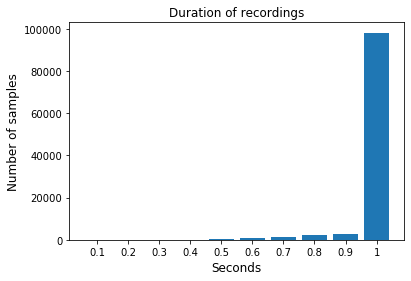

In [35]:
plt.bar(targets,classes)
plt.xlabel('Seconds',fontsize=12)
plt.ylabel('Number of samples',fontsize=12)
plt.title('Duration of recordings')
plt.show()

# 5. Model Building

In [111]:
model=0

In [112]:
from keras.layers import Dense, Dropout, Flatten, Conv2D,Conv1D,  Input, MaxPooling2D,MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(200,32))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(1)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(1)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(1)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(1)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(classesTrain), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 188, 8)            3336      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 188, 8)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 188, 8)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 178, 16)           1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 178, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 178, 16)           0         
__________

In [113]:
# Previously, we have installed some packages related to plot_model in Keras as pydot
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch

In [114]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model1.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [115]:
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',precision,recall])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [116]:
history=model.fit(all_wave_train_reshape, yTrain ,epochs=100, callbacks=[es,mc], batch_size=100, validation_data=(all_wave_val_reshape,yVal))

Train on 76364 samples, validate on 8947 samples
Epoch 1/100


20400/76364 [=======>......................] - ETA: 19:43 - loss: 3.6462 - acc: 0.02 - ETA: 10:21 - loss: 3.6238 - acc: 0.03 - ETA: 7:14 - loss: 3.6204 - acc: 0.0400 - ETA: 5:41 - loss: 3.5935 - acc: 0.052 - ETA: 4:43 - loss: 3.5805 - acc: 0.048 - ETA: 4:05 - loss: 3.5844 - acc: 0.045 - ETA: 3:37 - loss: 3.5829 - acc: 0.041 - ETA: 3:18 - loss: 3.5784 - acc: 0.040 - ETA: 3:02 - loss: 3.5784 - acc: 0.042 - ETA: 2:49 - loss: 3.5746 - acc: 0.041 - ETA: 2:39 - loss: 3.5753 - acc: 0.040 - ETA: 2:31 - loss: 3.5711 - acc: 0.040 - ETA: 2:23 - loss: 3.5679 - acc: 0.040 - ETA: 2:17 - loss: 3.5645 - acc: 0.038 - ETA: 2:12 - loss: 3.5633 - acc: 0.040 - ETA: 2:06 - loss: 3.5627 - acc: 0.040 - ETA: 2:02 - loss: 3.5597 - acc: 0.039 - ETA: 1:58 - loss: 3.5571 - acc: 0.042 - ETA: 1:55 - loss: 3.5559 - acc: 0.043 - ETA: 1:52 - loss: 3.5530 - acc: 0.046 - ETA: 1:49 - loss: 3.5516 - acc: 0.046 - ETA: 1:46 - loss: 3.5512 - acc: 0.045 - ETA: 1:44 - loss: 3.5484 - acc: 0.044 - ETA: 1:42 - loss: 3.5452 - acc: 

41900/76364 [===============>..............] - ETA: 57s - loss: 3.1470 - acc: 0.12 - ETA: 57s - loss: 3.1432 - acc: 0.12 - ETA: 57s - loss: 3.1409 - acc: 0.12 - ETA: 57s - loss: 3.1385 - acc: 0.12 - ETA: 57s - loss: 3.1372 - acc: 0.12 - ETA: 57s - loss: 3.1362 - acc: 0.12 - ETA: 57s - loss: 3.1352 - acc: 0.12 - ETA: 57s - loss: 3.1339 - acc: 0.12 - ETA: 57s - loss: 3.1323 - acc: 0.12 - ETA: 57s - loss: 3.1305 - acc: 0.12 - ETA: 57s - loss: 3.1289 - acc: 0.12 - ETA: 57s - loss: 3.1274 - acc: 0.12 - ETA: 57s - loss: 3.1251 - acc: 0.12 - ETA: 57s - loss: 3.1236 - acc: 0.12 - ETA: 56s - loss: 3.1212 - acc: 0.12 - ETA: 56s - loss: 3.1187 - acc: 0.12 - ETA: 56s - loss: 3.1159 - acc: 0.13 - ETA: 56s - loss: 3.1142 - acc: 0.13 - ETA: 56s - loss: 3.1120 - acc: 0.13 - ETA: 56s - loss: 3.1111 - acc: 0.13 - ETA: 56s - loss: 3.1093 - acc: 0.13 - ETA: 56s - loss: 3.1074 - acc: 0.13 - ETA: 56s - loss: 3.1051 - acc: 0.13 - ETA: 56s - loss: 3.1034 - acc: 0.13 - ETA: 56s - loss: 3.1010 - acc: 0.13 - ETA

63400/76364 [=======================>......] - ETA: 37s - loss: 2.8247 - acc: 0.19 - ETA: 37s - loss: 2.8233 - acc: 0.19 - ETA: 37s - loss: 2.8223 - acc: 0.19 - ETA: 37s - loss: 2.8209 - acc: 0.19 - ETA: 37s - loss: 2.8194 - acc: 0.19 - ETA: 37s - loss: 2.8182 - acc: 0.19 - ETA: 36s - loss: 2.8177 - acc: 0.19 - ETA: 36s - loss: 2.8169 - acc: 0.19 - ETA: 36s - loss: 2.8158 - acc: 0.19 - ETA: 36s - loss: 2.8146 - acc: 0.19 - ETA: 36s - loss: 2.8136 - acc: 0.19 - ETA: 36s - loss: 2.8115 - acc: 0.19 - ETA: 36s - loss: 2.8106 - acc: 0.19 - ETA: 36s - loss: 2.8099 - acc: 0.19 - ETA: 36s - loss: 2.8083 - acc: 0.19 - ETA: 36s - loss: 2.8071 - acc: 0.19 - ETA: 35s - loss: 2.8060 - acc: 0.20 - ETA: 35s - loss: 2.8046 - acc: 0.20 - ETA: 35s - loss: 2.8031 - acc: 0.20 - ETA: 35s - loss: 2.8017 - acc: 0.20 - ETA: 35s - loss: 2.8003 - acc: 0.20 - ETA: 35s - loss: 2.7993 - acc: 0.20 - ETA: 35s - loss: 2.7977 - acc: 0.20 - ETA: 35s - loss: 2.7971 - acc: 0.20 - ETA: 35s - loss: 2.7962 - acc: 0.20 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 2.6272 - acc: 0.24 - ETA: 14s - loss: 2.6265 - acc: 0.24 - ETA: 14s - loss: 2.6256 - acc: 0.24 - ETA: 13s - loss: 2.6248 - acc: 0.24 - ETA: 13s - loss: 2.6241 - acc: 0.24 - ETA: 13s - loss: 2.6232 - acc: 0.24 - ETA: 13s - loss: 2.6223 - acc: 0.24 - ETA: 13s - loss: 2.6213 - acc: 0.24 - ETA: 13s - loss: 2.6205 - acc: 0.24 - ETA: 13s - loss: 2.6197 - acc: 0.24 - ETA: 13s - loss: 2.6189 - acc: 0.24 - ETA: 13s - loss: 2.6179 - acc: 0.24 - ETA: 12s - loss: 2.6171 - acc: 0.24 - ETA: 12s - loss: 2.6162 - acc: 0.24 - ETA: 12s - loss: 2.6155 - acc: 0.24 - ETA: 12s - loss: 2.6147 - acc: 0.24 - ETA: 12s - loss: 2.6138 - acc: 0.24 - ETA: 12s - loss: 2.6129 - acc: 0.24 - ETA: 12s - loss: 2.6125 - acc: 0.24 - ETA: 12s - loss: 2.6116 - acc: 0.24 - ETA: 12s - loss: 2.6107 - acc: 0.24 - ETA: 11s - loss: 2.6097 - acc: 0.24 - ETA: 11s - loss: 2.6085 - acc: 0.24 - ETA: 11s - loss: 2.6074 - acc: 0.24 - ETA: 11s - loss: 2.6066 - acc: 0.24 - ETA

20400/76364 [=======>......................] - ETA: 42s - loss: 1.9302 - acc: 0.33 - ETA: 57s - loss: 1.9252 - acc: 0.37 - ETA: 1:06 - loss: 1.9880 - acc: 0.360 - ETA: 1:08 - loss: 1.9973 - acc: 0.372 - ETA: 1:12 - loss: 2.0103 - acc: 0.386 - ETA: 1:15 - loss: 2.0520 - acc: 0.371 - ETA: 1:16 - loss: 2.0471 - acc: 0.374 - ETA: 1:18 - loss: 2.0131 - acc: 0.382 - ETA: 1:19 - loss: 2.0086 - acc: 0.390 - ETA: 1:19 - loss: 2.0097 - acc: 0.389 - ETA: 1:20 - loss: 2.0210 - acc: 0.385 - ETA: 1:20 - loss: 2.0281 - acc: 0.384 - ETA: 1:20 - loss: 2.0246 - acc: 0.388 - ETA: 1:20 - loss: 2.0257 - acc: 0.387 - ETA: 1:21 - loss: 2.0331 - acc: 0.387 - ETA: 1:21 - loss: 2.0208 - acc: 0.393 - ETA: 1:21 - loss: 2.0265 - acc: 0.391 - ETA: 1:21 - loss: 2.0353 - acc: 0.395 - ETA: 1:21 - loss: 2.0525 - acc: 0.394 - ETA: 1:20 - loss: 2.0693 - acc: 0.389 - ETA: 1:20 - loss: 2.0583 - acc: 0.391 - ETA: 1:18 - loss: 2.0595 - acc: 0.392 - ETA: 1:17 - loss: 2.0537 - acc: 0.392 - ETA: 1:17 - loss: 2.0457 - acc: 0.394

41800/76364 [===============>..............] - ETA: 1:01 - loss: 2.0105 - acc: 0.401 - ETA: 1:01 - loss: 2.0090 - acc: 0.402 - ETA: 1:01 - loss: 2.0081 - acc: 0.402 - ETA: 1:01 - loss: 2.0085 - acc: 0.402 - ETA: 1:01 - loss: 2.0089 - acc: 0.402 - ETA: 1:01 - loss: 2.0078 - acc: 0.402 - ETA: 1:01 - loss: 2.0086 - acc: 0.402 - ETA: 1:01 - loss: 2.0088 - acc: 0.402 - ETA: 1:01 - loss: 2.0081 - acc: 0.403 - ETA: 1:00 - loss: 2.0079 - acc: 0.403 - ETA: 1:00 - loss: 2.0078 - acc: 0.402 - ETA: 1:00 - loss: 2.0070 - acc: 0.402 - ETA: 1:00 - loss: 2.0080 - acc: 0.403 - ETA: 1:00 - loss: 2.0068 - acc: 0.403 - ETA: 1:00 - loss: 2.0075 - acc: 0.403 - ETA: 1:00 - loss: 2.0068 - acc: 0.403 - ETA: 1:00 - loss: 2.0054 - acc: 0.403 - ETA: 1:00 - loss: 2.0058 - acc: 0.403 - ETA: 59s - loss: 2.0059 - acc: 0.403 - ETA: 59s - loss: 2.0056 - acc: 0.40 - ETA: 59s - loss: 2.0049 - acc: 0.40 - ETA: 59s - loss: 2.0046 - acc: 0.40 - ETA: 59s - loss: 2.0037 - acc: 0.40 - ETA: 59s - loss: 2.0042 - acc: 0.40 - ETA:

63300/76364 [=======================>......] - ETA: 38s - loss: 1.9431 - acc: 0.42 - ETA: 38s - loss: 1.9429 - acc: 0.42 - ETA: 38s - loss: 1.9428 - acc: 0.42 - ETA: 38s - loss: 1.9420 - acc: 0.42 - ETA: 38s - loss: 1.9418 - acc: 0.42 - ETA: 38s - loss: 1.9418 - acc: 0.42 - ETA: 38s - loss: 1.9420 - acc: 0.42 - ETA: 38s - loss: 1.9414 - acc: 0.42 - ETA: 37s - loss: 1.9410 - acc: 0.42 - ETA: 37s - loss: 1.9409 - acc: 0.42 - ETA: 37s - loss: 1.9406 - acc: 0.42 - ETA: 37s - loss: 1.9401 - acc: 0.42 - ETA: 37s - loss: 1.9387 - acc: 0.42 - ETA: 37s - loss: 1.9385 - acc: 0.42 - ETA: 37s - loss: 1.9379 - acc: 0.42 - ETA: 37s - loss: 1.9376 - acc: 0.42 - ETA: 36s - loss: 1.9373 - acc: 0.42 - ETA: 36s - loss: 1.9376 - acc: 0.42 - ETA: 36s - loss: 1.9376 - acc: 0.42 - ETA: 36s - loss: 1.9377 - acc: 0.42 - ETA: 36s - loss: 1.9373 - acc: 0.42 - ETA: 36s - loss: 1.9369 - acc: 0.42 - ETA: 36s - loss: 1.9366 - acc: 0.42 - ETA: 36s - loss: 1.9368 - acc: 0.42 - ETA: 36s - loss: 1.9369 - acc: 0.42 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 1.8919 - acc: 0.43 - ETA: 14s - loss: 1.8919 - acc: 0.43 - ETA: 14s - loss: 1.8917 - acc: 0.43 - ETA: 14s - loss: 1.8915 - acc: 0.43 - ETA: 14s - loss: 1.8910 - acc: 0.43 - ETA: 14s - loss: 1.8910 - acc: 0.43 - ETA: 13s - loss: 1.8904 - acc: 0.43 - ETA: 13s - loss: 1.8901 - acc: 0.43 - ETA: 13s - loss: 1.8895 - acc: 0.43 - ETA: 13s - loss: 1.8895 - acc: 0.43 - ETA: 13s - loss: 1.8893 - acc: 0.43 - ETA: 13s - loss: 1.8890 - acc: 0.43 - ETA: 13s - loss: 1.8887 - acc: 0.43 - ETA: 13s - loss: 1.8883 - acc: 0.43 - ETA: 13s - loss: 1.8876 - acc: 0.43 - ETA: 12s - loss: 1.8873 - acc: 0.43 - ETA: 12s - loss: 1.8869 - acc: 0.43 - ETA: 12s - loss: 1.8867 - acc: 0.43 - ETA: 12s - loss: 1.8865 - acc: 0.43 - ETA: 12s - loss: 1.8866 - acc: 0.43 - ETA: 12s - loss: 1.8868 - acc: 0.43 - ETA: 12s - loss: 1.8864 - acc: 0.43 - ETA: 12s - loss: 1.8863 - acc: 0.43 - ETA: 12s - loss: 1.8858 - acc: 0.43 - ETA: 11s - loss: 1.8854 - acc: 0.43 - ETA

20400/76364 [=======>......................] - ETA: 45s - loss: 1.6752 - acc: 0.53 - ETA: 54s - loss: 1.7667 - acc: 0.52 - ETA: 1:06 - loss: 1.6945 - acc: 0.540 - ETA: 1:11 - loss: 1.7031 - acc: 0.530 - ETA: 1:17 - loss: 1.7298 - acc: 0.526 - ETA: 1:15 - loss: 1.6766 - acc: 0.526 - ETA: 1:14 - loss: 1.6853 - acc: 0.521 - ETA: 1:16 - loss: 1.6895 - acc: 0.516 - ETA: 1:15 - loss: 1.7073 - acc: 0.515 - ETA: 1:15 - loss: 1.7355 - acc: 0.504 - ETA: 1:14 - loss: 1.7443 - acc: 0.500 - ETA: 1:15 - loss: 1.7516 - acc: 0.500 - ETA: 1:17 - loss: 1.7377 - acc: 0.501 - ETA: 1:18 - loss: 1.7383 - acc: 0.502 - ETA: 1:18 - loss: 1.7266 - acc: 0.507 - ETA: 1:18 - loss: 1.7344 - acc: 0.501 - ETA: 1:18 - loss: 1.7343 - acc: 0.502 - ETA: 1:18 - loss: 1.7354 - acc: 0.500 - ETA: 1:18 - loss: 1.7418 - acc: 0.497 - ETA: 1:18 - loss: 1.7361 - acc: 0.496 - ETA: 1:18 - loss: 1.7472 - acc: 0.493 - ETA: 1:17 - loss: 1.7492 - acc: 0.491 - ETA: 1:18 - loss: 1.7443 - acc: 0.491 - ETA: 1:18 - loss: 1.7477 - acc: 0.491

41700/76364 [===============>..............] - ETA: 1:04 - loss: 1.6710 - acc: 0.501 - ETA: 1:04 - loss: 1.6701 - acc: 0.502 - ETA: 1:04 - loss: 1.6699 - acc: 0.502 - ETA: 1:04 - loss: 1.6682 - acc: 0.502 - ETA: 1:04 - loss: 1.6674 - acc: 0.502 - ETA: 1:03 - loss: 1.6680 - acc: 0.502 - ETA: 1:03 - loss: 1.6687 - acc: 0.502 - ETA: 1:03 - loss: 1.6692 - acc: 0.502 - ETA: 1:03 - loss: 1.6683 - acc: 0.502 - ETA: 1:03 - loss: 1.6672 - acc: 0.503 - ETA: 1:03 - loss: 1.6662 - acc: 0.503 - ETA: 1:03 - loss: 1.6659 - acc: 0.503 - ETA: 1:03 - loss: 1.6667 - acc: 0.503 - ETA: 1:02 - loss: 1.6679 - acc: 0.502 - ETA: 1:02 - loss: 1.6692 - acc: 0.502 - ETA: 1:02 - loss: 1.6685 - acc: 0.502 - ETA: 1:02 - loss: 1.6680 - acc: 0.502 - ETA: 1:02 - loss: 1.6666 - acc: 0.503 - ETA: 1:02 - loss: 1.6676 - acc: 0.502 - ETA: 1:02 - loss: 1.6676 - acc: 0.502 - ETA: 1:02 - loss: 1.6675 - acc: 0.502 - ETA: 1:02 - loss: 1.6674 - acc: 0.502 - ETA: 1:01 - loss: 1.6672 - acc: 0.502 - ETA: 1:01 - loss: 1.6674 - acc: 0

63200/76364 [=======================>......] - ETA: 39s - loss: 1.6459 - acc: 0.51 - ETA: 39s - loss: 1.6454 - acc: 0.51 - ETA: 39s - loss: 1.6459 - acc: 0.51 - ETA: 39s - loss: 1.6462 - acc: 0.51 - ETA: 38s - loss: 1.6464 - acc: 0.51 - ETA: 38s - loss: 1.6462 - acc: 0.51 - ETA: 38s - loss: 1.6457 - acc: 0.51 - ETA: 38s - loss: 1.6455 - acc: 0.51 - ETA: 38s - loss: 1.6460 - acc: 0.51 - ETA: 38s - loss: 1.6458 - acc: 0.51 - ETA: 38s - loss: 1.6446 - acc: 0.51 - ETA: 38s - loss: 1.6439 - acc: 0.51 - ETA: 38s - loss: 1.6436 - acc: 0.51 - ETA: 37s - loss: 1.6432 - acc: 0.51 - ETA: 37s - loss: 1.6434 - acc: 0.51 - ETA: 37s - loss: 1.6433 - acc: 0.51 - ETA: 37s - loss: 1.6433 - acc: 0.51 - ETA: 37s - loss: 1.6433 - acc: 0.51 - ETA: 37s - loss: 1.6433 - acc: 0.51 - ETA: 37s - loss: 1.6431 - acc: 0.51 - ETA: 37s - loss: 1.6435 - acc: 0.51 - ETA: 37s - loss: 1.6431 - acc: 0.51 - ETA: 36s - loss: 1.6439 - acc: 0.51 - ETA: 36s - loss: 1.6434 - acc: 0.51 - ETA: 36s - loss: 1.6428 - acc: 0.51 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 1.6226 - acc: 0.51 - ETA: 14s - loss: 1.6225 - acc: 0.51 - ETA: 14s - loss: 1.6222 - acc: 0.51 - ETA: 14s - loss: 1.6221 - acc: 0.51 - ETA: 14s - loss: 1.6221 - acc: 0.51 - ETA: 14s - loss: 1.6220 - acc: 0.51 - ETA: 14s - loss: 1.6216 - acc: 0.51 - ETA: 14s - loss: 1.6217 - acc: 0.51 - ETA: 13s - loss: 1.6216 - acc: 0.51 - ETA: 13s - loss: 1.6215 - acc: 0.51 - ETA: 13s - loss: 1.6213 - acc: 0.51 - ETA: 13s - loss: 1.6206 - acc: 0.51 - ETA: 13s - loss: 1.6201 - acc: 0.51 - ETA: 13s - loss: 1.6203 - acc: 0.51 - ETA: 13s - loss: 1.6204 - acc: 0.51 - ETA: 13s - loss: 1.6200 - acc: 0.51 - ETA: 13s - loss: 1.6192 - acc: 0.51 - ETA: 12s - loss: 1.6194 - acc: 0.51 - ETA: 12s - loss: 1.6194 - acc: 0.51 - ETA: 12s - loss: 1.6194 - acc: 0.51 - ETA: 12s - loss: 1.6192 - acc: 0.51 - ETA: 12s - loss: 1.6190 - acc: 0.51 - ETA: 12s - loss: 1.6189 - acc: 0.51 - ETA: 12s - loss: 1.6188 - acc: 0.51 - ETA: 12s - loss: 1.6186 - acc: 0.51 - ETA

20400/76364 [=======>......................] - ETA: 39s - loss: 1.7955 - acc: 0.48 - ETA: 58s - loss: 1.6346 - acc: 0.49 - ETA: 1:05 - loss: 1.5645 - acc: 0.503 - ETA: 1:04 - loss: 1.5443 - acc: 0.527 - ETA: 1:07 - loss: 1.5029 - acc: 0.522 - ETA: 1:10 - loss: 1.4867 - acc: 0.523 - ETA: 1:13 - loss: 1.4917 - acc: 0.524 - ETA: 1:14 - loss: 1.4709 - acc: 0.537 - ETA: 1:16 - loss: 1.4714 - acc: 0.536 - ETA: 1:17 - loss: 1.4647 - acc: 0.540 - ETA: 1:18 - loss: 1.4538 - acc: 0.542 - ETA: 1:17 - loss: 1.4767 - acc: 0.539 - ETA: 1:18 - loss: 1.4971 - acc: 0.534 - ETA: 1:19 - loss: 1.5027 - acc: 0.535 - ETA: 1:19 - loss: 1.5109 - acc: 0.535 - ETA: 1:18 - loss: 1.5041 - acc: 0.538 - ETA: 1:18 - loss: 1.5006 - acc: 0.540 - ETA: 1:18 - loss: 1.5036 - acc: 0.538 - ETA: 1:18 - loss: 1.5118 - acc: 0.536 - ETA: 1:19 - loss: 1.5032 - acc: 0.538 - ETA: 1:19 - loss: 1.4891 - acc: 0.541 - ETA: 1:18 - loss: 1.4833 - acc: 0.545 - ETA: 1:19 - loss: 1.5039 - acc: 0.540 - ETA: 1:19 - loss: 1.5066 - acc: 0.539

41800/76364 [===============>..............] - ETA: 1:01 - loss: 1.4904 - acc: 0.555 - ETA: 1:01 - loss: 1.4912 - acc: 0.555 - ETA: 1:01 - loss: 1.4920 - acc: 0.555 - ETA: 1:01 - loss: 1.4897 - acc: 0.555 - ETA: 1:01 - loss: 1.4883 - acc: 0.555 - ETA: 1:01 - loss: 1.4894 - acc: 0.555 - ETA: 1:01 - loss: 1.4897 - acc: 0.555 - ETA: 1:01 - loss: 1.4895 - acc: 0.555 - ETA: 1:00 - loss: 1.4895 - acc: 0.555 - ETA: 1:00 - loss: 1.4896 - acc: 0.555 - ETA: 1:00 - loss: 1.4894 - acc: 0.555 - ETA: 1:00 - loss: 1.4888 - acc: 0.555 - ETA: 1:00 - loss: 1.4904 - acc: 0.555 - ETA: 1:00 - loss: 1.4904 - acc: 0.555 - ETA: 1:00 - loss: 1.4885 - acc: 0.555 - ETA: 1:00 - loss: 1.4893 - acc: 0.555 - ETA: 1:00 - loss: 1.4882 - acc: 0.556 - ETA: 59s - loss: 1.4890 - acc: 0.555 - ETA: 59s - loss: 1.4889 - acc: 0.55 - ETA: 59s - loss: 1.4887 - acc: 0.55 - ETA: 59s - loss: 1.4904 - acc: 0.55 - ETA: 59s - loss: 1.4910 - acc: 0.55 - ETA: 59s - loss: 1.4902 - acc: 0.55 - ETA: 59s - loss: 1.4902 - acc: 0.55 - ETA: 5

63300/76364 [=======================>......] - ETA: 38s - loss: 1.4809 - acc: 0.56 - ETA: 38s - loss: 1.4802 - acc: 0.56 - ETA: 38s - loss: 1.4805 - acc: 0.56 - ETA: 38s - loss: 1.4805 - acc: 0.56 - ETA: 38s - loss: 1.4803 - acc: 0.56 - ETA: 38s - loss: 1.4798 - acc: 0.56 - ETA: 38s - loss: 1.4796 - acc: 0.56 - ETA: 38s - loss: 1.4791 - acc: 0.56 - ETA: 38s - loss: 1.4787 - acc: 0.56 - ETA: 37s - loss: 1.4784 - acc: 0.56 - ETA: 37s - loss: 1.4780 - acc: 0.56 - ETA: 37s - loss: 1.4780 - acc: 0.56 - ETA: 37s - loss: 1.4776 - acc: 0.56 - ETA: 37s - loss: 1.4779 - acc: 0.56 - ETA: 37s - loss: 1.4778 - acc: 0.56 - ETA: 37s - loss: 1.4773 - acc: 0.56 - ETA: 37s - loss: 1.4776 - acc: 0.56 - ETA: 37s - loss: 1.4779 - acc: 0.56 - ETA: 36s - loss: 1.4776 - acc: 0.56 - ETA: 36s - loss: 1.4775 - acc: 0.56 - ETA: 36s - loss: 1.4781 - acc: 0.56 - ETA: 36s - loss: 1.4778 - acc: 0.56 - ETA: 36s - loss: 1.4774 - acc: 0.56 - ETA: 36s - loss: 1.4777 - acc: 0.56 - ETA: 36s - loss: 1.4780 - acc: 0.56 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 1.4628 - acc: 0.56 - ETA: 14s - loss: 1.4627 - acc: 0.56 - ETA: 14s - loss: 1.4625 - acc: 0.56 - ETA: 14s - loss: 1.4622 - acc: 0.56 - ETA: 14s - loss: 1.4627 - acc: 0.56 - ETA: 13s - loss: 1.4628 - acc: 0.56 - ETA: 13s - loss: 1.4630 - acc: 0.56 - ETA: 13s - loss: 1.4630 - acc: 0.56 - ETA: 13s - loss: 1.4630 - acc: 0.56 - ETA: 13s - loss: 1.4632 - acc: 0.56 - ETA: 13s - loss: 1.4633 - acc: 0.56 - ETA: 13s - loss: 1.4638 - acc: 0.56 - ETA: 13s - loss: 1.4636 - acc: 0.56 - ETA: 13s - loss: 1.4632 - acc: 0.56 - ETA: 12s - loss: 1.4632 - acc: 0.56 - ETA: 12s - loss: 1.4630 - acc: 0.56 - ETA: 12s - loss: 1.4625 - acc: 0.56 - ETA: 12s - loss: 1.4627 - acc: 0.56 - ETA: 12s - loss: 1.4627 - acc: 0.56 - ETA: 12s - loss: 1.4626 - acc: 0.56 - ETA: 12s - loss: 1.4623 - acc: 0.56 - ETA: 12s - loss: 1.4619 - acc: 0.56 - ETA: 12s - loss: 1.4618 - acc: 0.56 - ETA: 11s - loss: 1.4618 - acc: 0.56 - ETA: 11s - loss: 1.4617 - acc: 0.56 - ETA

20400/76364 [=======>......................] - ETA: 53s - loss: 1.4547 - acc: 0.54 - ETA: 1:02 - loss: 1.2898 - acc: 0.615 - ETA: 1:08 - loss: 1.2589 - acc: 0.620 - ETA: 1:13 - loss: 1.2730 - acc: 0.610 - ETA: 1:16 - loss: 1.2842 - acc: 0.596 - ETA: 1:16 - loss: 1.2817 - acc: 0.601 - ETA: 1:17 - loss: 1.3109 - acc: 0.594 - ETA: 1:18 - loss: 1.3473 - acc: 0.583 - ETA: 1:20 - loss: 1.3513 - acc: 0.584 - ETA: 1:22 - loss: 1.3369 - acc: 0.586 - ETA: 1:23 - loss: 1.3649 - acc: 0.581 - ETA: 1:22 - loss: 1.3704 - acc: 0.576 - ETA: 1:22 - loss: 1.3664 - acc: 0.578 - ETA: 1:23 - loss: 1.3626 - acc: 0.578 - ETA: 1:23 - loss: 1.3683 - acc: 0.574 - ETA: 1:23 - loss: 1.3896 - acc: 0.570 - ETA: 1:23 - loss: 1.3734 - acc: 0.575 - ETA: 1:24 - loss: 1.3623 - acc: 0.581 - ETA: 1:24 - loss: 1.3700 - acc: 0.582 - ETA: 1:23 - loss: 1.3665 - acc: 0.586 - ETA: 1:23 - loss: 1.3672 - acc: 0.584 - ETA: 1:23 - loss: 1.3736 - acc: 0.582 - ETA: 1:23 - loss: 1.3724 - acc: 0.582 - ETA: 1:21 - loss: 1.3836 - acc: 0.5

41700/76364 [===============>..............] - ETA: 1:04 - loss: 1.3813 - acc: 0.589 - ETA: 1:04 - loss: 1.3819 - acc: 0.589 - ETA: 1:04 - loss: 1.3814 - acc: 0.589 - ETA: 1:04 - loss: 1.3815 - acc: 0.588 - ETA: 1:04 - loss: 1.3812 - acc: 0.589 - ETA: 1:03 - loss: 1.3815 - acc: 0.588 - ETA: 1:03 - loss: 1.3818 - acc: 0.588 - ETA: 1:03 - loss: 1.3824 - acc: 0.588 - ETA: 1:03 - loss: 1.3820 - acc: 0.588 - ETA: 1:03 - loss: 1.3815 - acc: 0.588 - ETA: 1:03 - loss: 1.3811 - acc: 0.588 - ETA: 1:03 - loss: 1.3813 - acc: 0.588 - ETA: 1:02 - loss: 1.3818 - acc: 0.588 - ETA: 1:02 - loss: 1.3817 - acc: 0.588 - ETA: 1:02 - loss: 1.3815 - acc: 0.588 - ETA: 1:02 - loss: 1.3812 - acc: 0.589 - ETA: 1:02 - loss: 1.3817 - acc: 0.588 - ETA: 1:02 - loss: 1.3814 - acc: 0.588 - ETA: 1:02 - loss: 1.3829 - acc: 0.588 - ETA: 1:01 - loss: 1.3823 - acc: 0.588 - ETA: 1:01 - loss: 1.3829 - acc: 0.588 - ETA: 1:01 - loss: 1.3827 - acc: 0.589 - ETA: 1:01 - loss: 1.3827 - acc: 0.589 - ETA: 1:01 - loss: 1.3826 - acc: 0

63200/76364 [=======================>......] - ETA: 37s - loss: 1.3627 - acc: 0.59 - ETA: 37s - loss: 1.3630 - acc: 0.59 - ETA: 37s - loss: 1.3634 - acc: 0.59 - ETA: 37s - loss: 1.3632 - acc: 0.59 - ETA: 37s - loss: 1.3635 - acc: 0.59 - ETA: 36s - loss: 1.3633 - acc: 0.59 - ETA: 36s - loss: 1.3631 - acc: 0.59 - ETA: 36s - loss: 1.3630 - acc: 0.59 - ETA: 36s - loss: 1.3632 - acc: 0.59 - ETA: 36s - loss: 1.3627 - acc: 0.59 - ETA: 36s - loss: 1.3628 - acc: 0.59 - ETA: 36s - loss: 1.3631 - acc: 0.59 - ETA: 36s - loss: 1.3630 - acc: 0.59 - ETA: 36s - loss: 1.3638 - acc: 0.59 - ETA: 35s - loss: 1.3634 - acc: 0.59 - ETA: 35s - loss: 1.3635 - acc: 0.59 - ETA: 35s - loss: 1.3633 - acc: 0.59 - ETA: 35s - loss: 1.3632 - acc: 0.59 - ETA: 35s - loss: 1.3634 - acc: 0.59 - ETA: 35s - loss: 1.3629 - acc: 0.59 - ETA: 35s - loss: 1.3633 - acc: 0.59 - ETA: 35s - loss: 1.3629 - acc: 0.59 - ETA: 35s - loss: 1.3633 - acc: 0.59 - ETA: 34s - loss: 1.3631 - acc: 0.59 - ETA: 34s - loss: 1.3630 - acc: 0.59 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 1.3575 - acc: 0.59 - ETA: 14s - loss: 1.3576 - acc: 0.59 - ETA: 14s - loss: 1.3577 - acc: 0.59 - ETA: 14s - loss: 1.3581 - acc: 0.59 - ETA: 13s - loss: 1.3580 - acc: 0.59 - ETA: 13s - loss: 1.3581 - acc: 0.59 - ETA: 13s - loss: 1.3585 - acc: 0.59 - ETA: 13s - loss: 1.3591 - acc: 0.59 - ETA: 13s - loss: 1.3592 - acc: 0.59 - ETA: 13s - loss: 1.3589 - acc: 0.59 - ETA: 13s - loss: 1.3588 - acc: 0.59 - ETA: 13s - loss: 1.3587 - acc: 0.59 - ETA: 13s - loss: 1.3588 - acc: 0.59 - ETA: 12s - loss: 1.3585 - acc: 0.59 - ETA: 12s - loss: 1.3589 - acc: 0.59 - ETA: 12s - loss: 1.3588 - acc: 0.59 - ETA: 12s - loss: 1.3589 - acc: 0.59 - ETA: 12s - loss: 1.3587 - acc: 0.59 - ETA: 12s - loss: 1.3589 - acc: 0.59 - ETA: 12s - loss: 1.3586 - acc: 0.59 - ETA: 12s - loss: 1.3586 - acc: 0.59 - ETA: 12s - loss: 1.3585 - acc: 0.59 - ETA: 11s - loss: 1.3583 - acc: 0.59 - ETA: 11s - loss: 1.3584 - acc: 0.59 - ETA: 11s - loss: 1.3585 - acc: 0.59 - ETA

20400/76364 [=======>......................] - ETA: 45s - loss: 1.1564 - acc: 0.66 - ETA: 58s - loss: 1.4530 - acc: 0.58 - ETA: 1:08 - loss: 1.4026 - acc: 0.610 - ETA: 1:13 - loss: 1.3335 - acc: 0.632 - ETA: 1:16 - loss: 1.3419 - acc: 0.628 - ETA: 1:18 - loss: 1.3241 - acc: 0.625 - ETA: 1:16 - loss: 1.3456 - acc: 0.614 - ETA: 1:17 - loss: 1.3438 - acc: 0.607 - ETA: 1:19 - loss: 1.3598 - acc: 0.601 - ETA: 1:19 - loss: 1.3719 - acc: 0.594 - ETA: 1:21 - loss: 1.3414 - acc: 0.595 - ETA: 1:21 - loss: 1.3547 - acc: 0.594 - ETA: 1:22 - loss: 1.3579 - acc: 0.595 - ETA: 1:22 - loss: 1.3583 - acc: 0.595 - ETA: 1:23 - loss: 1.3543 - acc: 0.594 - ETA: 1:22 - loss: 1.3514 - acc: 0.593 - ETA: 1:22 - loss: 1.3430 - acc: 0.595 - ETA: 1:21 - loss: 1.3388 - acc: 0.596 - ETA: 1:21 - loss: 1.3508 - acc: 0.593 - ETA: 1:21 - loss: 1.3539 - acc: 0.592 - ETA: 1:21 - loss: 1.3479 - acc: 0.594 - ETA: 1:21 - loss: 1.3548 - acc: 0.595 - ETA: 1:21 - loss: 1.3581 - acc: 0.594 - ETA: 1:20 - loss: 1.3537 - acc: 0.597

41700/76364 [===============>..............] - ETA: 1:03 - loss: 1.3027 - acc: 0.610 - ETA: 1:03 - loss: 1.3024 - acc: 0.611 - ETA: 1:03 - loss: 1.3023 - acc: 0.611 - ETA: 1:03 - loss: 1.3023 - acc: 0.611 - ETA: 1:02 - loss: 1.3034 - acc: 0.610 - ETA: 1:02 - loss: 1.3036 - acc: 0.611 - ETA: 1:02 - loss: 1.3026 - acc: 0.611 - ETA: 1:02 - loss: 1.3048 - acc: 0.611 - ETA: 1:02 - loss: 1.3056 - acc: 0.610 - ETA: 1:02 - loss: 1.3055 - acc: 0.610 - ETA: 1:02 - loss: 1.3057 - acc: 0.610 - ETA: 1:02 - loss: 1.3058 - acc: 0.610 - ETA: 1:02 - loss: 1.3055 - acc: 0.610 - ETA: 1:01 - loss: 1.3049 - acc: 0.610 - ETA: 1:01 - loss: 1.3040 - acc: 0.610 - ETA: 1:01 - loss: 1.3032 - acc: 0.611 - ETA: 1:01 - loss: 1.3035 - acc: 0.611 - ETA: 1:01 - loss: 1.3028 - acc: 0.611 - ETA: 1:01 - loss: 1.3027 - acc: 0.611 - ETA: 1:01 - loss: 1.3032 - acc: 0.611 - ETA: 1:01 - loss: 1.3045 - acc: 0.611 - ETA: 1:00 - loss: 1.3045 - acc: 0.612 - ETA: 1:00 - loss: 1.3040 - acc: 0.612 - ETA: 1:00 - loss: 1.3036 - acc: 0

63200/76364 [=======================>......] - ETA: 39s - loss: 1.2937 - acc: 0.61 - ETA: 39s - loss: 1.2933 - acc: 0.61 - ETA: 39s - loss: 1.2932 - acc: 0.61 - ETA: 38s - loss: 1.2937 - acc: 0.61 - ETA: 38s - loss: 1.2937 - acc: 0.61 - ETA: 38s - loss: 1.2936 - acc: 0.61 - ETA: 38s - loss: 1.2934 - acc: 0.61 - ETA: 38s - loss: 1.2934 - acc: 0.61 - ETA: 38s - loss: 1.2927 - acc: 0.61 - ETA: 38s - loss: 1.2925 - acc: 0.61 - ETA: 38s - loss: 1.2928 - acc: 0.61 - ETA: 38s - loss: 1.2922 - acc: 0.61 - ETA: 37s - loss: 1.2927 - acc: 0.61 - ETA: 37s - loss: 1.2927 - acc: 0.61 - ETA: 37s - loss: 1.2928 - acc: 0.61 - ETA: 37s - loss: 1.2930 - acc: 0.61 - ETA: 37s - loss: 1.2930 - acc: 0.61 - ETA: 37s - loss: 1.2931 - acc: 0.61 - ETA: 37s - loss: 1.2929 - acc: 0.61 - ETA: 37s - loss: 1.2926 - acc: 0.61 - ETA: 36s - loss: 1.2927 - acc: 0.61 - ETA: 36s - loss: 1.2920 - acc: 0.61 - ETA: 36s - loss: 1.2922 - acc: 0.61 - ETA: 36s - loss: 1.2925 - acc: 0.61 - ETA: 36s - loss: 1.2923 - acc: 0.61 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 1.2856 - acc: 0.62 - ETA: 14s - loss: 1.2852 - acc: 0.62 - ETA: 14s - loss: 1.2851 - acc: 0.62 - ETA: 14s - loss: 1.2852 - acc: 0.62 - ETA: 14s - loss: 1.2852 - acc: 0.62 - ETA: 14s - loss: 1.2847 - acc: 0.62 - ETA: 14s - loss: 1.2845 - acc: 0.62 - ETA: 14s - loss: 1.2843 - acc: 0.62 - ETA: 13s - loss: 1.2842 - acc: 0.62 - ETA: 13s - loss: 1.2842 - acc: 0.62 - ETA: 13s - loss: 1.2842 - acc: 0.62 - ETA: 13s - loss: 1.2840 - acc: 0.62 - ETA: 13s - loss: 1.2843 - acc: 0.62 - ETA: 13s - loss: 1.2847 - acc: 0.62 - ETA: 13s - loss: 1.2848 - acc: 0.62 - ETA: 13s - loss: 1.2849 - acc: 0.62 - ETA: 12s - loss: 1.2849 - acc: 0.62 - ETA: 12s - loss: 1.2849 - acc: 0.62 - ETA: 12s - loss: 1.2848 - acc: 0.62 - ETA: 12s - loss: 1.2852 - acc: 0.62 - ETA: 12s - loss: 1.2853 - acc: 0.62 - ETA: 12s - loss: 1.2856 - acc: 0.62 - ETA: 12s - loss: 1.2857 - acc: 0.62 - ETA: 12s - loss: 1.2858 - acc: 0.62 - ETA: 12s - loss: 1.2860 - acc: 0.62 - ETA

20400/76364 [=======>......................] - ETA: 53s - loss: 1.2515 - acc: 0.65 - ETA: 1:01 - loss: 1.2567 - acc: 0.645 - ETA: 1:10 - loss: 1.2177 - acc: 0.633 - ETA: 1:15 - loss: 1.3395 - acc: 0.612 - ETA: 1:17 - loss: 1.3109 - acc: 0.620 - ETA: 1:19 - loss: 1.3004 - acc: 0.613 - ETA: 1:18 - loss: 1.2778 - acc: 0.617 - ETA: 1:21 - loss: 1.3089 - acc: 0.617 - ETA: 1:20 - loss: 1.3133 - acc: 0.618 - ETA: 1:18 - loss: 1.3014 - acc: 0.620 - ETA: 1:19 - loss: 1.3058 - acc: 0.620 - ETA: 1:17 - loss: 1.3119 - acc: 0.618 - ETA: 1:17 - loss: 1.2975 - acc: 0.625 - ETA: 1:18 - loss: 1.2948 - acc: 0.625 - ETA: 1:18 - loss: 1.2928 - acc: 0.626 - ETA: 1:19 - loss: 1.2885 - acc: 0.627 - ETA: 1:18 - loss: 1.2892 - acc: 0.628 - ETA: 1:19 - loss: 1.2841 - acc: 0.632 - ETA: 1:19 - loss: 1.2698 - acc: 0.636 - ETA: 1:19 - loss: 1.2746 - acc: 0.632 - ETA: 1:19 - loss: 1.2606 - acc: 0.634 - ETA: 1:19 - loss: 1.2651 - acc: 0.635 - ETA: 1:19 - loss: 1.2629 - acc: 0.636 - ETA: 1:19 - loss: 1.2741 - acc: 0.6

41700/76364 [===============>..............] - ETA: 1:03 - loss: 1.2455 - acc: 0.632 - ETA: 1:03 - loss: 1.2451 - acc: 0.632 - ETA: 1:03 - loss: 1.2466 - acc: 0.632 - ETA: 1:03 - loss: 1.2462 - acc: 0.632 - ETA: 1:02 - loss: 1.2466 - acc: 0.632 - ETA: 1:02 - loss: 1.2463 - acc: 0.632 - ETA: 1:02 - loss: 1.2458 - acc: 0.632 - ETA: 1:02 - loss: 1.2446 - acc: 0.633 - ETA: 1:02 - loss: 1.2443 - acc: 0.633 - ETA: 1:02 - loss: 1.2439 - acc: 0.632 - ETA: 1:02 - loss: 1.2440 - acc: 0.632 - ETA: 1:02 - loss: 1.2447 - acc: 0.632 - ETA: 1:02 - loss: 1.2438 - acc: 0.632 - ETA: 1:01 - loss: 1.2440 - acc: 0.632 - ETA: 1:01 - loss: 1.2438 - acc: 0.632 - ETA: 1:01 - loss: 1.2444 - acc: 0.632 - ETA: 1:01 - loss: 1.2440 - acc: 0.632 - ETA: 1:01 - loss: 1.2445 - acc: 0.632 - ETA: 1:01 - loss: 1.2453 - acc: 0.632 - ETA: 1:01 - loss: 1.2452 - acc: 0.632 - ETA: 1:01 - loss: 1.2452 - acc: 0.632 - ETA: 1:01 - loss: 1.2459 - acc: 0.632 - ETA: 1:00 - loss: 1.2467 - acc: 0.631 - ETA: 1:00 - loss: 1.2472 - acc: 0

63200/76364 [=======================>......] - ETA: 38s - loss: 1.2442 - acc: 0.63 - ETA: 38s - loss: 1.2445 - acc: 0.63 - ETA: 38s - loss: 1.2443 - acc: 0.63 - ETA: 38s - loss: 1.2448 - acc: 0.63 - ETA: 37s - loss: 1.2451 - acc: 0.63 - ETA: 37s - loss: 1.2449 - acc: 0.63 - ETA: 37s - loss: 1.2450 - acc: 0.63 - ETA: 37s - loss: 1.2451 - acc: 0.63 - ETA: 37s - loss: 1.2445 - acc: 0.63 - ETA: 37s - loss: 1.2444 - acc: 0.63 - ETA: 37s - loss: 1.2445 - acc: 0.63 - ETA: 37s - loss: 1.2446 - acc: 0.63 - ETA: 37s - loss: 1.2443 - acc: 0.63 - ETA: 36s - loss: 1.2441 - acc: 0.63 - ETA: 36s - loss: 1.2440 - acc: 0.63 - ETA: 36s - loss: 1.2437 - acc: 0.63 - ETA: 36s - loss: 1.2441 - acc: 0.63 - ETA: 36s - loss: 1.2437 - acc: 0.63 - ETA: 36s - loss: 1.2438 - acc: 0.63 - ETA: 36s - loss: 1.2440 - acc: 0.63 - ETA: 36s - loss: 1.2438 - acc: 0.63 - ETA: 36s - loss: 1.2435 - acc: 0.63 - ETA: 35s - loss: 1.2430 - acc: 0.63 - ETA: 35s - loss: 1.2430 - acc: 0.63 - ETA: 35s - loss: 1.2428 - acc: 0.63 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 1.2361 - acc: 0.63 - ETA: 14s - loss: 1.2357 - acc: 0.63 - ETA: 14s - loss: 1.2358 - acc: 0.63 - ETA: 14s - loss: 1.2359 - acc: 0.63 - ETA: 14s - loss: 1.2361 - acc: 0.63 - ETA: 13s - loss: 1.2358 - acc: 0.63 - ETA: 13s - loss: 1.2356 - acc: 0.63 - ETA: 13s - loss: 1.2352 - acc: 0.63 - ETA: 13s - loss: 1.2353 - acc: 0.63 - ETA: 13s - loss: 1.2352 - acc: 0.63 - ETA: 13s - loss: 1.2354 - acc: 0.63 - ETA: 13s - loss: 1.2356 - acc: 0.63 - ETA: 13s - loss: 1.2357 - acc: 0.63 - ETA: 13s - loss: 1.2360 - acc: 0.63 - ETA: 12s - loss: 1.2358 - acc: 0.63 - ETA: 12s - loss: 1.2362 - acc: 0.63 - ETA: 12s - loss: 1.2358 - acc: 0.63 - ETA: 12s - loss: 1.2360 - acc: 0.63 - ETA: 12s - loss: 1.2357 - acc: 0.63 - ETA: 12s - loss: 1.2357 - acc: 0.63 - ETA: 12s - loss: 1.2356 - acc: 0.63 - ETA: 12s - loss: 1.2355 - acc: 0.63 - ETA: 12s - loss: 1.2358 - acc: 0.63 - ETA: 12s - loss: 1.2355 - acc: 0.63 - ETA: 11s - loss: 1.2357 - acc: 0.63 - ETA

20400/76364 [=======>......................] - ETA: 52s - loss: 1.0630 - acc: 0.69 - ETA: 59s - loss: 1.1873 - acc: 0.64 - ETA: 1:06 - loss: 1.1754 - acc: 0.656 - ETA: 1:12 - loss: 1.1984 - acc: 0.652 - ETA: 1:13 - loss: 1.2519 - acc: 0.646 - ETA: 1:16 - loss: 1.2284 - acc: 0.651 - ETA: 1:15 - loss: 1.2086 - acc: 0.664 - ETA: 1:14 - loss: 1.2082 - acc: 0.660 - ETA: 1:13 - loss: 1.1781 - acc: 0.667 - ETA: 1:14 - loss: 1.2038 - acc: 0.657 - ETA: 1:13 - loss: 1.1991 - acc: 0.656 - ETA: 1:15 - loss: 1.2075 - acc: 0.648 - ETA: 1:15 - loss: 1.2133 - acc: 0.644 - ETA: 1:17 - loss: 1.2297 - acc: 0.637 - ETA: 1:17 - loss: 1.2103 - acc: 0.643 - ETA: 1:18 - loss: 1.1942 - acc: 0.649 - ETA: 1:20 - loss: 1.2130 - acc: 0.642 - ETA: 1:20 - loss: 1.2141 - acc: 0.642 - ETA: 1:20 - loss: 1.2234 - acc: 0.641 - ETA: 1:20 - loss: 1.2197 - acc: 0.644 - ETA: 1:20 - loss: 1.2137 - acc: 0.645 - ETA: 1:19 - loss: 1.2177 - acc: 0.645 - ETA: 1:18 - loss: 1.2156 - acc: 0.642 - ETA: 1:18 - loss: 1.2120 - acc: 0.643

41700/76364 [===============>..............] - ETA: 1:03 - loss: 1.1999 - acc: 0.643 - ETA: 1:03 - loss: 1.1998 - acc: 0.643 - ETA: 1:02 - loss: 1.1991 - acc: 0.643 - ETA: 1:02 - loss: 1.1993 - acc: 0.643 - ETA: 1:02 - loss: 1.1998 - acc: 0.643 - ETA: 1:02 - loss: 1.1995 - acc: 0.643 - ETA: 1:02 - loss: 1.1983 - acc: 0.644 - ETA: 1:02 - loss: 1.1974 - acc: 0.644 - ETA: 1:02 - loss: 1.1973 - acc: 0.644 - ETA: 1:02 - loss: 1.1973 - acc: 0.644 - ETA: 1:02 - loss: 1.1976 - acc: 0.644 - ETA: 1:02 - loss: 1.1979 - acc: 0.644 - ETA: 1:01 - loss: 1.1979 - acc: 0.644 - ETA: 1:01 - loss: 1.1972 - acc: 0.644 - ETA: 1:01 - loss: 1.1978 - acc: 0.644 - ETA: 1:01 - loss: 1.1981 - acc: 0.644 - ETA: 1:01 - loss: 1.1984 - acc: 0.644 - ETA: 1:01 - loss: 1.1993 - acc: 0.644 - ETA: 1:01 - loss: 1.1981 - acc: 0.644 - ETA: 1:00 - loss: 1.1972 - acc: 0.644 - ETA: 1:00 - loss: 1.1962 - acc: 0.645 - ETA: 1:00 - loss: 1.1965 - acc: 0.645 - ETA: 1:00 - loss: 1.1970 - acc: 0.644 - ETA: 1:00 - loss: 1.1978 - acc: 0

63200/76364 [=======================>......] - ETA: 38s - loss: 1.1935 - acc: 0.64 - ETA: 38s - loss: 1.1933 - acc: 0.64 - ETA: 38s - loss: 1.1942 - acc: 0.64 - ETA: 38s - loss: 1.1950 - acc: 0.64 - ETA: 38s - loss: 1.1950 - acc: 0.64 - ETA: 38s - loss: 1.1952 - acc: 0.64 - ETA: 37s - loss: 1.1950 - acc: 0.64 - ETA: 37s - loss: 1.1953 - acc: 0.64 - ETA: 37s - loss: 1.1951 - acc: 0.64 - ETA: 37s - loss: 1.1954 - acc: 0.64 - ETA: 37s - loss: 1.1960 - acc: 0.64 - ETA: 37s - loss: 1.1966 - acc: 0.64 - ETA: 37s - loss: 1.1961 - acc: 0.64 - ETA: 37s - loss: 1.1954 - acc: 0.64 - ETA: 37s - loss: 1.1954 - acc: 0.64 - ETA: 37s - loss: 1.1951 - acc: 0.64 - ETA: 36s - loss: 1.1951 - acc: 0.64 - ETA: 36s - loss: 1.1951 - acc: 0.64 - ETA: 36s - loss: 1.1952 - acc: 0.64 - ETA: 36s - loss: 1.1955 - acc: 0.64 - ETA: 36s - loss: 1.1952 - acc: 0.64 - ETA: 36s - loss: 1.1953 - acc: 0.64 - ETA: 36s - loss: 1.1952 - acc: 0.64 - ETA: 36s - loss: 1.1957 - acc: 0.64 - ETA: 35s - loss: 1.1959 - acc: 0.64 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 1.1939 - acc: 0.64 - ETA: 14s - loss: 1.1943 - acc: 0.64 - ETA: 14s - loss: 1.1943 - acc: 0.64 - ETA: 14s - loss: 1.1945 - acc: 0.64 - ETA: 14s - loss: 1.1949 - acc: 0.64 - ETA: 13s - loss: 1.1949 - acc: 0.64 - ETA: 13s - loss: 1.1948 - acc: 0.64 - ETA: 13s - loss: 1.1951 - acc: 0.64 - ETA: 13s - loss: 1.1952 - acc: 0.64 - ETA: 13s - loss: 1.1954 - acc: 0.64 - ETA: 13s - loss: 1.1953 - acc: 0.64 - ETA: 13s - loss: 1.1955 - acc: 0.64 - ETA: 13s - loss: 1.1957 - acc: 0.64 - ETA: 12s - loss: 1.1959 - acc: 0.64 - ETA: 12s - loss: 1.1961 - acc: 0.64 - ETA: 12s - loss: 1.1960 - acc: 0.64 - ETA: 12s - loss: 1.1963 - acc: 0.64 - ETA: 12s - loss: 1.1962 - acc: 0.64 - ETA: 12s - loss: 1.1958 - acc: 0.64 - ETA: 12s - loss: 1.1959 - acc: 0.64 - ETA: 12s - loss: 1.1957 - acc: 0.64 - ETA: 12s - loss: 1.1958 - acc: 0.64 - ETA: 11s - loss: 1.1961 - acc: 0.64 - ETA: 11s - loss: 1.1962 - acc: 0.64 - ETA: 11s - loss: 1.1967 - acc: 0.64 - ETA

20400/76364 [=======>......................] - ETA: 41s - loss: 1.2423 - acc: 0.65 - ETA: 56s - loss: 1.2152 - acc: 0.67 - ETA: 1:07 - loss: 1.0397 - acc: 0.720 - ETA: 1:12 - loss: 1.1100 - acc: 0.705 - ETA: 1:15 - loss: 1.0955 - acc: 0.702 - ETA: 1:17 - loss: 1.0842 - acc: 0.701 - ETA: 1:17 - loss: 1.1210 - acc: 0.678 - ETA: 1:18 - loss: 1.1694 - acc: 0.670 - ETA: 1:19 - loss: 1.1675 - acc: 0.665 - ETA: 1:20 - loss: 1.1395 - acc: 0.671 - ETA: 1:20 - loss: 1.1407 - acc: 0.674 - ETA: 1:21 - loss: 1.1446 - acc: 0.670 - ETA: 1:21 - loss: 1.1470 - acc: 0.667 - ETA: 1:22 - loss: 1.1529 - acc: 0.665 - ETA: 1:21 - loss: 1.1488 - acc: 0.664 - ETA: 1:21 - loss: 1.1500 - acc: 0.661 - ETA: 1:21 - loss: 1.1632 - acc: 0.658 - ETA: 1:21 - loss: 1.1596 - acc: 0.661 - ETA: 1:20 - loss: 1.1655 - acc: 0.660 - ETA: 1:21 - loss: 1.1655 - acc: 0.660 - ETA: 1:21 - loss: 1.1675 - acc: 0.661 - ETA: 1:21 - loss: 1.1604 - acc: 0.661 - ETA: 1:21 - loss: 1.1684 - acc: 0.656 - ETA: 1:21 - loss: 1.1657 - acc: 0.655

41800/76364 [===============>..............] - ETA: 1:01 - loss: 1.1679 - acc: 0.651 - ETA: 1:01 - loss: 1.1677 - acc: 0.651 - ETA: 1:01 - loss: 1.1675 - acc: 0.651 - ETA: 1:01 - loss: 1.1662 - acc: 0.652 - ETA: 1:01 - loss: 1.1658 - acc: 0.652 - ETA: 1:01 - loss: 1.1665 - acc: 0.652 - ETA: 1:01 - loss: 1.1665 - acc: 0.652 - ETA: 1:01 - loss: 1.1672 - acc: 0.652 - ETA: 1:00 - loss: 1.1671 - acc: 0.652 - ETA: 1:00 - loss: 1.1658 - acc: 0.652 - ETA: 1:00 - loss: 1.1653 - acc: 0.652 - ETA: 1:00 - loss: 1.1655 - acc: 0.652 - ETA: 1:00 - loss: 1.1653 - acc: 0.652 - ETA: 1:00 - loss: 1.1655 - acc: 0.652 - ETA: 1:00 - loss: 1.1664 - acc: 0.651 - ETA: 1:00 - loss: 1.1663 - acc: 0.651 - ETA: 59s - loss: 1.1673 - acc: 0.651 - ETA: 59s - loss: 1.1671 - acc: 0.65 - ETA: 59s - loss: 1.1662 - acc: 0.65 - ETA: 59s - loss: 1.1657 - acc: 0.65 - ETA: 59s - loss: 1.1649 - acc: 0.65 - ETA: 59s - loss: 1.1659 - acc: 0.65 - ETA: 59s - loss: 1.1661 - acc: 0.65 - ETA: 59s - loss: 1.1665 - acc: 0.65 - ETA: 58s

63300/76364 [=======================>......] - ETA: 38s - loss: 1.1660 - acc: 0.65 - ETA: 38s - loss: 1.1661 - acc: 0.65 - ETA: 38s - loss: 1.1662 - acc: 0.65 - ETA: 38s - loss: 1.1660 - acc: 0.65 - ETA: 38s - loss: 1.1657 - acc: 0.65 - ETA: 38s - loss: 1.1654 - acc: 0.65 - ETA: 38s - loss: 1.1650 - acc: 0.65 - ETA: 37s - loss: 1.1648 - acc: 0.65 - ETA: 37s - loss: 1.1644 - acc: 0.65 - ETA: 37s - loss: 1.1646 - acc: 0.65 - ETA: 37s - loss: 1.1646 - acc: 0.65 - ETA: 37s - loss: 1.1643 - acc: 0.65 - ETA: 37s - loss: 1.1646 - acc: 0.65 - ETA: 37s - loss: 1.1645 - acc: 0.65 - ETA: 37s - loss: 1.1649 - acc: 0.65 - ETA: 37s - loss: 1.1649 - acc: 0.65 - ETA: 36s - loss: 1.1649 - acc: 0.65 - ETA: 36s - loss: 1.1647 - acc: 0.65 - ETA: 36s - loss: 1.1646 - acc: 0.65 - ETA: 36s - loss: 1.1647 - acc: 0.65 - ETA: 36s - loss: 1.1641 - acc: 0.65 - ETA: 36s - loss: 1.1647 - acc: 0.65 - ETA: 36s - loss: 1.1648 - acc: 0.65 - ETA: 36s - loss: 1.1644 - acc: 0.65 - ETA: 36s - loss: 1.1642 - acc: 0.65 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 1.1644 - acc: 0.65 - ETA: 14s - loss: 1.1645 - acc: 0.65 - ETA: 14s - loss: 1.1646 - acc: 0.65 - ETA: 14s - loss: 1.1645 - acc: 0.65 - ETA: 14s - loss: 1.1646 - acc: 0.65 - ETA: 14s - loss: 1.1647 - acc: 0.65 - ETA: 13s - loss: 1.1647 - acc: 0.65 - ETA: 13s - loss: 1.1648 - acc: 0.65 - ETA: 13s - loss: 1.1647 - acc: 0.65 - ETA: 13s - loss: 1.1647 - acc: 0.65 - ETA: 13s - loss: 1.1646 - acc: 0.65 - ETA: 13s - loss: 1.1643 - acc: 0.65 - ETA: 13s - loss: 1.1644 - acc: 0.65 - ETA: 13s - loss: 1.1642 - acc: 0.65 - ETA: 13s - loss: 1.1642 - acc: 0.65 - ETA: 12s - loss: 1.1640 - acc: 0.65 - ETA: 12s - loss: 1.1637 - acc: 0.65 - ETA: 12s - loss: 1.1634 - acc: 0.65 - ETA: 12s - loss: 1.1635 - acc: 0.65 - ETA: 12s - loss: 1.1632 - acc: 0.65 - ETA: 12s - loss: 1.1630 - acc: 0.65 - ETA: 12s - loss: 1.1630 - acc: 0.65 - ETA: 12s - loss: 1.1631 - acc: 0.65 - ETA: 11s - loss: 1.1631 - acc: 0.65 - ETA: 11s - loss: 1.1630 - acc: 0.65 - ETA

20400/76364 [=======>......................] - ETA: 55s - loss: 1.1111 - acc: 0.70 - ETA: 1:07 - loss: 1.0957 - acc: 0.685 - ETA: 1:13 - loss: 1.0355 - acc: 0.706 - ETA: 1:17 - loss: 1.0367 - acc: 0.702 - ETA: 1:19 - loss: 1.0855 - acc: 0.676 - ETA: 1:21 - loss: 1.0826 - acc: 0.688 - ETA: 1:22 - loss: 1.0838 - acc: 0.692 - ETA: 1:22 - loss: 1.0875 - acc: 0.682 - ETA: 1:24 - loss: 1.0749 - acc: 0.683 - ETA: 1:24 - loss: 1.0766 - acc: 0.688 - ETA: 1:24 - loss: 1.0772 - acc: 0.691 - ETA: 1:25 - loss: 1.0656 - acc: 0.690 - ETA: 1:25 - loss: 1.0807 - acc: 0.682 - ETA: 1:23 - loss: 1.1023 - acc: 0.672 - ETA: 1:24 - loss: 1.1077 - acc: 0.672 - ETA: 1:25 - loss: 1.1115 - acc: 0.668 - ETA: 1:25 - loss: 1.1070 - acc: 0.669 - ETA: 1:25 - loss: 1.1092 - acc: 0.669 - ETA: 1:24 - loss: 1.1098 - acc: 0.668 - ETA: 1:24 - loss: 1.1180 - acc: 0.665 - ETA: 1:24 - loss: 1.1264 - acc: 0.661 - ETA: 1:24 - loss: 1.1237 - acc: 0.660 - ETA: 1:24 - loss: 1.1286 - acc: 0.663 - ETA: 1:25 - loss: 1.1403 - acc: 0.6

41700/76364 [===============>..............] - ETA: 1:03 - loss: 1.1409 - acc: 0.665 - ETA: 1:02 - loss: 1.1412 - acc: 0.665 - ETA: 1:02 - loss: 1.1413 - acc: 0.665 - ETA: 1:02 - loss: 1.1415 - acc: 0.665 - ETA: 1:02 - loss: 1.1408 - acc: 0.665 - ETA: 1:02 - loss: 1.1410 - acc: 0.665 - ETA: 1:02 - loss: 1.1406 - acc: 0.665 - ETA: 1:02 - loss: 1.1411 - acc: 0.665 - ETA: 1:01 - loss: 1.1412 - acc: 0.665 - ETA: 1:01 - loss: 1.1409 - acc: 0.665 - ETA: 1:01 - loss: 1.1408 - acc: 0.665 - ETA: 1:01 - loss: 1.1416 - acc: 0.665 - ETA: 1:01 - loss: 1.1405 - acc: 0.665 - ETA: 1:01 - loss: 1.1422 - acc: 0.664 - ETA: 1:01 - loss: 1.1416 - acc: 0.665 - ETA: 1:01 - loss: 1.1415 - acc: 0.664 - ETA: 1:01 - loss: 1.1408 - acc: 0.665 - ETA: 1:00 - loss: 1.1417 - acc: 0.665 - ETA: 1:00 - loss: 1.1402 - acc: 0.665 - ETA: 1:00 - loss: 1.1396 - acc: 0.665 - ETA: 1:00 - loss: 1.1391 - acc: 0.665 - ETA: 1:00 - loss: 1.1402 - acc: 0.665 - ETA: 1:00 - loss: 1.1393 - acc: 0.665 - ETA: 1:00 - loss: 1.1398 - acc: 0

63200/76364 [=======================>......] - ETA: 38s - loss: 1.1331 - acc: 0.66 - ETA: 38s - loss: 1.1336 - acc: 0.66 - ETA: 38s - loss: 1.1333 - acc: 0.66 - ETA: 38s - loss: 1.1330 - acc: 0.66 - ETA: 38s - loss: 1.1329 - acc: 0.66 - ETA: 38s - loss: 1.1337 - acc: 0.66 - ETA: 37s - loss: 1.1339 - acc: 0.66 - ETA: 37s - loss: 1.1338 - acc: 0.66 - ETA: 37s - loss: 1.1339 - acc: 0.66 - ETA: 37s - loss: 1.1337 - acc: 0.66 - ETA: 37s - loss: 1.1338 - acc: 0.66 - ETA: 37s - loss: 1.1339 - acc: 0.66 - ETA: 37s - loss: 1.1333 - acc: 0.66 - ETA: 37s - loss: 1.1333 - acc: 0.66 - ETA: 37s - loss: 1.1329 - acc: 0.66 - ETA: 36s - loss: 1.1329 - acc: 0.66 - ETA: 36s - loss: 1.1334 - acc: 0.66 - ETA: 36s - loss: 1.1340 - acc: 0.66 - ETA: 36s - loss: 1.1338 - acc: 0.66 - ETA: 36s - loss: 1.1337 - acc: 0.66 - ETA: 36s - loss: 1.1344 - acc: 0.66 - ETA: 36s - loss: 1.1346 - acc: 0.66 - ETA: 36s - loss: 1.1350 - acc: 0.66 - ETA: 36s - loss: 1.1347 - acc: 0.66 - ETA: 35s - loss: 1.1341 - acc: 0.66 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 1.1332 - acc: 0.66 - ETA: 14s - loss: 1.1329 - acc: 0.66 - ETA: 14s - loss: 1.1324 - acc: 0.66 - ETA: 14s - loss: 1.1324 - acc: 0.66 - ETA: 14s - loss: 1.1323 - acc: 0.66 - ETA: 14s - loss: 1.1324 - acc: 0.66 - ETA: 13s - loss: 1.1327 - acc: 0.66 - ETA: 13s - loss: 1.1324 - acc: 0.66 - ETA: 13s - loss: 1.1322 - acc: 0.66 - ETA: 13s - loss: 1.1323 - acc: 0.66 - ETA: 13s - loss: 1.1318 - acc: 0.66 - ETA: 13s - loss: 1.1314 - acc: 0.66 - ETA: 13s - loss: 1.1317 - acc: 0.66 - ETA: 13s - loss: 1.1319 - acc: 0.66 - ETA: 13s - loss: 1.1317 - acc: 0.66 - ETA: 12s - loss: 1.1319 - acc: 0.66 - ETA: 12s - loss: 1.1320 - acc: 0.66 - ETA: 12s - loss: 1.1318 - acc: 0.66 - ETA: 12s - loss: 1.1316 - acc: 0.66 - ETA: 12s - loss: 1.1316 - acc: 0.66 - ETA: 12s - loss: 1.1315 - acc: 0.66 - ETA: 12s - loss: 1.1314 - acc: 0.66 - ETA: 12s - loss: 1.1316 - acc: 0.66 - ETA: 12s - loss: 1.1318 - acc: 0.66 - ETA: 11s - loss: 1.1321 - acc: 0.66 - ETA

20400/76364 [=======>......................] - ETA: 53s - loss: 1.4388 - acc: 0.59 - ETA: 57s - loss: 1.2901 - acc: 0.63 - ETA: 1:04 - loss: 1.1177 - acc: 0.670 - ETA: 1:10 - loss: 1.1490 - acc: 0.657 - ETA: 1:11 - loss: 1.1740 - acc: 0.658 - ETA: 1:11 - loss: 1.1643 - acc: 0.658 - ETA: 1:14 - loss: 1.1378 - acc: 0.667 - ETA: 1:15 - loss: 1.1367 - acc: 0.667 - ETA: 1:17 - loss: 1.1591 - acc: 0.660 - ETA: 1:16 - loss: 1.1575 - acc: 0.652 - ETA: 1:17 - loss: 1.1693 - acc: 0.649 - ETA: 1:18 - loss: 1.1819 - acc: 0.645 - ETA: 1:18 - loss: 1.1746 - acc: 0.646 - ETA: 1:19 - loss: 1.1417 - acc: 0.655 - ETA: 1:20 - loss: 1.1440 - acc: 0.652 - ETA: 1:19 - loss: 1.1354 - acc: 0.655 - ETA: 1:20 - loss: 1.1456 - acc: 0.651 - ETA: 1:20 - loss: 1.1522 - acc: 0.649 - ETA: 1:20 - loss: 1.1474 - acc: 0.653 - ETA: 1:19 - loss: 1.1559 - acc: 0.654 - ETA: 1:19 - loss: 1.1466 - acc: 0.658 - ETA: 1:19 - loss: 1.1505 - acc: 0.655 - ETA: 1:19 - loss: 1.1520 - acc: 0.652 - ETA: 1:19 - loss: 1.1522 - acc: 0.654

41800/76364 [===============>..............] - ETA: 1:02 - loss: 1.1228 - acc: 0.668 - ETA: 1:02 - loss: 1.1236 - acc: 0.668 - ETA: 1:02 - loss: 1.1248 - acc: 0.667 - ETA: 1:02 - loss: 1.1245 - acc: 0.667 - ETA: 1:02 - loss: 1.1229 - acc: 0.668 - ETA: 1:02 - loss: 1.1249 - acc: 0.667 - ETA: 1:01 - loss: 1.1248 - acc: 0.667 - ETA: 1:01 - loss: 1.1239 - acc: 0.668 - ETA: 1:01 - loss: 1.1233 - acc: 0.668 - ETA: 1:01 - loss: 1.1225 - acc: 0.668 - ETA: 1:01 - loss: 1.1223 - acc: 0.668 - ETA: 1:01 - loss: 1.1214 - acc: 0.668 - ETA: 1:01 - loss: 1.1211 - acc: 0.668 - ETA: 1:01 - loss: 1.1219 - acc: 0.668 - ETA: 1:01 - loss: 1.1218 - acc: 0.668 - ETA: 1:00 - loss: 1.1213 - acc: 0.668 - ETA: 1:00 - loss: 1.1218 - acc: 0.668 - ETA: 1:00 - loss: 1.1206 - acc: 0.668 - ETA: 1:00 - loss: 1.1214 - acc: 0.668 - ETA: 1:00 - loss: 1.1205 - acc: 0.668 - ETA: 1:00 - loss: 1.1207 - acc: 0.668 - ETA: 1:00 - loss: 1.1202 - acc: 0.668 - ETA: 1:00 - loss: 1.1197 - acc: 0.669 - ETA: 1:00 - loss: 1.1199 - acc: 0

63300/76364 [=======================>......] - ETA: 38s - loss: 1.1147 - acc: 0.66 - ETA: 38s - loss: 1.1143 - acc: 0.67 - ETA: 38s - loss: 1.1141 - acc: 0.67 - ETA: 38s - loss: 1.1148 - acc: 0.66 - ETA: 38s - loss: 1.1146 - acc: 0.67 - ETA: 38s - loss: 1.1149 - acc: 0.67 - ETA: 37s - loss: 1.1149 - acc: 0.67 - ETA: 37s - loss: 1.1146 - acc: 0.67 - ETA: 37s - loss: 1.1145 - acc: 0.67 - ETA: 37s - loss: 1.1149 - acc: 0.66 - ETA: 37s - loss: 1.1150 - acc: 0.66 - ETA: 37s - loss: 1.1152 - acc: 0.66 - ETA: 37s - loss: 1.1150 - acc: 0.66 - ETA: 37s - loss: 1.1149 - acc: 0.66 - ETA: 37s - loss: 1.1152 - acc: 0.66 - ETA: 36s - loss: 1.1162 - acc: 0.66 - ETA: 36s - loss: 1.1160 - acc: 0.66 - ETA: 36s - loss: 1.1159 - acc: 0.66 - ETA: 36s - loss: 1.1159 - acc: 0.66 - ETA: 36s - loss: 1.1158 - acc: 0.66 - ETA: 36s - loss: 1.1157 - acc: 0.66 - ETA: 36s - loss: 1.1157 - acc: 0.66 - ETA: 36s - loss: 1.1158 - acc: 0.66 - ETA: 36s - loss: 1.1159 - acc: 0.66 - ETA: 35s - loss: 1.1154 - acc: 0.66 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 1.1148 - acc: 0.67 - ETA: 14s - loss: 1.1143 - acc: 0.67 - ETA: 14s - loss: 1.1141 - acc: 0.67 - ETA: 14s - loss: 1.1141 - acc: 0.67 - ETA: 14s - loss: 1.1138 - acc: 0.67 - ETA: 13s - loss: 1.1142 - acc: 0.67 - ETA: 13s - loss: 1.1141 - acc: 0.67 - ETA: 13s - loss: 1.1144 - acc: 0.67 - ETA: 13s - loss: 1.1146 - acc: 0.67 - ETA: 13s - loss: 1.1144 - acc: 0.67 - ETA: 13s - loss: 1.1144 - acc: 0.67 - ETA: 13s - loss: 1.1144 - acc: 0.67 - ETA: 13s - loss: 1.1145 - acc: 0.67 - ETA: 13s - loss: 1.1147 - acc: 0.67 - ETA: 12s - loss: 1.1145 - acc: 0.67 - ETA: 12s - loss: 1.1144 - acc: 0.67 - ETA: 12s - loss: 1.1143 - acc: 0.67 - ETA: 12s - loss: 1.1142 - acc: 0.67 - ETA: 12s - loss: 1.1141 - acc: 0.67 - ETA: 12s - loss: 1.1140 - acc: 0.67 - ETA: 12s - loss: 1.1138 - acc: 0.67 - ETA: 12s - loss: 1.1138 - acc: 0.67 - ETA: 11s - loss: 1.1138 - acc: 0.67 - ETA: 11s - loss: 1.1140 - acc: 0.67 - ETA: 11s - loss: 1.1140 - acc: 0.67 - ETA

20400/76364 [=======>......................] - ETA: 43s - loss: 0.8204 - acc: 0.79 - ETA: 55s - loss: 1.0280 - acc: 0.70 - ETA: 1:05 - loss: 1.1147 - acc: 0.670 - ETA: 1:11 - loss: 1.0772 - acc: 0.667 - ETA: 1:20 - loss: 1.0760 - acc: 0.666 - ETA: 1:25 - loss: 1.1068 - acc: 0.661 - ETA: 1:24 - loss: 1.1029 - acc: 0.665 - ETA: 1:23 - loss: 1.0902 - acc: 0.671 - ETA: 1:22 - loss: 1.0964 - acc: 0.671 - ETA: 1:23 - loss: 1.1041 - acc: 0.673 - ETA: 1:24 - loss: 1.0745 - acc: 0.682 - ETA: 1:24 - loss: 1.0735 - acc: 0.682 - ETA: 1:25 - loss: 1.0745 - acc: 0.680 - ETA: 1:24 - loss: 1.0753 - acc: 0.681 - ETA: 1:25 - loss: 1.0635 - acc: 0.686 - ETA: 1:25 - loss: 1.0660 - acc: 0.686 - ETA: 1:25 - loss: 1.0670 - acc: 0.686 - ETA: 1:25 - loss: 1.0687 - acc: 0.684 - ETA: 1:25 - loss: 1.0774 - acc: 0.682 - ETA: 1:26 - loss: 1.0771 - acc: 0.680 - ETA: 1:26 - loss: 1.0689 - acc: 0.682 - ETA: 1:26 - loss: 1.0794 - acc: 0.680 - ETA: 1:26 - loss: 1.0873 - acc: 0.680 - ETA: 1:26 - loss: 1.0875 - acc: 0.680

41800/76364 [===============>..............] - ETA: 1:01 - loss: 1.0893 - acc: 0.679 - ETA: 1:01 - loss: 1.0890 - acc: 0.679 - ETA: 1:01 - loss: 1.0884 - acc: 0.679 - ETA: 1:01 - loss: 1.0879 - acc: 0.679 - ETA: 1:00 - loss: 1.0880 - acc: 0.679 - ETA: 1:00 - loss: 1.0872 - acc: 0.679 - ETA: 1:00 - loss: 1.0868 - acc: 0.679 - ETA: 1:00 - loss: 1.0885 - acc: 0.679 - ETA: 1:00 - loss: 1.0878 - acc: 0.679 - ETA: 1:00 - loss: 1.0884 - acc: 0.679 - ETA: 1:00 - loss: 1.0881 - acc: 0.679 - ETA: 59s - loss: 1.0886 - acc: 0.679 - ETA: 59s - loss: 1.0895 - acc: 0.67 - ETA: 59s - loss: 1.0891 - acc: 0.67 - ETA: 59s - loss: 1.0894 - acc: 0.67 - ETA: 59s - loss: 1.0892 - acc: 0.67 - ETA: 59s - loss: 1.0892 - acc: 0.67 - ETA: 59s - loss: 1.0887 - acc: 0.67 - ETA: 58s - loss: 1.0888 - acc: 0.67 - ETA: 58s - loss: 1.0886 - acc: 0.67 - ETA: 58s - loss: 1.0885 - acc: 0.67 - ETA: 58s - loss: 1.0879 - acc: 0.68 - ETA: 58s - loss: 1.0875 - acc: 0.68 - ETA: 58s - loss: 1.0883 - acc: 0.67 - ETA: 58s - loss: 1

63300/76364 [=======================>......] - ETA: 37s - loss: 1.0866 - acc: 0.67 - ETA: 37s - loss: 1.0863 - acc: 0.67 - ETA: 37s - loss: 1.0868 - acc: 0.67 - ETA: 37s - loss: 1.0867 - acc: 0.67 - ETA: 37s - loss: 1.0863 - acc: 0.67 - ETA: 37s - loss: 1.0862 - acc: 0.67 - ETA: 37s - loss: 1.0860 - acc: 0.67 - ETA: 37s - loss: 1.0859 - acc: 0.67 - ETA: 36s - loss: 1.0859 - acc: 0.67 - ETA: 36s - loss: 1.0861 - acc: 0.67 - ETA: 36s - loss: 1.0861 - acc: 0.67 - ETA: 36s - loss: 1.0859 - acc: 0.67 - ETA: 36s - loss: 1.0855 - acc: 0.68 - ETA: 36s - loss: 1.0853 - acc: 0.68 - ETA: 36s - loss: 1.0853 - acc: 0.68 - ETA: 36s - loss: 1.0849 - acc: 0.68 - ETA: 36s - loss: 1.0851 - acc: 0.68 - ETA: 35s - loss: 1.0849 - acc: 0.68 - ETA: 35s - loss: 1.0847 - acc: 0.68 - ETA: 35s - loss: 1.0844 - acc: 0.68 - ETA: 35s - loss: 1.0845 - acc: 0.68 - ETA: 35s - loss: 1.0845 - acc: 0.68 - ETA: 35s - loss: 1.0843 - acc: 0.68 - ETA: 35s - loss: 1.0846 - acc: 0.68 - ETA: 35s - loss: 1.0845 - acc: 0.68 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 1.0876 - acc: 0.67 - ETA: 14s - loss: 1.0879 - acc: 0.67 - ETA: 14s - loss: 1.0877 - acc: 0.67 - ETA: 13s - loss: 1.0876 - acc: 0.67 - ETA: 13s - loss: 1.0878 - acc: 0.67 - ETA: 13s - loss: 1.0879 - acc: 0.67 - ETA: 13s - loss: 1.0877 - acc: 0.67 - ETA: 13s - loss: 1.0876 - acc: 0.67 - ETA: 13s - loss: 1.0880 - acc: 0.67 - ETA: 13s - loss: 1.0881 - acc: 0.67 - ETA: 13s - loss: 1.0880 - acc: 0.67 - ETA: 13s - loss: 1.0880 - acc: 0.67 - ETA: 12s - loss: 1.0879 - acc: 0.67 - ETA: 12s - loss: 1.0878 - acc: 0.67 - ETA: 12s - loss: 1.0876 - acc: 0.67 - ETA: 12s - loss: 1.0873 - acc: 0.67 - ETA: 12s - loss: 1.0873 - acc: 0.67 - ETA: 12s - loss: 1.0871 - acc: 0.67 - ETA: 12s - loss: 1.0869 - acc: 0.67 - ETA: 12s - loss: 1.0867 - acc: 0.67 - ETA: 12s - loss: 1.0866 - acc: 0.67 - ETA: 11s - loss: 1.0871 - acc: 0.67 - ETA: 11s - loss: 1.0870 - acc: 0.67 - ETA: 11s - loss: 1.0871 - acc: 0.67 - ETA: 11s - loss: 1.0871 - acc: 0.67 - ETA

20400/76364 [=======>......................] - ETA: 1:01 - loss: 1.0836 - acc: 0.630 - ETA: 1:09 - loss: 1.0654 - acc: 0.675 - ETA: 1:15 - loss: 1.1015 - acc: 0.683 - ETA: 1:18 - loss: 1.0749 - acc: 0.682 - ETA: 1:20 - loss: 1.0755 - acc: 0.682 - ETA: 1:21 - loss: 1.0407 - acc: 0.685 - ETA: 1:22 - loss: 1.0333 - acc: 0.685 - ETA: 1:23 - loss: 1.0355 - acc: 0.680 - ETA: 1:23 - loss: 1.0586 - acc: 0.675 - ETA: 1:24 - loss: 1.0530 - acc: 0.678 - ETA: 1:24 - loss: 1.0510 - acc: 0.680 - ETA: 1:23 - loss: 1.0671 - acc: 0.674 - ETA: 1:23 - loss: 1.0701 - acc: 0.677 - ETA: 1:23 - loss: 1.0723 - acc: 0.678 - ETA: 1:23 - loss: 1.0861 - acc: 0.676 - ETA: 1:22 - loss: 1.0890 - acc: 0.671 - ETA: 1:23 - loss: 1.0886 - acc: 0.669 - ETA: 1:22 - loss: 1.0807 - acc: 0.673 - ETA: 1:22 - loss: 1.0811 - acc: 0.674 - ETA: 1:22 - loss: 1.0702 - acc: 0.675 - ETA: 1:21 - loss: 1.0833 - acc: 0.669 - ETA: 1:21 - loss: 1.0877 - acc: 0.669 - ETA: 1:22 - loss: 1.0871 - acc: 0.671 - ETA: 1:22 - loss: 1.0814 - acc: 0

41800/76364 [===============>..............] - ETA: 1:01 - loss: 1.0596 - acc: 0.682 - ETA: 1:01 - loss: 1.0603 - acc: 0.682 - ETA: 1:01 - loss: 1.0604 - acc: 0.682 - ETA: 1:01 - loss: 1.0599 - acc: 0.682 - ETA: 1:01 - loss: 1.0596 - acc: 0.682 - ETA: 1:01 - loss: 1.0615 - acc: 0.682 - ETA: 1:01 - loss: 1.0610 - acc: 0.682 - ETA: 1:00 - loss: 1.0626 - acc: 0.682 - ETA: 1:00 - loss: 1.0648 - acc: 0.682 - ETA: 1:00 - loss: 1.0652 - acc: 0.681 - ETA: 1:00 - loss: 1.0658 - acc: 0.681 - ETA: 1:00 - loss: 1.0657 - acc: 0.681 - ETA: 1:00 - loss: 1.0675 - acc: 0.681 - ETA: 1:00 - loss: 1.0668 - acc: 0.681 - ETA: 1:00 - loss: 1.0663 - acc: 0.681 - ETA: 1:00 - loss: 1.0674 - acc: 0.681 - ETA: 1:00 - loss: 1.0671 - acc: 0.681 - ETA: 59s - loss: 1.0682 - acc: 0.680 - ETA: 59s - loss: 1.0671 - acc: 0.68 - ETA: 59s - loss: 1.0668 - acc: 0.68 - ETA: 59s - loss: 1.0661 - acc: 0.68 - ETA: 59s - loss: 1.0664 - acc: 0.68 - ETA: 59s - loss: 1.0663 - acc: 0.68 - ETA: 59s - loss: 1.0669 - acc: 0.68 - ETA: 5

63300/76364 [=======================>......] - ETA: 38s - loss: 1.0801 - acc: 0.67 - ETA: 38s - loss: 1.0798 - acc: 0.67 - ETA: 38s - loss: 1.0795 - acc: 0.67 - ETA: 38s - loss: 1.0796 - acc: 0.67 - ETA: 37s - loss: 1.0792 - acc: 0.67 - ETA: 37s - loss: 1.0789 - acc: 0.67 - ETA: 37s - loss: 1.0785 - acc: 0.67 - ETA: 37s - loss: 1.0788 - acc: 0.67 - ETA: 37s - loss: 1.0789 - acc: 0.67 - ETA: 37s - loss: 1.0789 - acc: 0.67 - ETA: 37s - loss: 1.0789 - acc: 0.67 - ETA: 37s - loss: 1.0782 - acc: 0.67 - ETA: 37s - loss: 1.0790 - acc: 0.67 - ETA: 36s - loss: 1.0790 - acc: 0.67 - ETA: 36s - loss: 1.0793 - acc: 0.67 - ETA: 36s - loss: 1.0800 - acc: 0.67 - ETA: 36s - loss: 1.0798 - acc: 0.67 - ETA: 36s - loss: 1.0799 - acc: 0.67 - ETA: 36s - loss: 1.0796 - acc: 0.67 - ETA: 36s - loss: 1.0793 - acc: 0.67 - ETA: 36s - loss: 1.0787 - acc: 0.67 - ETA: 36s - loss: 1.0785 - acc: 0.67 - ETA: 35s - loss: 1.0782 - acc: 0.67 - ETA: 35s - loss: 1.0779 - acc: 0.67 - ETA: 35s - loss: 1.0777 - acc: 0.67 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 1.0744 - acc: 0.68 - ETA: 14s - loss: 1.0744 - acc: 0.68 - ETA: 14s - loss: 1.0745 - acc: 0.68 - ETA: 14s - loss: 1.0749 - acc: 0.68 - ETA: 14s - loss: 1.0746 - acc: 0.68 - ETA: 13s - loss: 1.0747 - acc: 0.68 - ETA: 13s - loss: 1.0748 - acc: 0.68 - ETA: 13s - loss: 1.0750 - acc: 0.68 - ETA: 13s - loss: 1.0747 - acc: 0.68 - ETA: 13s - loss: 1.0746 - acc: 0.68 - ETA: 13s - loss: 1.0747 - acc: 0.68 - ETA: 13s - loss: 1.0748 - acc: 0.68 - ETA: 13s - loss: 1.0749 - acc: 0.68 - ETA: 13s - loss: 1.0751 - acc: 0.68 - ETA: 12s - loss: 1.0744 - acc: 0.68 - ETA: 12s - loss: 1.0744 - acc: 0.68 - ETA: 12s - loss: 1.0741 - acc: 0.68 - ETA: 12s - loss: 1.0744 - acc: 0.68 - ETA: 12s - loss: 1.0742 - acc: 0.68 - ETA: 12s - loss: 1.0741 - acc: 0.68 - ETA: 12s - loss: 1.0740 - acc: 0.68 - ETA: 12s - loss: 1.0741 - acc: 0.68 - ETA: 12s - loss: 1.0743 - acc: 0.68 - ETA: 11s - loss: 1.0740 - acc: 0.68 - ETA: 11s - loss: 1.0737 - acc: 0.68 - ETA

20400/76364 [=======>......................] - ETA: 45s - loss: 1.0356 - acc: 0.69 - ETA: 1:07 - loss: 0.9338 - acc: 0.710 - ETA: 1:14 - loss: 1.0309 - acc: 0.683 - ETA: 1:22 - loss: 0.9859 - acc: 0.697 - ETA: 1:26 - loss: 1.0404 - acc: 0.686 - ETA: 1:29 - loss: 1.0453 - acc: 0.680 - ETA: 1:31 - loss: 1.0613 - acc: 0.685 - ETA: 1:31 - loss: 1.0277 - acc: 0.691 - ETA: 1:30 - loss: 1.0141 - acc: 0.693 - ETA: 1:32 - loss: 1.0187 - acc: 0.696 - ETA: 1:33 - loss: 1.0263 - acc: 0.694 - ETA: 1:32 - loss: 1.0342 - acc: 0.690 - ETA: 1:31 - loss: 1.0409 - acc: 0.693 - ETA: 1:29 - loss: 1.0243 - acc: 0.701 - ETA: 1:28 - loss: 1.0270 - acc: 0.702 - ETA: 1:29 - loss: 1.0230 - acc: 0.699 - ETA: 1:28 - loss: 1.0186 - acc: 0.703 - ETA: 1:29 - loss: 1.0258 - acc: 0.702 - ETA: 1:28 - loss: 1.0199 - acc: 0.704 - ETA: 1:28 - loss: 1.0267 - acc: 0.703 - ETA: 1:28 - loss: 1.0421 - acc: 0.700 - ETA: 1:28 - loss: 1.0436 - acc: 0.699 - ETA: 1:30 - loss: 1.0452 - acc: 0.697 - ETA: 1:29 - loss: 1.0393 - acc: 0.6

41700/76364 [===============>..............] - ETA: 1:04 - loss: 1.0609 - acc: 0.684 - ETA: 1:04 - loss: 1.0605 - acc: 0.684 - ETA: 1:04 - loss: 1.0607 - acc: 0.684 - ETA: 1:04 - loss: 1.0607 - acc: 0.683 - ETA: 1:04 - loss: 1.0599 - acc: 0.684 - ETA: 1:04 - loss: 1.0597 - acc: 0.684 - ETA: 1:04 - loss: 1.0598 - acc: 0.684 - ETA: 1:03 - loss: 1.0595 - acc: 0.684 - ETA: 1:03 - loss: 1.0579 - acc: 0.684 - ETA: 1:03 - loss: 1.0589 - acc: 0.683 - ETA: 1:03 - loss: 1.0593 - acc: 0.683 - ETA: 1:03 - loss: 1.0606 - acc: 0.683 - ETA: 1:03 - loss: 1.0606 - acc: 0.683 - ETA: 1:03 - loss: 1.0610 - acc: 0.683 - ETA: 1:03 - loss: 1.0614 - acc: 0.683 - ETA: 1:03 - loss: 1.0625 - acc: 0.682 - ETA: 1:03 - loss: 1.0617 - acc: 0.683 - ETA: 1:02 - loss: 1.0613 - acc: 0.683 - ETA: 1:02 - loss: 1.0606 - acc: 0.683 - ETA: 1:02 - loss: 1.0601 - acc: 0.683 - ETA: 1:02 - loss: 1.0610 - acc: 0.683 - ETA: 1:02 - loss: 1.0608 - acc: 0.683 - ETA: 1:02 - loss: 1.0606 - acc: 0.683 - ETA: 1:02 - loss: 1.0604 - acc: 0

63200/76364 [=======================>......] - ETA: 40s - loss: 1.0587 - acc: 0.68 - ETA: 40s - loss: 1.0594 - acc: 0.68 - ETA: 40s - loss: 1.0597 - acc: 0.68 - ETA: 39s - loss: 1.0601 - acc: 0.68 - ETA: 39s - loss: 1.0600 - acc: 0.68 - ETA: 39s - loss: 1.0598 - acc: 0.68 - ETA: 39s - loss: 1.0595 - acc: 0.68 - ETA: 39s - loss: 1.0595 - acc: 0.68 - ETA: 39s - loss: 1.0591 - acc: 0.68 - ETA: 39s - loss: 1.0586 - acc: 0.68 - ETA: 39s - loss: 1.0583 - acc: 0.68 - ETA: 38s - loss: 1.0581 - acc: 0.68 - ETA: 38s - loss: 1.0579 - acc: 0.68 - ETA: 38s - loss: 1.0580 - acc: 0.68 - ETA: 38s - loss: 1.0577 - acc: 0.68 - ETA: 38s - loss: 1.0573 - acc: 0.68 - ETA: 38s - loss: 1.0568 - acc: 0.68 - ETA: 38s - loss: 1.0568 - acc: 0.68 - ETA: 38s - loss: 1.0563 - acc: 0.68 - ETA: 38s - loss: 1.0561 - acc: 0.68 - ETA: 37s - loss: 1.0554 - acc: 0.68 - ETA: 37s - loss: 1.0553 - acc: 0.68 - ETA: 37s - loss: 1.0557 - acc: 0.68 - ETA: 37s - loss: 1.0560 - acc: 0.68 - ETA: 37s - loss: 1.0561 - acc: 0.68 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 1.0585 - acc: 0.68 - ETA: 15s - loss: 1.0586 - acc: 0.68 - ETA: 14s - loss: 1.0583 - acc: 0.68 - ETA: 14s - loss: 1.0584 - acc: 0.68 - ETA: 14s - loss: 1.0587 - acc: 0.68 - ETA: 14s - loss: 1.0587 - acc: 0.68 - ETA: 14s - loss: 1.0583 - acc: 0.68 - ETA: 14s - loss: 1.0584 - acc: 0.68 - ETA: 14s - loss: 1.0587 - acc: 0.68 - ETA: 14s - loss: 1.0588 - acc: 0.68 - ETA: 14s - loss: 1.0588 - acc: 0.68 - ETA: 13s - loss: 1.0593 - acc: 0.68 - ETA: 13s - loss: 1.0589 - acc: 0.68 - ETA: 13s - loss: 1.0587 - acc: 0.68 - ETA: 13s - loss: 1.0591 - acc: 0.68 - ETA: 13s - loss: 1.0590 - acc: 0.68 - ETA: 13s - loss: 1.0589 - acc: 0.68 - ETA: 13s - loss: 1.0589 - acc: 0.68 - ETA: 13s - loss: 1.0589 - acc: 0.68 - ETA: 12s - loss: 1.0586 - acc: 0.68 - ETA: 12s - loss: 1.0591 - acc: 0.68 - ETA: 12s - loss: 1.0599 - acc: 0.68 - ETA: 12s - loss: 1.0597 - acc: 0.68 - ETA: 12s - loss: 1.0596 - acc: 0.68 - ETA: 12s - loss: 1.0594 - acc: 0.68 - ETA

20400/76364 [=======>......................] - ETA: 49s - loss: 1.1515 - acc: 0.66 - ETA: 1:08 - loss: 1.1729 - acc: 0.625 - ETA: 1:15 - loss: 1.1300 - acc: 0.653 - ETA: 1:18 - loss: 1.0604 - acc: 0.675 - ETA: 1:22 - loss: 1.0382 - acc: 0.674 - ETA: 1:21 - loss: 1.0189 - acc: 0.678 - ETA: 1:24 - loss: 1.0021 - acc: 0.685 - ETA: 1:23 - loss: 1.0013 - acc: 0.683 - ETA: 1:23 - loss: 1.0225 - acc: 0.680 - ETA: 1:23 - loss: 1.0342 - acc: 0.677 - ETA: 1:24 - loss: 1.0481 - acc: 0.676 - ETA: 1:24 - loss: 1.0490 - acc: 0.676 - ETA: 1:25 - loss: 1.0341 - acc: 0.683 - ETA: 1:25 - loss: 1.0293 - acc: 0.683 - ETA: 1:25 - loss: 1.0183 - acc: 0.690 - ETA: 1:25 - loss: 1.0137 - acc: 0.691 - ETA: 1:25 - loss: 1.0147 - acc: 0.691 - ETA: 1:25 - loss: 1.0388 - acc: 0.687 - ETA: 1:25 - loss: 1.0333 - acc: 0.689 - ETA: 1:24 - loss: 1.0397 - acc: 0.686 - ETA: 1:25 - loss: 1.0459 - acc: 0.685 - ETA: 1:25 - loss: 1.0481 - acc: 0.683 - ETA: 1:25 - loss: 1.0403 - acc: 0.687 - ETA: 1:25 - loss: 1.0443 - acc: 0.6

41600/76364 [===============>..............] - ETA: 1:05 - loss: 1.0380 - acc: 0.693 - ETA: 1:05 - loss: 1.0384 - acc: 0.693 - ETA: 1:05 - loss: 1.0379 - acc: 0.693 - ETA: 1:05 - loss: 1.0393 - acc: 0.693 - ETA: 1:05 - loss: 1.0382 - acc: 0.693 - ETA: 1:05 - loss: 1.0395 - acc: 0.693 - ETA: 1:05 - loss: 1.0390 - acc: 0.693 - ETA: 1:04 - loss: 1.0387 - acc: 0.693 - ETA: 1:04 - loss: 1.0381 - acc: 0.693 - ETA: 1:04 - loss: 1.0368 - acc: 0.693 - ETA: 1:04 - loss: 1.0358 - acc: 0.694 - ETA: 1:04 - loss: 1.0361 - acc: 0.694 - ETA: 1:04 - loss: 1.0366 - acc: 0.693 - ETA: 1:04 - loss: 1.0378 - acc: 0.693 - ETA: 1:04 - loss: 1.0385 - acc: 0.693 - ETA: 1:04 - loss: 1.0382 - acc: 0.693 - ETA: 1:03 - loss: 1.0376 - acc: 0.693 - ETA: 1:03 - loss: 1.0377 - acc: 0.693 - ETA: 1:03 - loss: 1.0364 - acc: 0.693 - ETA: 1:03 - loss: 1.0366 - acc: 0.693 - ETA: 1:03 - loss: 1.0365 - acc: 0.693 - ETA: 1:03 - loss: 1.0360 - acc: 0.693 - ETA: 1:03 - loss: 1.0360 - acc: 0.693 - ETA: 1:02 - loss: 1.0363 - acc: 0

63100/76364 [=======================>......] - ETA: 41s - loss: 1.0318 - acc: 0.69 - ETA: 41s - loss: 1.0320 - acc: 0.69 - ETA: 41s - loss: 1.0320 - acc: 0.69 - ETA: 40s - loss: 1.0319 - acc: 0.69 - ETA: 40s - loss: 1.0313 - acc: 0.69 - ETA: 40s - loss: 1.0315 - acc: 0.69 - ETA: 40s - loss: 1.0324 - acc: 0.69 - ETA: 40s - loss: 1.0325 - acc: 0.69 - ETA: 40s - loss: 1.0330 - acc: 0.69 - ETA: 40s - loss: 1.0329 - acc: 0.69 - ETA: 40s - loss: 1.0336 - acc: 0.69 - ETA: 39s - loss: 1.0336 - acc: 0.69 - ETA: 39s - loss: 1.0328 - acc: 0.69 - ETA: 39s - loss: 1.0333 - acc: 0.69 - ETA: 39s - loss: 1.0334 - acc: 0.69 - ETA: 39s - loss: 1.0337 - acc: 0.69 - ETA: 39s - loss: 1.0336 - acc: 0.69 - ETA: 39s - loss: 1.0337 - acc: 0.69 - ETA: 39s - loss: 1.0337 - acc: 0.69 - ETA: 39s - loss: 1.0335 - acc: 0.69 - ETA: 38s - loss: 1.0331 - acc: 0.69 - ETA: 38s - loss: 1.0334 - acc: 0.69 - ETA: 38s - loss: 1.0332 - acc: 0.69 - ETA: 38s - loss: 1.0327 - acc: 0.69 - ETA: 38s - loss: 1.0328 - acc: 0.69 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 1.0369 - acc: 0.69 - ETA: 15s - loss: 1.0364 - acc: 0.69 - ETA: 15s - loss: 1.0366 - acc: 0.69 - ETA: 15s - loss: 1.0368 - acc: 0.69 - ETA: 15s - loss: 1.0367 - acc: 0.69 - ETA: 14s - loss: 1.0366 - acc: 0.69 - ETA: 14s - loss: 1.0369 - acc: 0.69 - ETA: 14s - loss: 1.0371 - acc: 0.69 - ETA: 14s - loss: 1.0371 - acc: 0.69 - ETA: 14s - loss: 1.0375 - acc: 0.69 - ETA: 14s - loss: 1.0375 - acc: 0.69 - ETA: 14s - loss: 1.0374 - acc: 0.69 - ETA: 14s - loss: 1.0374 - acc: 0.69 - ETA: 13s - loss: 1.0376 - acc: 0.69 - ETA: 13s - loss: 1.0382 - acc: 0.69 - ETA: 13s - loss: 1.0378 - acc: 0.69 - ETA: 13s - loss: 1.0377 - acc: 0.69 - ETA: 13s - loss: 1.0379 - acc: 0.69 - ETA: 13s - loss: 1.0380 - acc: 0.69 - ETA: 13s - loss: 1.0378 - acc: 0.69 - ETA: 13s - loss: 1.0379 - acc: 0.69 - ETA: 13s - loss: 1.0382 - acc: 0.69 - ETA: 12s - loss: 1.0384 - acc: 0.69 - ETA: 12s - loss: 1.0387 - acc: 0.69 - ETA: 12s - loss: 1.0390 - acc: 0.69 - ETA

20400/76364 [=======>......................] - ETA: 46s - loss: 1.1151 - acc: 0.68 - ETA: 58s - loss: 1.1259 - acc: 0.69 - ETA: 1:08 - loss: 1.0463 - acc: 0.706 - ETA: 1:13 - loss: 1.0551 - acc: 0.702 - ETA: 1:16 - loss: 1.0461 - acc: 0.690 - ETA: 1:19 - loss: 1.0304 - acc: 0.693 - ETA: 1:19 - loss: 1.0425 - acc: 0.694 - ETA: 1:20 - loss: 1.0439 - acc: 0.693 - ETA: 1:18 - loss: 1.0666 - acc: 0.690 - ETA: 1:19 - loss: 1.0829 - acc: 0.689 - ETA: 1:19 - loss: 1.0708 - acc: 0.690 - ETA: 1:20 - loss: 1.0528 - acc: 0.695 - ETA: 1:21 - loss: 1.0698 - acc: 0.689 - ETA: 1:21 - loss: 1.0652 - acc: 0.690 - ETA: 1:21 - loss: 1.0757 - acc: 0.687 - ETA: 1:21 - loss: 1.0651 - acc: 0.690 - ETA: 1:22 - loss: 1.0573 - acc: 0.691 - ETA: 1:22 - loss: 1.0619 - acc: 0.691 - ETA: 1:23 - loss: 1.0702 - acc: 0.692 - ETA: 1:23 - loss: 1.0804 - acc: 0.684 - ETA: 1:23 - loss: 1.0792 - acc: 0.684 - ETA: 1:24 - loss: 1.0840 - acc: 0.685 - ETA: 1:24 - loss: 1.0770 - acc: 0.686 - ETA: 1:24 - loss: 1.0819 - acc: 0.685

41600/76364 [===============>..............] - ETA: 1:05 - loss: 1.0268 - acc: 0.699 - ETA: 1:05 - loss: 1.0274 - acc: 0.699 - ETA: 1:04 - loss: 1.0271 - acc: 0.699 - ETA: 1:04 - loss: 1.0261 - acc: 0.699 - ETA: 1:04 - loss: 1.0251 - acc: 0.700 - ETA: 1:04 - loss: 1.0254 - acc: 0.700 - ETA: 1:04 - loss: 1.0254 - acc: 0.700 - ETA: 1:04 - loss: 1.0258 - acc: 0.700 - ETA: 1:04 - loss: 1.0251 - acc: 0.700 - ETA: 1:04 - loss: 1.0246 - acc: 0.701 - ETA: 1:03 - loss: 1.0246 - acc: 0.700 - ETA: 1:03 - loss: 1.0255 - acc: 0.701 - ETA: 1:03 - loss: 1.0245 - acc: 0.701 - ETA: 1:03 - loss: 1.0254 - acc: 0.701 - ETA: 1:03 - loss: 1.0250 - acc: 0.701 - ETA: 1:03 - loss: 1.0244 - acc: 0.701 - ETA: 1:03 - loss: 1.0242 - acc: 0.700 - ETA: 1:03 - loss: 1.0241 - acc: 0.700 - ETA: 1:03 - loss: 1.0241 - acc: 0.700 - ETA: 1:03 - loss: 1.0241 - acc: 0.700 - ETA: 1:02 - loss: 1.0241 - acc: 0.700 - ETA: 1:02 - loss: 1.0236 - acc: 0.700 - ETA: 1:02 - loss: 1.0239 - acc: 0.700 - ETA: 1:02 - loss: 1.0238 - acc: 0

63100/76364 [=======================>......] - ETA: 40s - loss: 1.0366 - acc: 0.69 - ETA: 40s - loss: 1.0370 - acc: 0.69 - ETA: 40s - loss: 1.0375 - acc: 0.69 - ETA: 40s - loss: 1.0376 - acc: 0.69 - ETA: 40s - loss: 1.0374 - acc: 0.69 - ETA: 40s - loss: 1.0375 - acc: 0.69 - ETA: 39s - loss: 1.0373 - acc: 0.69 - ETA: 39s - loss: 1.0370 - acc: 0.69 - ETA: 39s - loss: 1.0365 - acc: 0.69 - ETA: 39s - loss: 1.0366 - acc: 0.69 - ETA: 39s - loss: 1.0367 - acc: 0.69 - ETA: 39s - loss: 1.0364 - acc: 0.69 - ETA: 39s - loss: 1.0362 - acc: 0.69 - ETA: 39s - loss: 1.0364 - acc: 0.69 - ETA: 38s - loss: 1.0360 - acc: 0.69 - ETA: 38s - loss: 1.0356 - acc: 0.69 - ETA: 38s - loss: 1.0358 - acc: 0.69 - ETA: 38s - loss: 1.0350 - acc: 0.69 - ETA: 38s - loss: 1.0350 - acc: 0.69 - ETA: 38s - loss: 1.0348 - acc: 0.69 - ETA: 38s - loss: 1.0352 - acc: 0.69 - ETA: 38s - loss: 1.0348 - acc: 0.69 - ETA: 38s - loss: 1.0354 - acc: 0.69 - ETA: 37s - loss: 1.0349 - acc: 0.69 - ETA: 37s - loss: 1.0352 - acc: 0.69 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 1.0383 - acc: 0.69 - ETA: 15s - loss: 1.0385 - acc: 0.69 - ETA: 15s - loss: 1.0386 - acc: 0.69 - ETA: 15s - loss: 1.0388 - acc: 0.69 - ETA: 14s - loss: 1.0390 - acc: 0.69 - ETA: 14s - loss: 1.0391 - acc: 0.69 - ETA: 14s - loss: 1.0394 - acc: 0.69 - ETA: 14s - loss: 1.0394 - acc: 0.69 - ETA: 14s - loss: 1.0397 - acc: 0.69 - ETA: 14s - loss: 1.0397 - acc: 0.69 - ETA: 14s - loss: 1.0398 - acc: 0.69 - ETA: 14s - loss: 1.0396 - acc: 0.69 - ETA: 14s - loss: 1.0395 - acc: 0.69 - ETA: 13s - loss: 1.0397 - acc: 0.69 - ETA: 13s - loss: 1.0396 - acc: 0.69 - ETA: 13s - loss: 1.0398 - acc: 0.69 - ETA: 13s - loss: 1.0401 - acc: 0.69 - ETA: 13s - loss: 1.0399 - acc: 0.69 - ETA: 13s - loss: 1.0401 - acc: 0.69 - ETA: 13s - loss: 1.0399 - acc: 0.69 - ETA: 13s - loss: 1.0400 - acc: 0.69 - ETA: 12s - loss: 1.0395 - acc: 0.69 - ETA: 12s - loss: 1.0395 - acc: 0.69 - ETA: 12s - loss: 1.0390 - acc: 0.69 - ETA: 12s - loss: 1.0389 - acc: 0.69 - ETA

20400/76364 [=======>......................] - ETA: 50s - loss: 0.9529 - acc: 0.71 - ETA: 1:09 - loss: 0.9942 - acc: 0.705 - ETA: 1:16 - loss: 0.9941 - acc: 0.706 - ETA: 1:19 - loss: 0.9790 - acc: 0.712 - ETA: 1:21 - loss: 0.9688 - acc: 0.720 - ETA: 1:22 - loss: 0.9433 - acc: 0.726 - ETA: 1:24 - loss: 0.9443 - acc: 0.721 - ETA: 1:25 - loss: 0.9658 - acc: 0.711 - ETA: 1:25 - loss: 0.9545 - acc: 0.718 - ETA: 1:26 - loss: 0.9582 - acc: 0.720 - ETA: 1:26 - loss: 0.9489 - acc: 0.725 - ETA: 1:27 - loss: 0.9718 - acc: 0.719 - ETA: 1:26 - loss: 0.9690 - acc: 0.714 - ETA: 1:26 - loss: 0.9663 - acc: 0.717 - ETA: 1:25 - loss: 0.9699 - acc: 0.714 - ETA: 1:25 - loss: 0.9685 - acc: 0.715 - ETA: 1:26 - loss: 0.9769 - acc: 0.716 - ETA: 1:26 - loss: 0.9696 - acc: 0.720 - ETA: 1:26 - loss: 0.9718 - acc: 0.717 - ETA: 1:25 - loss: 0.9745 - acc: 0.714 - ETA: 1:24 - loss: 0.9742 - acc: 0.712 - ETA: 1:25 - loss: 0.9737 - acc: 0.714 - ETA: 1:25 - loss: 0.9669 - acc: 0.715 - ETA: 1:25 - loss: 0.9803 - acc: 0.7

41600/76364 [===============>..............] - ETA: 1:05 - loss: 1.0215 - acc: 0.696 - ETA: 1:05 - loss: 1.0218 - acc: 0.696 - ETA: 1:05 - loss: 1.0216 - acc: 0.696 - ETA: 1:05 - loss: 1.0209 - acc: 0.697 - ETA: 1:05 - loss: 1.0211 - acc: 0.697 - ETA: 1:05 - loss: 1.0223 - acc: 0.696 - ETA: 1:04 - loss: 1.0218 - acc: 0.696 - ETA: 1:04 - loss: 1.0228 - acc: 0.696 - ETA: 1:04 - loss: 1.0214 - acc: 0.697 - ETA: 1:04 - loss: 1.0210 - acc: 0.697 - ETA: 1:04 - loss: 1.0210 - acc: 0.697 - ETA: 1:04 - loss: 1.0204 - acc: 0.697 - ETA: 1:04 - loss: 1.0204 - acc: 0.697 - ETA: 1:03 - loss: 1.0204 - acc: 0.697 - ETA: 1:03 - loss: 1.0194 - acc: 0.697 - ETA: 1:03 - loss: 1.0191 - acc: 0.697 - ETA: 1:03 - loss: 1.0190 - acc: 0.698 - ETA: 1:03 - loss: 1.0177 - acc: 0.698 - ETA: 1:03 - loss: 1.0180 - acc: 0.698 - ETA: 1:03 - loss: 1.0192 - acc: 0.698 - ETA: 1:03 - loss: 1.0185 - acc: 0.698 - ETA: 1:03 - loss: 1.0184 - acc: 0.698 - ETA: 1:03 - loss: 1.0180 - acc: 0.698 - ETA: 1:02 - loss: 1.0179 - acc: 0

63100/76364 [=======================>......] - ETA: 40s - loss: 1.0209 - acc: 0.69 - ETA: 40s - loss: 1.0210 - acc: 0.69 - ETA: 40s - loss: 1.0213 - acc: 0.69 - ETA: 40s - loss: 1.0212 - acc: 0.69 - ETA: 40s - loss: 1.0212 - acc: 0.69 - ETA: 40s - loss: 1.0211 - acc: 0.69 - ETA: 39s - loss: 1.0212 - acc: 0.69 - ETA: 39s - loss: 1.0211 - acc: 0.69 - ETA: 39s - loss: 1.0204 - acc: 0.69 - ETA: 39s - loss: 1.0205 - acc: 0.69 - ETA: 39s - loss: 1.0212 - acc: 0.69 - ETA: 39s - loss: 1.0206 - acc: 0.69 - ETA: 39s - loss: 1.0204 - acc: 0.69 - ETA: 39s - loss: 1.0205 - acc: 0.69 - ETA: 39s - loss: 1.0203 - acc: 0.69 - ETA: 38s - loss: 1.0208 - acc: 0.69 - ETA: 38s - loss: 1.0213 - acc: 0.69 - ETA: 38s - loss: 1.0214 - acc: 0.69 - ETA: 38s - loss: 1.0212 - acc: 0.69 - ETA: 38s - loss: 1.0211 - acc: 0.69 - ETA: 38s - loss: 1.0204 - acc: 0.69 - ETA: 38s - loss: 1.0208 - acc: 0.69 - ETA: 38s - loss: 1.0214 - acc: 0.69 - ETA: 38s - loss: 1.0219 - acc: 0.69 - ETA: 37s - loss: 1.0222 - acc: 0.69 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 1.0249 - acc: 0.69 - ETA: 15s - loss: 1.0248 - acc: 0.69 - ETA: 15s - loss: 1.0251 - acc: 0.69 - ETA: 15s - loss: 1.0248 - acc: 0.69 - ETA: 14s - loss: 1.0245 - acc: 0.69 - ETA: 14s - loss: 1.0247 - acc: 0.69 - ETA: 14s - loss: 1.0247 - acc: 0.69 - ETA: 14s - loss: 1.0245 - acc: 0.69 - ETA: 14s - loss: 1.0245 - acc: 0.69 - ETA: 14s - loss: 1.0241 - acc: 0.69 - ETA: 14s - loss: 1.0237 - acc: 0.69 - ETA: 14s - loss: 1.0237 - acc: 0.69 - ETA: 14s - loss: 1.0235 - acc: 0.69 - ETA: 13s - loss: 1.0233 - acc: 0.69 - ETA: 13s - loss: 1.0232 - acc: 0.69 - ETA: 13s - loss: 1.0231 - acc: 0.69 - ETA: 13s - loss: 1.0235 - acc: 0.69 - ETA: 13s - loss: 1.0236 - acc: 0.69 - ETA: 13s - loss: 1.0235 - acc: 0.69 - ETA: 13s - loss: 1.0234 - acc: 0.69 - ETA: 13s - loss: 1.0234 - acc: 0.69 - ETA: 13s - loss: 1.0231 - acc: 0.69 - ETA: 12s - loss: 1.0230 - acc: 0.69 - ETA: 12s - loss: 1.0230 - acc: 0.69 - ETA: 12s - loss: 1.0229 - acc: 0.69 - ETA

20400/76364 [=======>......................] - ETA: 57s - loss: 0.9257 - acc: 0.75 - ETA: 1:01 - loss: 0.9628 - acc: 0.725 - ETA: 1:10 - loss: 1.0121 - acc: 0.710 - ETA: 1:13 - loss: 1.0548 - acc: 0.695 - ETA: 1:19 - loss: 1.0720 - acc: 0.694 - ETA: 1:20 - loss: 1.0823 - acc: 0.686 - ETA: 1:22 - loss: 1.0869 - acc: 0.681 - ETA: 1:23 - loss: 1.0622 - acc: 0.686 - ETA: 1:23 - loss: 1.0545 - acc: 0.683 - ETA: 1:22 - loss: 1.0423 - acc: 0.688 - ETA: 1:23 - loss: 1.0206 - acc: 0.692 - ETA: 1:23 - loss: 0.9952 - acc: 0.700 - ETA: 1:23 - loss: 0.9866 - acc: 0.697 - ETA: 1:24 - loss: 0.9738 - acc: 0.702 - ETA: 1:23 - loss: 0.9714 - acc: 0.704 - ETA: 1:23 - loss: 0.9763 - acc: 0.701 - ETA: 1:22 - loss: 0.9718 - acc: 0.704 - ETA: 1:22 - loss: 0.9739 - acc: 0.702 - ETA: 1:22 - loss: 0.9686 - acc: 0.704 - ETA: 1:23 - loss: 0.9720 - acc: 0.704 - ETA: 1:23 - loss: 0.9706 - acc: 0.705 - ETA: 1:24 - loss: 0.9737 - acc: 0.704 - ETA: 1:24 - loss: 0.9760 - acc: 0.703 - ETA: 1:24 - loss: 0.9670 - acc: 0.7

41700/76364 [===============>..............] - ETA: 1:04 - loss: 1.0037 - acc: 0.703 - ETA: 1:04 - loss: 1.0042 - acc: 0.702 - ETA: 1:04 - loss: 1.0038 - acc: 0.702 - ETA: 1:04 - loss: 1.0042 - acc: 0.702 - ETA: 1:04 - loss: 1.0051 - acc: 0.702 - ETA: 1:04 - loss: 1.0055 - acc: 0.702 - ETA: 1:04 - loss: 1.0052 - acc: 0.702 - ETA: 1:03 - loss: 1.0055 - acc: 0.702 - ETA: 1:03 - loss: 1.0056 - acc: 0.702 - ETA: 1:03 - loss: 1.0056 - acc: 0.702 - ETA: 1:03 - loss: 1.0057 - acc: 0.702 - ETA: 1:03 - loss: 1.0070 - acc: 0.702 - ETA: 1:03 - loss: 1.0073 - acc: 0.702 - ETA: 1:03 - loss: 1.0074 - acc: 0.701 - ETA: 1:03 - loss: 1.0073 - acc: 0.701 - ETA: 1:03 - loss: 1.0068 - acc: 0.701 - ETA: 1:02 - loss: 1.0068 - acc: 0.701 - ETA: 1:02 - loss: 1.0078 - acc: 0.701 - ETA: 1:02 - loss: 1.0092 - acc: 0.701 - ETA: 1:02 - loss: 1.0097 - acc: 0.700 - ETA: 1:02 - loss: 1.0109 - acc: 0.700 - ETA: 1:02 - loss: 1.0110 - acc: 0.700 - ETA: 1:02 - loss: 1.0104 - acc: 0.700 - ETA: 1:02 - loss: 1.0110 - acc: 0

63200/76364 [=======================>......] - ETA: 40s - loss: 1.0086 - acc: 0.70 - ETA: 40s - loss: 1.0083 - acc: 0.70 - ETA: 40s - loss: 1.0087 - acc: 0.70 - ETA: 39s - loss: 1.0085 - acc: 0.70 - ETA: 39s - loss: 1.0088 - acc: 0.70 - ETA: 39s - loss: 1.0085 - acc: 0.70 - ETA: 39s - loss: 1.0084 - acc: 0.70 - ETA: 39s - loss: 1.0083 - acc: 0.70 - ETA: 39s - loss: 1.0077 - acc: 0.70 - ETA: 39s - loss: 1.0081 - acc: 0.70 - ETA: 39s - loss: 1.0075 - acc: 0.70 - ETA: 38s - loss: 1.0073 - acc: 0.70 - ETA: 38s - loss: 1.0072 - acc: 0.70 - ETA: 38s - loss: 1.0079 - acc: 0.70 - ETA: 38s - loss: 1.0075 - acc: 0.70 - ETA: 38s - loss: 1.0071 - acc: 0.70 - ETA: 38s - loss: 1.0075 - acc: 0.70 - ETA: 38s - loss: 1.0080 - acc: 0.70 - ETA: 38s - loss: 1.0078 - acc: 0.70 - ETA: 38s - loss: 1.0072 - acc: 0.70 - ETA: 37s - loss: 1.0071 - acc: 0.70 - ETA: 37s - loss: 1.0067 - acc: 0.70 - ETA: 37s - loss: 1.0062 - acc: 0.70 - ETA: 37s - loss: 1.0057 - acc: 0.70 - ETA: 37s - loss: 1.0058 - acc: 0.70 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 1.0076 - acc: 0.70 - ETA: 15s - loss: 1.0076 - acc: 0.70 - ETA: 15s - loss: 1.0076 - acc: 0.70 - ETA: 14s - loss: 1.0073 - acc: 0.70 - ETA: 14s - loss: 1.0068 - acc: 0.70 - ETA: 14s - loss: 1.0068 - acc: 0.70 - ETA: 14s - loss: 1.0069 - acc: 0.70 - ETA: 14s - loss: 1.0066 - acc: 0.70 - ETA: 14s - loss: 1.0066 - acc: 0.70 - ETA: 14s - loss: 1.0066 - acc: 0.70 - ETA: 14s - loss: 1.0065 - acc: 0.70 - ETA: 13s - loss: 1.0066 - acc: 0.70 - ETA: 13s - loss: 1.0061 - acc: 0.70 - ETA: 13s - loss: 1.0064 - acc: 0.70 - ETA: 13s - loss: 1.0064 - acc: 0.70 - ETA: 13s - loss: 1.0064 - acc: 0.70 - ETA: 13s - loss: 1.0062 - acc: 0.70 - ETA: 13s - loss: 1.0062 - acc: 0.70 - ETA: 13s - loss: 1.0061 - acc: 0.70 - ETA: 13s - loss: 1.0061 - acc: 0.70 - ETA: 12s - loss: 1.0060 - acc: 0.70 - ETA: 12s - loss: 1.0058 - acc: 0.70 - ETA: 12s - loss: 1.0060 - acc: 0.70 - ETA: 12s - loss: 1.0060 - acc: 0.70 - ETA: 12s - loss: 1.0060 - acc: 0.70 - ETA

20400/76364 [=======>......................] - ETA: 54s - loss: 0.9109 - acc: 0.72 - ETA: 1:03 - loss: 1.0016 - acc: 0.695 - ETA: 1:11 - loss: 0.9873 - acc: 0.706 - ETA: 1:15 - loss: 0.9667 - acc: 0.700 - ETA: 1:18 - loss: 0.9648 - acc: 0.704 - ETA: 1:20 - loss: 0.9550 - acc: 0.715 - ETA: 1:22 - loss: 0.9424 - acc: 0.718 - ETA: 1:23 - loss: 0.9396 - acc: 0.720 - ETA: 1:23 - loss: 0.9497 - acc: 0.718 - ETA: 1:24 - loss: 0.9489 - acc: 0.713 - ETA: 1:25 - loss: 0.9486 - acc: 0.713 - ETA: 1:25 - loss: 0.9688 - acc: 0.712 - ETA: 1:25 - loss: 0.9786 - acc: 0.707 - ETA: 1:25 - loss: 0.9752 - acc: 0.708 - ETA: 1:24 - loss: 0.9756 - acc: 0.710 - ETA: 1:24 - loss: 0.9792 - acc: 0.706 - ETA: 1:24 - loss: 0.9776 - acc: 0.706 - ETA: 1:24 - loss: 0.9857 - acc: 0.705 - ETA: 1:24 - loss: 0.9795 - acc: 0.703 - ETA: 1:24 - loss: 0.9783 - acc: 0.703 - ETA: 1:23 - loss: 0.9809 - acc: 0.702 - ETA: 1:23 - loss: 0.9866 - acc: 0.705 - ETA: 1:22 - loss: 0.9887 - acc: 0.706 - ETA: 1:23 - loss: 0.9875 - acc: 0.7

41700/76364 [===============>..............] - ETA: 1:05 - loss: 0.9831 - acc: 0.707 - ETA: 1:05 - loss: 0.9829 - acc: 0.707 - ETA: 1:04 - loss: 0.9832 - acc: 0.707 - ETA: 1:04 - loss: 0.9836 - acc: 0.707 - ETA: 1:04 - loss: 0.9839 - acc: 0.706 - ETA: 1:04 - loss: 0.9839 - acc: 0.706 - ETA: 1:04 - loss: 0.9831 - acc: 0.706 - ETA: 1:04 - loss: 0.9836 - acc: 0.707 - ETA: 1:04 - loss: 0.9841 - acc: 0.707 - ETA: 1:04 - loss: 0.9843 - acc: 0.706 - ETA: 1:03 - loss: 0.9845 - acc: 0.706 - ETA: 1:03 - loss: 0.9841 - acc: 0.707 - ETA: 1:03 - loss: 0.9846 - acc: 0.707 - ETA: 1:03 - loss: 0.9849 - acc: 0.707 - ETA: 1:03 - loss: 0.9847 - acc: 0.707 - ETA: 1:03 - loss: 0.9839 - acc: 0.707 - ETA: 1:03 - loss: 0.9833 - acc: 0.707 - ETA: 1:03 - loss: 0.9839 - acc: 0.707 - ETA: 1:03 - loss: 0.9836 - acc: 0.707 - ETA: 1:03 - loss: 0.9843 - acc: 0.707 - ETA: 1:02 - loss: 0.9841 - acc: 0.707 - ETA: 1:02 - loss: 0.9839 - acc: 0.707 - ETA: 1:02 - loss: 0.9843 - acc: 0.707 - ETA: 1:02 - loss: 0.9844 - acc: 0

63200/76364 [=======================>......] - ETA: 39s - loss: 0.9782 - acc: 0.70 - ETA: 39s - loss: 0.9786 - acc: 0.70 - ETA: 39s - loss: 0.9792 - acc: 0.70 - ETA: 39s - loss: 0.9793 - acc: 0.70 - ETA: 39s - loss: 0.9804 - acc: 0.70 - ETA: 39s - loss: 0.9803 - acc: 0.70 - ETA: 39s - loss: 0.9808 - acc: 0.70 - ETA: 39s - loss: 0.9811 - acc: 0.70 - ETA: 39s - loss: 0.9809 - acc: 0.70 - ETA: 38s - loss: 0.9815 - acc: 0.70 - ETA: 38s - loss: 0.9817 - acc: 0.70 - ETA: 38s - loss: 0.9810 - acc: 0.70 - ETA: 38s - loss: 0.9816 - acc: 0.70 - ETA: 38s - loss: 0.9816 - acc: 0.70 - ETA: 38s - loss: 0.9821 - acc: 0.70 - ETA: 38s - loss: 0.9825 - acc: 0.70 - ETA: 38s - loss: 0.9819 - acc: 0.70 - ETA: 38s - loss: 0.9821 - acc: 0.70 - ETA: 37s - loss: 0.9822 - acc: 0.70 - ETA: 37s - loss: 0.9819 - acc: 0.71 - ETA: 37s - loss: 0.9820 - acc: 0.71 - ETA: 37s - loss: 0.9815 - acc: 0.71 - ETA: 37s - loss: 0.9812 - acc: 0.71 - ETA: 37s - loss: 0.9812 - acc: 0.71 - ETA: 37s - loss: 0.9810 - acc: 0.71 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 0.9863 - acc: 0.70 - ETA: 15s - loss: 0.9863 - acc: 0.70 - ETA: 14s - loss: 0.9866 - acc: 0.70 - ETA: 14s - loss: 0.9870 - acc: 0.70 - ETA: 14s - loss: 0.9869 - acc: 0.70 - ETA: 14s - loss: 0.9871 - acc: 0.70 - ETA: 14s - loss: 0.9874 - acc: 0.70 - ETA: 14s - loss: 0.9878 - acc: 0.70 - ETA: 14s - loss: 0.9878 - acc: 0.70 - ETA: 14s - loss: 0.9879 - acc: 0.70 - ETA: 13s - loss: 0.9880 - acc: 0.70 - ETA: 13s - loss: 0.9883 - acc: 0.70 - ETA: 13s - loss: 0.9880 - acc: 0.70 - ETA: 13s - loss: 0.9880 - acc: 0.70 - ETA: 13s - loss: 0.9882 - acc: 0.70 - ETA: 13s - loss: 0.9880 - acc: 0.70 - ETA: 13s - loss: 0.9883 - acc: 0.70 - ETA: 13s - loss: 0.9880 - acc: 0.70 - ETA: 13s - loss: 0.9878 - acc: 0.70 - ETA: 12s - loss: 0.9876 - acc: 0.70 - ETA: 12s - loss: 0.9873 - acc: 0.70 - ETA: 12s - loss: 0.9872 - acc: 0.70 - ETA: 12s - loss: 0.9870 - acc: 0.70 - ETA: 12s - loss: 0.9873 - acc: 0.70 - ETA: 12s - loss: 0.9875 - acc: 0.70 - ETA

20400/76364 [=======>......................] - ETA: 57s - loss: 1.1914 - acc: 0.69 - ETA: 57s - loss: 1.0758 - acc: 0.70 - ETA: 1:08 - loss: 1.0748 - acc: 0.706 - ETA: 1:10 - loss: 1.0233 - acc: 0.710 - ETA: 1:16 - loss: 1.0389 - acc: 0.704 - ETA: 1:18 - loss: 1.0187 - acc: 0.711 - ETA: 1:19 - loss: 0.9878 - acc: 0.714 - ETA: 1:20 - loss: 0.9844 - acc: 0.715 - ETA: 1:21 - loss: 1.0053 - acc: 0.708 - ETA: 1:22 - loss: 0.9979 - acc: 0.712 - ETA: 1:23 - loss: 0.9831 - acc: 0.715 - ETA: 1:23 - loss: 0.9893 - acc: 0.717 - ETA: 1:23 - loss: 0.9862 - acc: 0.716 - ETA: 1:21 - loss: 0.9957 - acc: 0.714 - ETA: 1:22 - loss: 0.9826 - acc: 0.717 - ETA: 1:22 - loss: 0.9857 - acc: 0.716 - ETA: 1:23 - loss: 0.9883 - acc: 0.715 - ETA: 1:22 - loss: 1.0138 - acc: 0.709 - ETA: 1:23 - loss: 1.0055 - acc: 0.711 - ETA: 1:23 - loss: 1.0053 - acc: 0.712 - ETA: 1:23 - loss: 1.0113 - acc: 0.710 - ETA: 1:22 - loss: 1.0077 - acc: 0.710 - ETA: 1:23 - loss: 1.0020 - acc: 0.710 - ETA: 1:23 - loss: 0.9952 - acc: 0.713

41700/76364 [===============>..............] - ETA: 1:05 - loss: 0.9859 - acc: 0.711 - ETA: 1:05 - loss: 0.9865 - acc: 0.711 - ETA: 1:04 - loss: 0.9872 - acc: 0.711 - ETA: 1:04 - loss: 0.9881 - acc: 0.710 - ETA: 1:04 - loss: 0.9882 - acc: 0.710 - ETA: 1:04 - loss: 0.9882 - acc: 0.710 - ETA: 1:04 - loss: 0.9895 - acc: 0.710 - ETA: 1:04 - loss: 0.9894 - acc: 0.710 - ETA: 1:04 - loss: 0.9893 - acc: 0.710 - ETA: 1:04 - loss: 0.9911 - acc: 0.709 - ETA: 1:04 - loss: 0.9923 - acc: 0.709 - ETA: 1:03 - loss: 0.9932 - acc: 0.709 - ETA: 1:03 - loss: 0.9929 - acc: 0.709 - ETA: 1:03 - loss: 0.9932 - acc: 0.709 - ETA: 1:03 - loss: 0.9928 - acc: 0.709 - ETA: 1:03 - loss: 0.9919 - acc: 0.709 - ETA: 1:03 - loss: 0.9914 - acc: 0.709 - ETA: 1:03 - loss: 0.9905 - acc: 0.709 - ETA: 1:03 - loss: 0.9894 - acc: 0.710 - ETA: 1:03 - loss: 0.9881 - acc: 0.710 - ETA: 1:02 - loss: 0.9883 - acc: 0.710 - ETA: 1:02 - loss: 0.9877 - acc: 0.710 - ETA: 1:02 - loss: 0.9887 - acc: 0.709 - ETA: 1:02 - loss: 0.9888 - acc: 0

63200/76364 [=======================>......] - ETA: 40s - loss: 0.9836 - acc: 0.71 - ETA: 40s - loss: 0.9838 - acc: 0.71 - ETA: 40s - loss: 0.9832 - acc: 0.71 - ETA: 39s - loss: 0.9828 - acc: 0.71 - ETA: 39s - loss: 0.9824 - acc: 0.71 - ETA: 39s - loss: 0.9815 - acc: 0.71 - ETA: 39s - loss: 0.9814 - acc: 0.71 - ETA: 39s - loss: 0.9810 - acc: 0.71 - ETA: 39s - loss: 0.9808 - acc: 0.71 - ETA: 39s - loss: 0.9807 - acc: 0.71 - ETA: 39s - loss: 0.9810 - acc: 0.71 - ETA: 38s - loss: 0.9808 - acc: 0.71 - ETA: 38s - loss: 0.9803 - acc: 0.71 - ETA: 38s - loss: 0.9810 - acc: 0.71 - ETA: 38s - loss: 0.9809 - acc: 0.71 - ETA: 38s - loss: 0.9811 - acc: 0.71 - ETA: 38s - loss: 0.9807 - acc: 0.71 - ETA: 38s - loss: 0.9805 - acc: 0.71 - ETA: 38s - loss: 0.9808 - acc: 0.71 - ETA: 38s - loss: 0.9811 - acc: 0.71 - ETA: 37s - loss: 0.9807 - acc: 0.71 - ETA: 37s - loss: 0.9804 - acc: 0.71 - ETA: 37s - loss: 0.9801 - acc: 0.71 - ETA: 37s - loss: 0.9798 - acc: 0.71 - ETA: 37s - loss: 0.9795 - acc: 0.71 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 0.9836 - acc: 0.71 - ETA: 15s - loss: 0.9835 - acc: 0.71 - ETA: 15s - loss: 0.9831 - acc: 0.71 - ETA: 15s - loss: 0.9832 - acc: 0.71 - ETA: 14s - loss: 0.9830 - acc: 0.71 - ETA: 14s - loss: 0.9828 - acc: 0.71 - ETA: 14s - loss: 0.9826 - acc: 0.71 - ETA: 14s - loss: 0.9827 - acc: 0.71 - ETA: 14s - loss: 0.9825 - acc: 0.71 - ETA: 14s - loss: 0.9824 - acc: 0.71 - ETA: 14s - loss: 0.9825 - acc: 0.71 - ETA: 14s - loss: 0.9824 - acc: 0.71 - ETA: 14s - loss: 0.9824 - acc: 0.71 - ETA: 13s - loss: 0.9823 - acc: 0.71 - ETA: 13s - loss: 0.9823 - acc: 0.71 - ETA: 13s - loss: 0.9820 - acc: 0.71 - ETA: 13s - loss: 0.9818 - acc: 0.71 - ETA: 13s - loss: 0.9824 - acc: 0.71 - ETA: 13s - loss: 0.9825 - acc: 0.71 - ETA: 13s - loss: 0.9825 - acc: 0.71 - ETA: 13s - loss: 0.9823 - acc: 0.71 - ETA: 12s - loss: 0.9823 - acc: 0.71 - ETA: 12s - loss: 0.9824 - acc: 0.71 - ETA: 12s - loss: 0.9825 - acc: 0.71 - ETA: 12s - loss: 0.9824 - acc: 0.71 - ETA

20400/76364 [=======>......................] - ETA: 46s - loss: 0.9460 - acc: 0.70 - ETA: 1:19 - loss: 0.9456 - acc: 0.715 - ETA: 1:19 - loss: 0.9349 - acc: 0.716 - ETA: 1:35 - loss: 0.9260 - acc: 0.707 - ETA: 1:40 - loss: 0.9549 - acc: 0.698 - ETA: 1:39 - loss: 0.9577 - acc: 0.701 - ETA: 1:38 - loss: 0.9324 - acc: 0.708 - ETA: 1:39 - loss: 0.9517 - acc: 0.713 - ETA: 1:38 - loss: 0.9439 - acc: 0.712 - ETA: 1:36 - loss: 0.9317 - acc: 0.714 - ETA: 1:33 - loss: 0.9631 - acc: 0.711 - ETA: 1:32 - loss: 0.9741 - acc: 0.701 - ETA: 1:31 - loss: 0.9684 - acc: 0.700 - ETA: 1:31 - loss: 0.9913 - acc: 0.691 - ETA: 1:30 - loss: 0.9815 - acc: 0.694 - ETA: 1:30 - loss: 0.9776 - acc: 0.695 - ETA: 1:31 - loss: 0.9745 - acc: 0.698 - ETA: 1:31 - loss: 0.9725 - acc: 0.698 - ETA: 1:31 - loss: 0.9535 - acc: 0.703 - ETA: 1:31 - loss: 0.9469 - acc: 0.708 - ETA: 1:31 - loss: 0.9505 - acc: 0.707 - ETA: 1:31 - loss: 0.9658 - acc: 0.703 - ETA: 1:30 - loss: 0.9611 - acc: 0.705 - ETA: 1:28 - loss: 0.9589 - acc: 0.7

41700/76364 [===============>..............] - ETA: 1:03 - loss: 0.9771 - acc: 0.708 - ETA: 1:03 - loss: 0.9772 - acc: 0.708 - ETA: 1:03 - loss: 0.9780 - acc: 0.708 - ETA: 1:03 - loss: 0.9787 - acc: 0.708 - ETA: 1:03 - loss: 0.9781 - acc: 0.708 - ETA: 1:03 - loss: 0.9768 - acc: 0.708 - ETA: 1:03 - loss: 0.9771 - acc: 0.708 - ETA: 1:02 - loss: 0.9768 - acc: 0.708 - ETA: 1:02 - loss: 0.9773 - acc: 0.708 - ETA: 1:02 - loss: 0.9766 - acc: 0.708 - ETA: 1:02 - loss: 0.9767 - acc: 0.708 - ETA: 1:02 - loss: 0.9769 - acc: 0.708 - ETA: 1:02 - loss: 0.9769 - acc: 0.708 - ETA: 1:02 - loss: 0.9766 - acc: 0.708 - ETA: 1:02 - loss: 0.9759 - acc: 0.708 - ETA: 1:02 - loss: 0.9755 - acc: 0.708 - ETA: 1:02 - loss: 0.9754 - acc: 0.708 - ETA: 1:01 - loss: 0.9757 - acc: 0.708 - ETA: 1:01 - loss: 0.9751 - acc: 0.709 - ETA: 1:01 - loss: 0.9746 - acc: 0.709 - ETA: 1:01 - loss: 0.9746 - acc: 0.709 - ETA: 1:01 - loss: 0.9741 - acc: 0.709 - ETA: 1:01 - loss: 0.9739 - acc: 0.709 - ETA: 1:01 - loss: 0.9738 - acc: 0

63200/76364 [=======================>......] - ETA: 39s - loss: 0.9718 - acc: 0.71 - ETA: 39s - loss: 0.9710 - acc: 0.71 - ETA: 39s - loss: 0.9709 - acc: 0.71 - ETA: 39s - loss: 0.9721 - acc: 0.71 - ETA: 39s - loss: 0.9721 - acc: 0.71 - ETA: 38s - loss: 0.9723 - acc: 0.71 - ETA: 38s - loss: 0.9720 - acc: 0.71 - ETA: 38s - loss: 0.9720 - acc: 0.71 - ETA: 38s - loss: 0.9722 - acc: 0.71 - ETA: 38s - loss: 0.9723 - acc: 0.71 - ETA: 38s - loss: 0.9717 - acc: 0.71 - ETA: 38s - loss: 0.9715 - acc: 0.71 - ETA: 38s - loss: 0.9715 - acc: 0.71 - ETA: 38s - loss: 0.9715 - acc: 0.71 - ETA: 37s - loss: 0.9720 - acc: 0.71 - ETA: 37s - loss: 0.9723 - acc: 0.71 - ETA: 37s - loss: 0.9724 - acc: 0.71 - ETA: 37s - loss: 0.9722 - acc: 0.71 - ETA: 37s - loss: 0.9725 - acc: 0.71 - ETA: 37s - loss: 0.9724 - acc: 0.71 - ETA: 37s - loss: 0.9723 - acc: 0.71 - ETA: 37s - loss: 0.9723 - acc: 0.71 - ETA: 37s - loss: 0.9733 - acc: 0.71 - ETA: 36s - loss: 0.9736 - acc: 0.71 - ETA: 36s - loss: 0.9738 - acc: 0.71 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 0.9787 - acc: 0.71 - ETA: 14s - loss: 0.9787 - acc: 0.71 - ETA: 14s - loss: 0.9787 - acc: 0.71 - ETA: 14s - loss: 0.9785 - acc: 0.71 - ETA: 14s - loss: 0.9789 - acc: 0.71 - ETA: 14s - loss: 0.9787 - acc: 0.71 - ETA: 14s - loss: 0.9786 - acc: 0.71 - ETA: 14s - loss: 0.9785 - acc: 0.71 - ETA: 14s - loss: 0.9790 - acc: 0.71 - ETA: 14s - loss: 0.9787 - acc: 0.71 - ETA: 13s - loss: 0.9785 - acc: 0.71 - ETA: 13s - loss: 0.9784 - acc: 0.71 - ETA: 13s - loss: 0.9784 - acc: 0.71 - ETA: 13s - loss: 0.9786 - acc: 0.71 - ETA: 13s - loss: 0.9786 - acc: 0.71 - ETA: 13s - loss: 0.9785 - acc: 0.71 - ETA: 13s - loss: 0.9784 - acc: 0.71 - ETA: 13s - loss: 0.9785 - acc: 0.71 - ETA: 12s - loss: 0.9785 - acc: 0.71 - ETA: 12s - loss: 0.9783 - acc: 0.71 - ETA: 12s - loss: 0.9782 - acc: 0.71 - ETA: 12s - loss: 0.9784 - acc: 0.71 - ETA: 12s - loss: 0.9784 - acc: 0.71 - ETA: 12s - loss: 0.9781 - acc: 0.71 - ETA: 12s - loss: 0.9779 - acc: 0.71 - ETA

20400/76364 [=======>......................] - ETA: 49s - loss: 0.8272 - acc: 0.73 - ETA: 53s - loss: 0.8974 - acc: 0.73 - ETA: 55s - loss: 0.8811 - acc: 0.74 - ETA: 1:04 - loss: 0.9086 - acc: 0.737 - ETA: 1:09 - loss: 0.9425 - acc: 0.738 - ETA: 1:15 - loss: 0.9503 - acc: 0.730 - ETA: 1:16 - loss: 0.9404 - acc: 0.727 - ETA: 1:19 - loss: 0.9459 - acc: 0.726 - ETA: 1:21 - loss: 0.9521 - acc: 0.716 - ETA: 1:23 - loss: 0.9431 - acc: 0.715 - ETA: 1:22 - loss: 0.9562 - acc: 0.709 - ETA: 1:23 - loss: 0.9514 - acc: 0.708 - ETA: 1:24 - loss: 0.9424 - acc: 0.710 - ETA: 1:24 - loss: 0.9364 - acc: 0.710 - ETA: 1:22 - loss: 0.9325 - acc: 0.711 - ETA: 1:23 - loss: 0.9185 - acc: 0.716 - ETA: 1:23 - loss: 0.9318 - acc: 0.710 - ETA: 1:21 - loss: 0.9475 - acc: 0.707 - ETA: 1:22 - loss: 0.9400 - acc: 0.708 - ETA: 1:22 - loss: 0.9307 - acc: 0.712 - ETA: 1:23 - loss: 0.9224 - acc: 0.715 - ETA: 1:22 - loss: 0.9274 - acc: 0.713 - ETA: 1:23 - loss: 0.9333 - acc: 0.713 - ETA: 1:23 - loss: 0.9332 - acc: 0.714 -

41700/76364 [===============>..............] - ETA: 1:04 - loss: 0.9705 - acc: 0.713 - ETA: 1:04 - loss: 0.9711 - acc: 0.713 - ETA: 1:04 - loss: 0.9710 - acc: 0.713 - ETA: 1:04 - loss: 0.9709 - acc: 0.713 - ETA: 1:03 - loss: 0.9711 - acc: 0.713 - ETA: 1:03 - loss: 0.9710 - acc: 0.713 - ETA: 1:03 - loss: 0.9696 - acc: 0.714 - ETA: 1:03 - loss: 0.9700 - acc: 0.714 - ETA: 1:03 - loss: 0.9698 - acc: 0.714 - ETA: 1:03 - loss: 0.9697 - acc: 0.714 - ETA: 1:03 - loss: 0.9696 - acc: 0.714 - ETA: 1:03 - loss: 0.9704 - acc: 0.714 - ETA: 1:03 - loss: 0.9697 - acc: 0.714 - ETA: 1:03 - loss: 0.9700 - acc: 0.714 - ETA: 1:02 - loss: 0.9705 - acc: 0.713 - ETA: 1:02 - loss: 0.9702 - acc: 0.713 - ETA: 1:02 - loss: 0.9704 - acc: 0.713 - ETA: 1:02 - loss: 0.9707 - acc: 0.713 - ETA: 1:02 - loss: 0.9710 - acc: 0.713 - ETA: 1:02 - loss: 0.9715 - acc: 0.713 - ETA: 1:02 - loss: 0.9714 - acc: 0.713 - ETA: 1:02 - loss: 0.9713 - acc: 0.713 - ETA: 1:02 - loss: 0.9704 - acc: 0.713 - ETA: 1:02 - loss: 0.9703 - acc: 0

63200/76364 [=======================>......] - ETA: 40s - loss: 0.9719 - acc: 0.71 - ETA: 39s - loss: 0.9726 - acc: 0.71 - ETA: 39s - loss: 0.9724 - acc: 0.71 - ETA: 39s - loss: 0.9723 - acc: 0.71 - ETA: 39s - loss: 0.9726 - acc: 0.71 - ETA: 39s - loss: 0.9727 - acc: 0.71 - ETA: 39s - loss: 0.9731 - acc: 0.71 - ETA: 39s - loss: 0.9725 - acc: 0.71 - ETA: 39s - loss: 0.9726 - acc: 0.71 - ETA: 39s - loss: 0.9722 - acc: 0.71 - ETA: 38s - loss: 0.9718 - acc: 0.71 - ETA: 38s - loss: 0.9722 - acc: 0.71 - ETA: 38s - loss: 0.9718 - acc: 0.71 - ETA: 38s - loss: 0.9713 - acc: 0.71 - ETA: 38s - loss: 0.9714 - acc: 0.71 - ETA: 38s - loss: 0.9715 - acc: 0.71 - ETA: 38s - loss: 0.9714 - acc: 0.71 - ETA: 38s - loss: 0.9713 - acc: 0.71 - ETA: 37s - loss: 0.9713 - acc: 0.71 - ETA: 37s - loss: 0.9716 - acc: 0.71 - ETA: 37s - loss: 0.9717 - acc: 0.71 - ETA: 37s - loss: 0.9724 - acc: 0.71 - ETA: 37s - loss: 0.9726 - acc: 0.71 - ETA: 37s - loss: 0.9732 - acc: 0.71 - ETA: 37s - loss: 0.9734 - acc: 0.71 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 0.9752 - acc: 0.71 - ETA: 15s - loss: 0.9751 - acc: 0.71 - ETA: 14s - loss: 0.9754 - acc: 0.71 - ETA: 14s - loss: 0.9754 - acc: 0.71 - ETA: 14s - loss: 0.9754 - acc: 0.71 - ETA: 14s - loss: 0.9757 - acc: 0.71 - ETA: 14s - loss: 0.9759 - acc: 0.71 - ETA: 14s - loss: 0.9762 - acc: 0.71 - ETA: 14s - loss: 0.9763 - acc: 0.71 - ETA: 14s - loss: 0.9763 - acc: 0.71 - ETA: 14s - loss: 0.9766 - acc: 0.71 - ETA: 13s - loss: 0.9765 - acc: 0.71 - ETA: 13s - loss: 0.9764 - acc: 0.71 - ETA: 13s - loss: 0.9760 - acc: 0.71 - ETA: 13s - loss: 0.9758 - acc: 0.71 - ETA: 13s - loss: 0.9757 - acc: 0.71 - ETA: 13s - loss: 0.9759 - acc: 0.71 - ETA: 13s - loss: 0.9760 - acc: 0.71 - ETA: 13s - loss: 0.9761 - acc: 0.71 - ETA: 13s - loss: 0.9761 - acc: 0.71 - ETA: 12s - loss: 0.9758 - acc: 0.71 - ETA: 12s - loss: 0.9756 - acc: 0.71 - ETA: 12s - loss: 0.9762 - acc: 0.71 - ETA: 12s - loss: 0.9763 - acc: 0.71 - ETA: 12s - loss: 0.9766 - acc: 0.71 - ETA

20400/76364 [=======>......................] - ETA: 43s - loss: 1.0201 - acc: 0.71 - ETA: 1:10 - loss: 1.0752 - acc: 0.675 - ETA: 1:17 - loss: 1.0626 - acc: 0.673 - ETA: 1:22 - loss: 1.0701 - acc: 0.670 - ETA: 1:23 - loss: 1.0294 - acc: 0.676 - ETA: 1:20 - loss: 1.0211 - acc: 0.685 - ETA: 1:25 - loss: 0.9661 - acc: 0.695 - ETA: 1:25 - loss: 0.9420 - acc: 0.706 - ETA: 1:23 - loss: 0.9417 - acc: 0.710 - ETA: 1:23 - loss: 0.9394 - acc: 0.713 - ETA: 1:21 - loss: 0.9308 - acc: 0.717 - ETA: 1:21 - loss: 0.9142 - acc: 0.723 - ETA: 1:22 - loss: 0.8981 - acc: 0.729 - ETA: 1:24 - loss: 0.8974 - acc: 0.728 - ETA: 1:24 - loss: 0.8936 - acc: 0.728 - ETA: 1:25 - loss: 0.8954 - acc: 0.726 - ETA: 1:25 - loss: 0.8801 - acc: 0.731 - ETA: 1:25 - loss: 0.8706 - acc: 0.735 - ETA: 1:25 - loss: 0.8825 - acc: 0.732 - ETA: 1:25 - loss: 0.8850 - acc: 0.730 - ETA: 1:26 - loss: 0.8937 - acc: 0.730 - ETA: 1:25 - loss: 0.8974 - acc: 0.731 - ETA: 1:26 - loss: 0.9166 - acc: 0.726 - ETA: 1:26 - loss: 0.9190 - acc: 0.7

41600/76364 [===============>..............] - ETA: 1:04 - loss: 0.9551 - acc: 0.715 - ETA: 1:04 - loss: 0.9562 - acc: 0.715 - ETA: 1:04 - loss: 0.9560 - acc: 0.715 - ETA: 1:04 - loss: 0.9579 - acc: 0.714 - ETA: 1:04 - loss: 0.9583 - acc: 0.714 - ETA: 1:04 - loss: 0.9572 - acc: 0.715 - ETA: 1:04 - loss: 0.9580 - acc: 0.714 - ETA: 1:04 - loss: 0.9591 - acc: 0.714 - ETA: 1:03 - loss: 0.9586 - acc: 0.714 - ETA: 1:03 - loss: 0.9584 - acc: 0.714 - ETA: 1:03 - loss: 0.9581 - acc: 0.715 - ETA: 1:03 - loss: 0.9579 - acc: 0.714 - ETA: 1:03 - loss: 0.9574 - acc: 0.714 - ETA: 1:03 - loss: 0.9564 - acc: 0.714 - ETA: 1:03 - loss: 0.9558 - acc: 0.715 - ETA: 1:03 - loss: 0.9555 - acc: 0.715 - ETA: 1:03 - loss: 0.9544 - acc: 0.715 - ETA: 1:02 - loss: 0.9550 - acc: 0.715 - ETA: 1:02 - loss: 0.9558 - acc: 0.715 - ETA: 1:02 - loss: 0.9557 - acc: 0.715 - ETA: 1:02 - loss: 0.9558 - acc: 0.715 - ETA: 1:02 - loss: 0.9551 - acc: 0.715 - ETA: 1:02 - loss: 0.9562 - acc: 0.715 - ETA: 1:02 - loss: 0.9560 - acc: 0

63100/76364 [=======================>......] - ETA: 40s - loss: 0.9747 - acc: 0.71 - ETA: 40s - loss: 0.9743 - acc: 0.71 - ETA: 40s - loss: 0.9751 - acc: 0.71 - ETA: 40s - loss: 0.9747 - acc: 0.71 - ETA: 39s - loss: 0.9749 - acc: 0.71 - ETA: 39s - loss: 0.9745 - acc: 0.71 - ETA: 39s - loss: 0.9748 - acc: 0.71 - ETA: 39s - loss: 0.9745 - acc: 0.71 - ETA: 39s - loss: 0.9742 - acc: 0.71 - ETA: 39s - loss: 0.9743 - acc: 0.71 - ETA: 39s - loss: 0.9739 - acc: 0.71 - ETA: 39s - loss: 0.9738 - acc: 0.71 - ETA: 38s - loss: 0.9738 - acc: 0.71 - ETA: 38s - loss: 0.9734 - acc: 0.71 - ETA: 38s - loss: 0.9737 - acc: 0.71 - ETA: 38s - loss: 0.9743 - acc: 0.71 - ETA: 38s - loss: 0.9754 - acc: 0.71 - ETA: 38s - loss: 0.9753 - acc: 0.71 - ETA: 38s - loss: 0.9757 - acc: 0.71 - ETA: 38s - loss: 0.9757 - acc: 0.71 - ETA: 38s - loss: 0.9760 - acc: 0.71 - ETA: 37s - loss: 0.9754 - acc: 0.71 - ETA: 37s - loss: 0.9757 - acc: 0.71 - ETA: 37s - loss: 0.9754 - acc: 0.71 - ETA: 37s - loss: 0.9753 - acc: 0.71 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 0.9717 - acc: 0.71 - ETA: 15s - loss: 0.9718 - acc: 0.71 - ETA: 15s - loss: 0.9718 - acc: 0.71 - ETA: 15s - loss: 0.9721 - acc: 0.71 - ETA: 14s - loss: 0.9719 - acc: 0.71 - ETA: 14s - loss: 0.9721 - acc: 0.71 - ETA: 14s - loss: 0.9723 - acc: 0.71 - ETA: 14s - loss: 0.9721 - acc: 0.71 - ETA: 14s - loss: 0.9722 - acc: 0.71 - ETA: 14s - loss: 0.9721 - acc: 0.71 - ETA: 14s - loss: 0.9725 - acc: 0.71 - ETA: 14s - loss: 0.9724 - acc: 0.71 - ETA: 13s - loss: 0.9724 - acc: 0.71 - ETA: 13s - loss: 0.9725 - acc: 0.71 - ETA: 13s - loss: 0.9726 - acc: 0.71 - ETA: 13s - loss: 0.9728 - acc: 0.71 - ETA: 13s - loss: 0.9730 - acc: 0.71 - ETA: 13s - loss: 0.9731 - acc: 0.71 - ETA: 13s - loss: 0.9730 - acc: 0.71 - ETA: 13s - loss: 0.9728 - acc: 0.71 - ETA: 13s - loss: 0.9727 - acc: 0.71 - ETA: 12s - loss: 0.9723 - acc: 0.71 - ETA: 12s - loss: 0.9721 - acc: 0.71 - ETA: 12s - loss: 0.9725 - acc: 0.71 - ETA: 12s - loss: 0.9726 - acc: 0.71 - ETA

20400/76364 [=======>......................] - ETA: 42s - loss: 1.1016 - acc: 0.66 - ETA: 48s - loss: 1.0361 - acc: 0.70 - ETA: 1:07 - loss: 1.0294 - acc: 0.683 - ETA: 1:06 - loss: 0.9735 - acc: 0.702 - ETA: 1:10 - loss: 0.9665 - acc: 0.706 - ETA: 1:14 - loss: 0.9436 - acc: 0.716 - ETA: 1:15 - loss: 0.9863 - acc: 0.707 - ETA: 1:17 - loss: 0.9861 - acc: 0.705 - ETA: 1:15 - loss: 1.0110 - acc: 0.708 - ETA: 1:14 - loss: 0.9969 - acc: 0.712 - ETA: 1:15 - loss: 1.0026 - acc: 0.706 - ETA: 1:16 - loss: 0.9891 - acc: 0.709 - ETA: 1:17 - loss: 0.9902 - acc: 0.710 - ETA: 1:18 - loss: 0.9836 - acc: 0.710 - ETA: 1:19 - loss: 0.9896 - acc: 0.706 - ETA: 1:19 - loss: 0.9965 - acc: 0.698 - ETA: 1:19 - loss: 0.9991 - acc: 0.700 - ETA: 1:20 - loss: 0.9947 - acc: 0.702 - ETA: 1:20 - loss: 0.9908 - acc: 0.703 - ETA: 1:21 - loss: 0.9894 - acc: 0.704 - ETA: 1:21 - loss: 0.9816 - acc: 0.705 - ETA: 1:21 - loss: 0.9798 - acc: 0.705 - ETA: 1:21 - loss: 0.9791 - acc: 0.706 - ETA: 1:22 - loss: 0.9724 - acc: 0.709

41700/76364 [===============>..............] - ETA: 1:03 - loss: 0.9507 - acc: 0.720 - ETA: 1:03 - loss: 0.9505 - acc: 0.720 - ETA: 1:03 - loss: 0.9501 - acc: 0.720 - ETA: 1:03 - loss: 0.9490 - acc: 0.720 - ETA: 1:03 - loss: 0.9484 - acc: 0.720 - ETA: 1:03 - loss: 0.9474 - acc: 0.721 - ETA: 1:03 - loss: 0.9466 - acc: 0.721 - ETA: 1:03 - loss: 0.9467 - acc: 0.721 - ETA: 1:02 - loss: 0.9461 - acc: 0.721 - ETA: 1:02 - loss: 0.9462 - acc: 0.721 - ETA: 1:02 - loss: 0.9472 - acc: 0.721 - ETA: 1:02 - loss: 0.9466 - acc: 0.721 - ETA: 1:02 - loss: 0.9481 - acc: 0.721 - ETA: 1:02 - loss: 0.9478 - acc: 0.721 - ETA: 1:02 - loss: 0.9478 - acc: 0.721 - ETA: 1:02 - loss: 0.9477 - acc: 0.721 - ETA: 1:01 - loss: 0.9486 - acc: 0.721 - ETA: 1:01 - loss: 0.9487 - acc: 0.721 - ETA: 1:01 - loss: 0.9489 - acc: 0.721 - ETA: 1:01 - loss: 0.9485 - acc: 0.721 - ETA: 1:01 - loss: 0.9479 - acc: 0.721 - ETA: 1:01 - loss: 0.9481 - acc: 0.721 - ETA: 1:01 - loss: 0.9479 - acc: 0.721 - ETA: 1:01 - loss: 0.9480 - acc: 0

63200/76364 [=======================>......] - ETA: 39s - loss: 0.9610 - acc: 0.71 - ETA: 39s - loss: 0.9616 - acc: 0.71 - ETA: 39s - loss: 0.9616 - acc: 0.71 - ETA: 39s - loss: 0.9618 - acc: 0.71 - ETA: 39s - loss: 0.9616 - acc: 0.71 - ETA: 39s - loss: 0.9612 - acc: 0.71 - ETA: 39s - loss: 0.9610 - acc: 0.71 - ETA: 39s - loss: 0.9612 - acc: 0.71 - ETA: 39s - loss: 0.9619 - acc: 0.71 - ETA: 38s - loss: 0.9618 - acc: 0.71 - ETA: 38s - loss: 0.9625 - acc: 0.71 - ETA: 38s - loss: 0.9630 - acc: 0.71 - ETA: 38s - loss: 0.9630 - acc: 0.71 - ETA: 38s - loss: 0.9627 - acc: 0.71 - ETA: 38s - loss: 0.9633 - acc: 0.71 - ETA: 38s - loss: 0.9640 - acc: 0.71 - ETA: 38s - loss: 0.9636 - acc: 0.71 - ETA: 37s - loss: 0.9634 - acc: 0.71 - ETA: 37s - loss: 0.9637 - acc: 0.71 - ETA: 37s - loss: 0.9632 - acc: 0.71 - ETA: 37s - loss: 0.9629 - acc: 0.71 - ETA: 37s - loss: 0.9632 - acc: 0.71 - ETA: 37s - loss: 0.9627 - acc: 0.71 - ETA: 37s - loss: 0.9624 - acc: 0.71 - ETA: 37s - loss: 0.9625 - acc: 0.71 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 0.9634 - acc: 0.71 - ETA: 14s - loss: 0.9639 - acc: 0.71 - ETA: 14s - loss: 0.9633 - acc: 0.71 - ETA: 14s - loss: 0.9637 - acc: 0.71 - ETA: 14s - loss: 0.9637 - acc: 0.71 - ETA: 14s - loss: 0.9642 - acc: 0.71 - ETA: 14s - loss: 0.9640 - acc: 0.71 - ETA: 14s - loss: 0.9639 - acc: 0.71 - ETA: 14s - loss: 0.9638 - acc: 0.71 - ETA: 14s - loss: 0.9635 - acc: 0.71 - ETA: 13s - loss: 0.9636 - acc: 0.71 - ETA: 13s - loss: 0.9634 - acc: 0.71 - ETA: 13s - loss: 0.9632 - acc: 0.71 - ETA: 13s - loss: 0.9629 - acc: 0.71 - ETA: 13s - loss: 0.9630 - acc: 0.71 - ETA: 13s - loss: 0.9628 - acc: 0.71 - ETA: 13s - loss: 0.9627 - acc: 0.71 - ETA: 13s - loss: 0.9629 - acc: 0.71 - ETA: 13s - loss: 0.9627 - acc: 0.71 - ETA: 12s - loss: 0.9630 - acc: 0.71 - ETA: 12s - loss: 0.9631 - acc: 0.71 - ETA: 12s - loss: 0.9629 - acc: 0.71 - ETA: 12s - loss: 0.9630 - acc: 0.71 - ETA: 12s - loss: 0.9629 - acc: 0.71 - ETA: 12s - loss: 0.9629 - acc: 0.71 - ETA

20400/76364 [=======>......................] - ETA: 46s - loss: 0.9774 - acc: 0.72 - ETA: 1:07 - loss: 0.9303 - acc: 0.715 - ETA: 1:10 - loss: 0.8954 - acc: 0.710 - ETA: 1:14 - loss: 0.9145 - acc: 0.717 - ETA: 1:17 - loss: 0.9307 - acc: 0.712 - ETA: 1:19 - loss: 0.9272 - acc: 0.713 - ETA: 1:21 - loss: 0.9173 - acc: 0.718 - ETA: 1:22 - loss: 0.9083 - acc: 0.721 - ETA: 1:23 - loss: 0.8943 - acc: 0.728 - ETA: 1:23 - loss: 0.9095 - acc: 0.724 - ETA: 1:25 - loss: 0.9008 - acc: 0.727 - ETA: 1:25 - loss: 0.9061 - acc: 0.725 - ETA: 1:25 - loss: 0.9150 - acc: 0.724 - ETA: 1:25 - loss: 0.9017 - acc: 0.732 - ETA: 1:25 - loss: 0.9116 - acc: 0.729 - ETA: 1:26 - loss: 0.8868 - acc: 0.734 - ETA: 1:26 - loss: 0.8771 - acc: 0.737 - ETA: 1:26 - loss: 0.8927 - acc: 0.734 - ETA: 1:26 - loss: 0.8875 - acc: 0.734 - ETA: 1:26 - loss: 0.8761 - acc: 0.738 - ETA: 1:26 - loss: 0.8818 - acc: 0.737 - ETA: 1:26 - loss: 0.8815 - acc: 0.737 - ETA: 1:25 - loss: 0.8811 - acc: 0.737 - ETA: 1:25 - loss: 0.8870 - acc: 0.7

41700/76364 [===============>..............] - ETA: 1:04 - loss: 0.9488 - acc: 0.720 - ETA: 1:04 - loss: 0.9494 - acc: 0.720 - ETA: 1:04 - loss: 0.9492 - acc: 0.720 - ETA: 1:04 - loss: 0.9487 - acc: 0.720 - ETA: 1:03 - loss: 0.9482 - acc: 0.720 - ETA: 1:03 - loss: 0.9479 - acc: 0.720 - ETA: 1:03 - loss: 0.9477 - acc: 0.720 - ETA: 1:03 - loss: 0.9475 - acc: 0.720 - ETA: 1:03 - loss: 0.9472 - acc: 0.720 - ETA: 1:03 - loss: 0.9459 - acc: 0.721 - ETA: 1:02 - loss: 0.9461 - acc: 0.721 - ETA: 1:02 - loss: 0.9467 - acc: 0.720 - ETA: 1:02 - loss: 0.9475 - acc: 0.720 - ETA: 1:02 - loss: 0.9461 - acc: 0.721 - ETA: 1:02 - loss: 0.9456 - acc: 0.721 - ETA: 1:02 - loss: 0.9452 - acc: 0.721 - ETA: 1:02 - loss: 0.9453 - acc: 0.721 - ETA: 1:02 - loss: 0.9463 - acc: 0.720 - ETA: 1:02 - loss: 0.9474 - acc: 0.720 - ETA: 1:02 - loss: 0.9479 - acc: 0.720 - ETA: 1:01 - loss: 0.9480 - acc: 0.720 - ETA: 1:01 - loss: 0.9481 - acc: 0.720 - ETA: 1:01 - loss: 0.9489 - acc: 0.720 - ETA: 1:01 - loss: 0.9485 - acc: 0

63200/76364 [=======================>......] - ETA: 41s - loss: 0.9407 - acc: 0.72 - ETA: 40s - loss: 0.9412 - acc: 0.72 - ETA: 40s - loss: 0.9409 - acc: 0.72 - ETA: 40s - loss: 0.9408 - acc: 0.72 - ETA: 40s - loss: 0.9408 - acc: 0.72 - ETA: 40s - loss: 0.9410 - acc: 0.72 - ETA: 40s - loss: 0.9404 - acc: 0.72 - ETA: 40s - loss: 0.9407 - acc: 0.72 - ETA: 40s - loss: 0.9406 - acc: 0.72 - ETA: 39s - loss: 0.9403 - acc: 0.72 - ETA: 39s - loss: 0.9399 - acc: 0.72 - ETA: 39s - loss: 0.9404 - acc: 0.72 - ETA: 39s - loss: 0.9404 - acc: 0.72 - ETA: 39s - loss: 0.9397 - acc: 0.72 - ETA: 39s - loss: 0.9393 - acc: 0.72 - ETA: 39s - loss: 0.9392 - acc: 0.72 - ETA: 39s - loss: 0.9391 - acc: 0.72 - ETA: 38s - loss: 0.9394 - acc: 0.72 - ETA: 38s - loss: 0.9397 - acc: 0.72 - ETA: 38s - loss: 0.9394 - acc: 0.72 - ETA: 38s - loss: 0.9394 - acc: 0.72 - ETA: 38s - loss: 0.9402 - acc: 0.72 - ETA: 38s - loss: 0.9396 - acc: 0.72 - ETA: 38s - loss: 0.9394 - acc: 0.72 - ETA: 38s - loss: 0.9393 - acc: 0.72 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 0.9442 - acc: 0.71 - ETA: 15s - loss: 0.9443 - acc: 0.71 - ETA: 15s - loss: 0.9441 - acc: 0.71 - ETA: 14s - loss: 0.9445 - acc: 0.71 - ETA: 14s - loss: 0.9446 - acc: 0.71 - ETA: 14s - loss: 0.9447 - acc: 0.71 - ETA: 14s - loss: 0.9445 - acc: 0.71 - ETA: 14s - loss: 0.9446 - acc: 0.71 - ETA: 14s - loss: 0.9447 - acc: 0.71 - ETA: 14s - loss: 0.9447 - acc: 0.71 - ETA: 14s - loss: 0.9448 - acc: 0.71 - ETA: 14s - loss: 0.9448 - acc: 0.71 - ETA: 13s - loss: 0.9445 - acc: 0.71 - ETA: 13s - loss: 0.9446 - acc: 0.71 - ETA: 13s - loss: 0.9447 - acc: 0.71 - ETA: 13s - loss: 0.9451 - acc: 0.71 - ETA: 13s - loss: 0.9452 - acc: 0.71 - ETA: 13s - loss: 0.9454 - acc: 0.71 - ETA: 13s - loss: 0.9458 - acc: 0.71 - ETA: 13s - loss: 0.9461 - acc: 0.71 - ETA: 12s - loss: 0.9459 - acc: 0.71 - ETA: 12s - loss: 0.9458 - acc: 0.71 - ETA: 12s - loss: 0.9459 - acc: 0.71 - ETA: 12s - loss: 0.9457 - acc: 0.71 - ETA: 12s - loss: 0.9455 - acc: 0.71 - ETA

20400/76364 [=======>......................] - ETA: 41s - loss: 0.8539 - acc: 0.74 - ETA: 54s - loss: 0.9396 - acc: 0.73 - ETA: 1:10 - loss: 0.9906 - acc: 0.720 - ETA: 1:14 - loss: 0.9511 - acc: 0.727 - ETA: 1:17 - loss: 0.8900 - acc: 0.744 - ETA: 1:19 - loss: 0.9482 - acc: 0.720 - ETA: 1:20 - loss: 0.9308 - acc: 0.722 - ETA: 1:20 - loss: 0.9317 - acc: 0.717 - ETA: 1:20 - loss: 0.9465 - acc: 0.716 - ETA: 1:20 - loss: 0.9345 - acc: 0.719 - ETA: 1:20 - loss: 0.9157 - acc: 0.727 - ETA: 1:21 - loss: 0.8980 - acc: 0.731 - ETA: 1:21 - loss: 0.8713 - acc: 0.738 - ETA: 1:22 - loss: 0.8771 - acc: 0.737 - ETA: 1:22 - loss: 0.8719 - acc: 0.738 - ETA: 1:23 - loss: 0.8638 - acc: 0.741 - ETA: 1:23 - loss: 0.8565 - acc: 0.741 - ETA: 1:23 - loss: 0.8605 - acc: 0.741 - ETA: 1:24 - loss: 0.8665 - acc: 0.737 - ETA: 1:24 - loss: 0.8724 - acc: 0.738 - ETA: 1:24 - loss: 0.8722 - acc: 0.739 - ETA: 1:24 - loss: 0.8717 - acc: 0.740 - ETA: 1:24 - loss: 0.8730 - acc: 0.741 - ETA: 1:25 - loss: 0.8852 - acc: 0.738

41700/76364 [===============>..............] - ETA: 1:04 - loss: 0.9528 - acc: 0.719 - ETA: 1:04 - loss: 0.9525 - acc: 0.719 - ETA: 1:04 - loss: 0.9536 - acc: 0.719 - ETA: 1:04 - loss: 0.9534 - acc: 0.718 - ETA: 1:03 - loss: 0.9529 - acc: 0.719 - ETA: 1:03 - loss: 0.9529 - acc: 0.719 - ETA: 1:03 - loss: 0.9528 - acc: 0.719 - ETA: 1:03 - loss: 0.9524 - acc: 0.719 - ETA: 1:03 - loss: 0.9531 - acc: 0.719 - ETA: 1:03 - loss: 0.9535 - acc: 0.719 - ETA: 1:03 - loss: 0.9532 - acc: 0.719 - ETA: 1:03 - loss: 0.9525 - acc: 0.719 - ETA: 1:03 - loss: 0.9523 - acc: 0.719 - ETA: 1:02 - loss: 0.9529 - acc: 0.719 - ETA: 1:02 - loss: 0.9535 - acc: 0.719 - ETA: 1:02 - loss: 0.9531 - acc: 0.719 - ETA: 1:02 - loss: 0.9539 - acc: 0.719 - ETA: 1:02 - loss: 0.9539 - acc: 0.718 - ETA: 1:02 - loss: 0.9538 - acc: 0.718 - ETA: 1:02 - loss: 0.9530 - acc: 0.719 - ETA: 1:02 - loss: 0.9535 - acc: 0.719 - ETA: 1:02 - loss: 0.9537 - acc: 0.718 - ETA: 1:02 - loss: 0.9540 - acc: 0.718 - ETA: 1:01 - loss: 0.9541 - acc: 0

63200/76364 [=======================>......] - ETA: 40s - loss: 0.9492 - acc: 0.72 - ETA: 40s - loss: 0.9496 - acc: 0.72 - ETA: 40s - loss: 0.9498 - acc: 0.72 - ETA: 39s - loss: 0.9502 - acc: 0.71 - ETA: 39s - loss: 0.9501 - acc: 0.71 - ETA: 39s - loss: 0.9501 - acc: 0.71 - ETA: 39s - loss: 0.9501 - acc: 0.71 - ETA: 39s - loss: 0.9507 - acc: 0.71 - ETA: 39s - loss: 0.9504 - acc: 0.71 - ETA: 39s - loss: 0.9512 - acc: 0.71 - ETA: 39s - loss: 0.9512 - acc: 0.71 - ETA: 38s - loss: 0.9510 - acc: 0.71 - ETA: 38s - loss: 0.9508 - acc: 0.71 - ETA: 38s - loss: 0.9510 - acc: 0.71 - ETA: 38s - loss: 0.9511 - acc: 0.71 - ETA: 38s - loss: 0.9512 - acc: 0.71 - ETA: 38s - loss: 0.9514 - acc: 0.71 - ETA: 38s - loss: 0.9511 - acc: 0.71 - ETA: 38s - loss: 0.9513 - acc: 0.71 - ETA: 38s - loss: 0.9515 - acc: 0.71 - ETA: 37s - loss: 0.9513 - acc: 0.71 - ETA: 37s - loss: 0.9519 - acc: 0.71 - ETA: 37s - loss: 0.9520 - acc: 0.71 - ETA: 37s - loss: 0.9520 - acc: 0.71 - ETA: 37s - loss: 0.9519 - acc: 0.71 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 0.9470 - acc: 0.72 - ETA: 15s - loss: 0.9468 - acc: 0.72 - ETA: 14s - loss: 0.9472 - acc: 0.72 - ETA: 14s - loss: 0.9476 - acc: 0.72 - ETA: 14s - loss: 0.9474 - acc: 0.72 - ETA: 14s - loss: 0.9473 - acc: 0.72 - ETA: 14s - loss: 0.9471 - acc: 0.72 - ETA: 14s - loss: 0.9473 - acc: 0.72 - ETA: 14s - loss: 0.9473 - acc: 0.72 - ETA: 14s - loss: 0.9472 - acc: 0.72 - ETA: 14s - loss: 0.9476 - acc: 0.72 - ETA: 13s - loss: 0.9479 - acc: 0.72 - ETA: 13s - loss: 0.9477 - acc: 0.72 - ETA: 13s - loss: 0.9476 - acc: 0.72 - ETA: 13s - loss: 0.9474 - acc: 0.72 - ETA: 13s - loss: 0.9473 - acc: 0.72 - ETA: 13s - loss: 0.9472 - acc: 0.72 - ETA: 13s - loss: 0.9472 - acc: 0.72 - ETA: 13s - loss: 0.9469 - acc: 0.72 - ETA: 13s - loss: 0.9471 - acc: 0.72 - ETA: 12s - loss: 0.9474 - acc: 0.72 - ETA: 12s - loss: 0.9473 - acc: 0.72 - ETA: 12s - loss: 0.9477 - acc: 0.72 - ETA: 12s - loss: 0.9475 - acc: 0.72 - ETA: 12s - loss: 0.9478 - acc: 0.72 - ETA

20400/76364 [=======>......................] - ETA: 58s - loss: 0.9489 - acc: 0.71 - ETA: 1:14 - loss: 0.8742 - acc: 0.735 - ETA: 1:14 - loss: 0.9344 - acc: 0.703 - ETA: 1:18 - loss: 0.9758 - acc: 0.697 - ETA: 1:21 - loss: 0.9151 - acc: 0.720 - ETA: 1:23 - loss: 0.9662 - acc: 0.718 - ETA: 1:24 - loss: 0.9685 - acc: 0.717 - ETA: 1:24 - loss: 0.9646 - acc: 0.717 - ETA: 1:26 - loss: 0.9559 - acc: 0.720 - ETA: 1:26 - loss: 0.9281 - acc: 0.730 - ETA: 1:27 - loss: 0.9260 - acc: 0.733 - ETA: 1:27 - loss: 0.9436 - acc: 0.730 - ETA: 1:25 - loss: 0.9332 - acc: 0.726 - ETA: 1:24 - loss: 0.9223 - acc: 0.730 - ETA: 1:25 - loss: 0.9085 - acc: 0.734 - ETA: 1:25 - loss: 0.9118 - acc: 0.733 - ETA: 1:25 - loss: 0.9180 - acc: 0.732 - ETA: 1:26 - loss: 0.9272 - acc: 0.731 - ETA: 1:25 - loss: 0.9393 - acc: 0.731 - ETA: 1:26 - loss: 0.9312 - acc: 0.735 - ETA: 1:25 - loss: 0.9344 - acc: 0.736 - ETA: 1:26 - loss: 0.9339 - acc: 0.736 - ETA: 1:24 - loss: 0.9301 - acc: 0.737 - ETA: 1:23 - loss: 0.9288 - acc: 0.7

41700/76364 [===============>..............] - ETA: 1:04 - loss: 0.9402 - acc: 0.723 - ETA: 1:04 - loss: 0.9401 - acc: 0.723 - ETA: 1:04 - loss: 0.9416 - acc: 0.722 - ETA: 1:03 - loss: 0.9422 - acc: 0.722 - ETA: 1:03 - loss: 0.9412 - acc: 0.722 - ETA: 1:03 - loss: 0.9424 - acc: 0.722 - ETA: 1:03 - loss: 0.9428 - acc: 0.722 - ETA: 1:03 - loss: 0.9424 - acc: 0.722 - ETA: 1:03 - loss: 0.9413 - acc: 0.722 - ETA: 1:03 - loss: 0.9411 - acc: 0.722 - ETA: 1:03 - loss: 0.9398 - acc: 0.723 - ETA: 1:03 - loss: 0.9410 - acc: 0.723 - ETA: 1:02 - loss: 0.9409 - acc: 0.723 - ETA: 1:02 - loss: 0.9402 - acc: 0.723 - ETA: 1:02 - loss: 0.9406 - acc: 0.723 - ETA: 1:02 - loss: 0.9398 - acc: 0.723 - ETA: 1:02 - loss: 0.9397 - acc: 0.723 - ETA: 1:02 - loss: 0.9398 - acc: 0.723 - ETA: 1:02 - loss: 0.9396 - acc: 0.723 - ETA: 1:01 - loss: 0.9399 - acc: 0.723 - ETA: 1:01 - loss: 0.9398 - acc: 0.722 - ETA: 1:01 - loss: 0.9411 - acc: 0.722 - ETA: 1:01 - loss: 0.9413 - acc: 0.722 - ETA: 1:01 - loss: 0.9411 - acc: 0

63200/76364 [=======================>......] - ETA: 40s - loss: 0.9419 - acc: 0.72 - ETA: 40s - loss: 0.9414 - acc: 0.72 - ETA: 40s - loss: 0.9416 - acc: 0.72 - ETA: 40s - loss: 0.9416 - acc: 0.72 - ETA: 40s - loss: 0.9415 - acc: 0.72 - ETA: 39s - loss: 0.9416 - acc: 0.72 - ETA: 39s - loss: 0.9416 - acc: 0.72 - ETA: 39s - loss: 0.9416 - acc: 0.72 - ETA: 39s - loss: 0.9418 - acc: 0.72 - ETA: 39s - loss: 0.9415 - acc: 0.72 - ETA: 39s - loss: 0.9414 - acc: 0.72 - ETA: 39s - loss: 0.9417 - acc: 0.72 - ETA: 39s - loss: 0.9417 - acc: 0.72 - ETA: 39s - loss: 0.9414 - acc: 0.72 - ETA: 38s - loss: 0.9412 - acc: 0.72 - ETA: 38s - loss: 0.9412 - acc: 0.72 - ETA: 38s - loss: 0.9412 - acc: 0.72 - ETA: 38s - loss: 0.9411 - acc: 0.72 - ETA: 38s - loss: 0.9410 - acc: 0.72 - ETA: 38s - loss: 0.9407 - acc: 0.72 - ETA: 38s - loss: 0.9405 - acc: 0.72 - ETA: 38s - loss: 0.9408 - acc: 0.72 - ETA: 38s - loss: 0.9411 - acc: 0.72 - ETA: 37s - loss: 0.9409 - acc: 0.72 - ETA: 37s - loss: 0.9405 - acc: 0.72 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 0.9452 - acc: 0.72 - ETA: 15s - loss: 0.9453 - acc: 0.72 - ETA: 15s - loss: 0.9452 - acc: 0.72 - ETA: 15s - loss: 0.9452 - acc: 0.72 - ETA: 14s - loss: 0.9455 - acc: 0.72 - ETA: 14s - loss: 0.9456 - acc: 0.72 - ETA: 14s - loss: 0.9454 - acc: 0.72 - ETA: 14s - loss: 0.9453 - acc: 0.72 - ETA: 14s - loss: 0.9452 - acc: 0.72 - ETA: 14s - loss: 0.9457 - acc: 0.72 - ETA: 14s - loss: 0.9455 - acc: 0.72 - ETA: 14s - loss: 0.9458 - acc: 0.72 - ETA: 13s - loss: 0.9461 - acc: 0.72 - ETA: 13s - loss: 0.9461 - acc: 0.72 - ETA: 13s - loss: 0.9461 - acc: 0.72 - ETA: 13s - loss: 0.9462 - acc: 0.72 - ETA: 13s - loss: 0.9467 - acc: 0.72 - ETA: 13s - loss: 0.9467 - acc: 0.72 - ETA: 13s - loss: 0.9467 - acc: 0.72 - ETA: 13s - loss: 0.9466 - acc: 0.72 - ETA: 13s - loss: 0.9468 - acc: 0.72 - ETA: 12s - loss: 0.9464 - acc: 0.72 - ETA: 12s - loss: 0.9464 - acc: 0.72 - ETA: 12s - loss: 0.9465 - acc: 0.72 - ETA: 12s - loss: 0.9465 - acc: 0.72 - ETA

20400/76364 [=======>......................] - ETA: 1:05 - loss: 0.8411 - acc: 0.740 - ETA: 1:01 - loss: 0.8408 - acc: 0.740 - ETA: 1:11 - loss: 0.8785 - acc: 0.740 - ETA: 1:16 - loss: 0.9086 - acc: 0.745 - ETA: 1:18 - loss: 0.9059 - acc: 0.742 - ETA: 1:21 - loss: 0.8920 - acc: 0.745 - ETA: 1:23 - loss: 0.8807 - acc: 0.744 - ETA: 1:23 - loss: 0.8875 - acc: 0.735 - ETA: 1:26 - loss: 0.9060 - acc: 0.728 - ETA: 1:25 - loss: 0.9141 - acc: 0.727 - ETA: 1:26 - loss: 0.9263 - acc: 0.729 - ETA: 1:26 - loss: 0.9381 - acc: 0.727 - ETA: 1:26 - loss: 0.9219 - acc: 0.729 - ETA: 1:26 - loss: 0.9356 - acc: 0.727 - ETA: 1:26 - loss: 0.9337 - acc: 0.726 - ETA: 1:26 - loss: 0.9432 - acc: 0.721 - ETA: 1:26 - loss: 0.9514 - acc: 0.717 - ETA: 1:27 - loss: 0.9467 - acc: 0.720 - ETA: 1:26 - loss: 0.9512 - acc: 0.721 - ETA: 1:26 - loss: 0.9500 - acc: 0.721 - ETA: 1:26 - loss: 0.9482 - acc: 0.720 - ETA: 1:25 - loss: 0.9372 - acc: 0.724 - ETA: 1:25 - loss: 0.9466 - acc: 0.722 - ETA: 1:25 - loss: 0.9501 - acc: 0

41700/76364 [===============>..............] - ETA: 1:04 - loss: 0.9370 - acc: 0.722 - ETA: 1:04 - loss: 0.9381 - acc: 0.721 - ETA: 1:04 - loss: 0.9396 - acc: 0.721 - ETA: 1:04 - loss: 0.9386 - acc: 0.721 - ETA: 1:04 - loss: 0.9391 - acc: 0.722 - ETA: 1:03 - loss: 0.9399 - acc: 0.721 - ETA: 1:03 - loss: 0.9383 - acc: 0.722 - ETA: 1:03 - loss: 0.9373 - acc: 0.722 - ETA: 1:03 - loss: 0.9370 - acc: 0.722 - ETA: 1:03 - loss: 0.9364 - acc: 0.722 - ETA: 1:03 - loss: 0.9356 - acc: 0.722 - ETA: 1:03 - loss: 0.9357 - acc: 0.723 - ETA: 1:02 - loss: 0.9363 - acc: 0.722 - ETA: 1:02 - loss: 0.9360 - acc: 0.722 - ETA: 1:02 - loss: 0.9357 - acc: 0.723 - ETA: 1:02 - loss: 0.9356 - acc: 0.723 - ETA: 1:02 - loss: 0.9369 - acc: 0.722 - ETA: 1:02 - loss: 0.9369 - acc: 0.723 - ETA: 1:02 - loss: 0.9374 - acc: 0.722 - ETA: 1:02 - loss: 0.9381 - acc: 0.722 - ETA: 1:02 - loss: 0.9392 - acc: 0.722 - ETA: 1:01 - loss: 0.9386 - acc: 0.722 - ETA: 1:01 - loss: 0.9389 - acc: 0.722 - ETA: 1:01 - loss: 0.9394 - acc: 0

63200/76364 [=======================>......] - ETA: 40s - loss: 0.9410 - acc: 0.72 - ETA: 39s - loss: 0.9412 - acc: 0.72 - ETA: 39s - loss: 0.9419 - acc: 0.72 - ETA: 39s - loss: 0.9423 - acc: 0.72 - ETA: 39s - loss: 0.9424 - acc: 0.72 - ETA: 39s - loss: 0.9424 - acc: 0.72 - ETA: 39s - loss: 0.9428 - acc: 0.72 - ETA: 39s - loss: 0.9430 - acc: 0.72 - ETA: 39s - loss: 0.9430 - acc: 0.72 - ETA: 38s - loss: 0.9433 - acc: 0.72 - ETA: 38s - loss: 0.9431 - acc: 0.72 - ETA: 38s - loss: 0.9432 - acc: 0.72 - ETA: 38s - loss: 0.9424 - acc: 0.72 - ETA: 38s - loss: 0.9422 - acc: 0.72 - ETA: 38s - loss: 0.9423 - acc: 0.72 - ETA: 38s - loss: 0.9428 - acc: 0.72 - ETA: 38s - loss: 0.9425 - acc: 0.72 - ETA: 38s - loss: 0.9421 - acc: 0.72 - ETA: 37s - loss: 0.9421 - acc: 0.72 - ETA: 37s - loss: 0.9426 - acc: 0.72 - ETA: 37s - loss: 0.9426 - acc: 0.72 - ETA: 37s - loss: 0.9424 - acc: 0.72 - ETA: 37s - loss: 0.9427 - acc: 0.72 - ETA: 37s - loss: 0.9429 - acc: 0.72 - ETA: 37s - loss: 0.9429 - acc: 0.72 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 0.9444 - acc: 0.72 - ETA: 14s - loss: 0.9443 - acc: 0.72 - ETA: 14s - loss: 0.9442 - acc: 0.72 - ETA: 14s - loss: 0.9440 - acc: 0.72 - ETA: 14s - loss: 0.9441 - acc: 0.72 - ETA: 14s - loss: 0.9442 - acc: 0.72 - ETA: 14s - loss: 0.9444 - acc: 0.72 - ETA: 14s - loss: 0.9444 - acc: 0.72 - ETA: 14s - loss: 0.9444 - acc: 0.72 - ETA: 14s - loss: 0.9445 - acc: 0.72 - ETA: 13s - loss: 0.9443 - acc: 0.72 - ETA: 13s - loss: 0.9442 - acc: 0.72 - ETA: 13s - loss: 0.9442 - acc: 0.72 - ETA: 13s - loss: 0.9445 - acc: 0.72 - ETA: 13s - loss: 0.9445 - acc: 0.72 - ETA: 13s - loss: 0.9443 - acc: 0.72 - ETA: 13s - loss: 0.9448 - acc: 0.72 - ETA: 13s - loss: 0.9445 - acc: 0.72 - ETA: 13s - loss: 0.9446 - acc: 0.72 - ETA: 12s - loss: 0.9448 - acc: 0.72 - ETA: 12s - loss: 0.9445 - acc: 0.72 - ETA: 12s - loss: 0.9442 - acc: 0.72 - ETA: 12s - loss: 0.9441 - acc: 0.72 - ETA: 12s - loss: 0.9440 - acc: 0.72 - ETA: 12s - loss: 0.9436 - acc: 0.72 - ETA

20400/76364 [=======>......................] - ETA: 1:17 - loss: 0.8509 - acc: 0.750 - ETA: 1:20 - loss: 0.9132 - acc: 0.710 - ETA: 1:13 - loss: 0.7843 - acc: 0.750 - ETA: 1:10 - loss: 0.8103 - acc: 0.745 - ETA: 1:07 - loss: 0.8547 - acc: 0.728 - ETA: 1:05 - loss: 0.8507 - acc: 0.733 - ETA: 1:04 - loss: 0.8306 - acc: 0.738 - ETA: 1:05 - loss: 0.8248 - acc: 0.743 - ETA: 1:08 - loss: 0.8268 - acc: 0.744 - ETA: 1:10 - loss: 0.8339 - acc: 0.743 - ETA: 1:11 - loss: 0.8301 - acc: 0.741 - ETA: 1:13 - loss: 0.8519 - acc: 0.736 - ETA: 1:15 - loss: 0.8492 - acc: 0.739 - ETA: 1:16 - loss: 0.8564 - acc: 0.739 - ETA: 1:16 - loss: 0.8559 - acc: 0.742 - ETA: 1:17 - loss: 0.8560 - acc: 0.741 - ETA: 1:17 - loss: 0.8606 - acc: 0.738 - ETA: 1:17 - loss: 0.8581 - acc: 0.738 - ETA: 1:18 - loss: 0.8643 - acc: 0.736 - ETA: 1:18 - loss: 0.8661 - acc: 0.735 - ETA: 1:19 - loss: 0.8648 - acc: 0.736 - ETA: 1:19 - loss: 0.8732 - acc: 0.735 - ETA: 1:19 - loss: 0.8705 - acc: 0.734 - ETA: 1:18 - loss: 0.8726 - acc: 0

41700/76364 [===============>..............] - ETA: 1:04 - loss: 0.9128 - acc: 0.726 - ETA: 1:03 - loss: 0.9134 - acc: 0.726 - ETA: 1:03 - loss: 0.9134 - acc: 0.726 - ETA: 1:03 - loss: 0.9131 - acc: 0.726 - ETA: 1:03 - loss: 0.9136 - acc: 0.726 - ETA: 1:03 - loss: 0.9137 - acc: 0.726 - ETA: 1:03 - loss: 0.9137 - acc: 0.726 - ETA: 1:03 - loss: 0.9135 - acc: 0.726 - ETA: 1:03 - loss: 0.9150 - acc: 0.726 - ETA: 1:03 - loss: 0.9154 - acc: 0.726 - ETA: 1:02 - loss: 0.9138 - acc: 0.726 - ETA: 1:02 - loss: 0.9138 - acc: 0.726 - ETA: 1:02 - loss: 0.9133 - acc: 0.726 - ETA: 1:02 - loss: 0.9135 - acc: 0.726 - ETA: 1:02 - loss: 0.9145 - acc: 0.726 - ETA: 1:02 - loss: 0.9149 - acc: 0.725 - ETA: 1:02 - loss: 0.9150 - acc: 0.725 - ETA: 1:01 - loss: 0.9151 - acc: 0.725 - ETA: 1:01 - loss: 0.9149 - acc: 0.725 - ETA: 1:01 - loss: 0.9144 - acc: 0.725 - ETA: 1:01 - loss: 0.9147 - acc: 0.725 - ETA: 1:01 - loss: 0.9151 - acc: 0.725 - ETA: 1:01 - loss: 0.9157 - acc: 0.725 - ETA: 1:01 - loss: 0.9158 - acc: 0

63200/76364 [=======================>......] - ETA: 39s - loss: 0.9223 - acc: 0.72 - ETA: 39s - loss: 0.9222 - acc: 0.72 - ETA: 39s - loss: 0.9222 - acc: 0.72 - ETA: 39s - loss: 0.9223 - acc: 0.72 - ETA: 39s - loss: 0.9227 - acc: 0.72 - ETA: 38s - loss: 0.9226 - acc: 0.72 - ETA: 38s - loss: 0.9230 - acc: 0.72 - ETA: 38s - loss: 0.9234 - acc: 0.72 - ETA: 38s - loss: 0.9240 - acc: 0.72 - ETA: 38s - loss: 0.9236 - acc: 0.72 - ETA: 38s - loss: 0.9244 - acc: 0.72 - ETA: 38s - loss: 0.9245 - acc: 0.72 - ETA: 38s - loss: 0.9241 - acc: 0.72 - ETA: 37s - loss: 0.9244 - acc: 0.72 - ETA: 37s - loss: 0.9242 - acc: 0.72 - ETA: 37s - loss: 0.9243 - acc: 0.72 - ETA: 37s - loss: 0.9240 - acc: 0.72 - ETA: 37s - loss: 0.9238 - acc: 0.72 - ETA: 37s - loss: 0.9236 - acc: 0.72 - ETA: 37s - loss: 0.9233 - acc: 0.72 - ETA: 37s - loss: 0.9229 - acc: 0.72 - ETA: 37s - loss: 0.9228 - acc: 0.72 - ETA: 36s - loss: 0.9227 - acc: 0.72 - ETA: 36s - loss: 0.9234 - acc: 0.72 - ETA: 36s - loss: 0.9231 - acc: 0.72 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 0.9309 - acc: 0.72 - ETA: 15s - loss: 0.9306 - acc: 0.72 - ETA: 14s - loss: 0.9305 - acc: 0.72 - ETA: 14s - loss: 0.9310 - acc: 0.72 - ETA: 14s - loss: 0.9311 - acc: 0.72 - ETA: 14s - loss: 0.9311 - acc: 0.72 - ETA: 14s - loss: 0.9312 - acc: 0.72 - ETA: 14s - loss: 0.9311 - acc: 0.72 - ETA: 14s - loss: 0.9310 - acc: 0.72 - ETA: 14s - loss: 0.9309 - acc: 0.72 - ETA: 14s - loss: 0.9306 - acc: 0.72 - ETA: 13s - loss: 0.9307 - acc: 0.72 - ETA: 13s - loss: 0.9309 - acc: 0.72 - ETA: 13s - loss: 0.9313 - acc: 0.72 - ETA: 13s - loss: 0.9313 - acc: 0.72 - ETA: 13s - loss: 0.9312 - acc: 0.72 - ETA: 13s - loss: 0.9310 - acc: 0.72 - ETA: 13s - loss: 0.9311 - acc: 0.72 - ETA: 13s - loss: 0.9311 - acc: 0.72 - ETA: 12s - loss: 0.9311 - acc: 0.72 - ETA: 12s - loss: 0.9311 - acc: 0.72 - ETA: 12s - loss: 0.9312 - acc: 0.72 - ETA: 12s - loss: 0.9317 - acc: 0.72 - ETA: 12s - loss: 0.9317 - acc: 0.72 - ETA: 12s - loss: 0.9317 - acc: 0.72 - ETA

20400/76364 [=======>......................] - ETA: 49s - loss: 0.8622 - acc: 0.79 - ETA: 1:02 - loss: 0.8267 - acc: 0.770 - ETA: 1:07 - loss: 0.8523 - acc: 0.736 - ETA: 1:10 - loss: 0.8565 - acc: 0.727 - ETA: 1:16 - loss: 0.8356 - acc: 0.738 - ETA: 1:18 - loss: 0.8872 - acc: 0.731 - ETA: 1:20 - loss: 0.9146 - acc: 0.728 - ETA: 1:19 - loss: 0.9130 - acc: 0.730 - ETA: 1:20 - loss: 0.8961 - acc: 0.731 - ETA: 1:22 - loss: 0.9063 - acc: 0.725 - ETA: 1:24 - loss: 0.9239 - acc: 0.720 - ETA: 1:25 - loss: 0.9139 - acc: 0.724 - ETA: 1:25 - loss: 0.9305 - acc: 0.716 - ETA: 1:24 - loss: 0.9303 - acc: 0.715 - ETA: 1:24 - loss: 0.9390 - acc: 0.714 - ETA: 1:24 - loss: 0.9389 - acc: 0.716 - ETA: 1:25 - loss: 0.9345 - acc: 0.719 - ETA: 1:26 - loss: 0.9265 - acc: 0.721 - ETA: 1:26 - loss: 0.9182 - acc: 0.723 - ETA: 1:27 - loss: 0.9231 - acc: 0.723 - ETA: 1:28 - loss: 0.9297 - acc: 0.721 - ETA: 1:28 - loss: 0.9256 - acc: 0.721 - ETA: 1:27 - loss: 0.9179 - acc: 0.724 - ETA: 1:26 - loss: 0.9239 - acc: 0.7

41500/76364 [===============>..............] - ETA: 1:09 - loss: 0.9262 - acc: 0.725 - ETA: 1:09 - loss: 0.9267 - acc: 0.724 - ETA: 1:09 - loss: 0.9271 - acc: 0.724 - ETA: 1:09 - loss: 0.9272 - acc: 0.724 - ETA: 1:09 - loss: 0.9273 - acc: 0.724 - ETA: 1:08 - loss: 0.9284 - acc: 0.724 - ETA: 1:08 - loss: 0.9285 - acc: 0.724 - ETA: 1:08 - loss: 0.9286 - acc: 0.724 - ETA: 1:08 - loss: 0.9289 - acc: 0.724 - ETA: 1:08 - loss: 0.9284 - acc: 0.724 - ETA: 1:08 - loss: 0.9285 - acc: 0.724 - ETA: 1:08 - loss: 0.9287 - acc: 0.724 - ETA: 1:07 - loss: 0.9291 - acc: 0.724 - ETA: 1:07 - loss: 0.9282 - acc: 0.724 - ETA: 1:07 - loss: 0.9294 - acc: 0.724 - ETA: 1:07 - loss: 0.9303 - acc: 0.724 - ETA: 1:07 - loss: 0.9301 - acc: 0.724 - ETA: 1:07 - loss: 0.9299 - acc: 0.724 - ETA: 1:07 - loss: 0.9291 - acc: 0.724 - ETA: 1:07 - loss: 0.9294 - acc: 0.724 - ETA: 1:06 - loss: 0.9291 - acc: 0.724 - ETA: 1:06 - loss: 0.9290 - acc: 0.725 - ETA: 1:06 - loss: 0.9286 - acc: 0.725 - ETA: 1:06 - loss: 0.9291 - acc: 0

63000/76364 [=======================>......] - ETA: 41s - loss: 0.9248 - acc: 0.72 - ETA: 41s - loss: 0.9249 - acc: 0.72 - ETA: 41s - loss: 0.9248 - acc: 0.72 - ETA: 40s - loss: 0.9249 - acc: 0.72 - ETA: 40s - loss: 0.9252 - acc: 0.72 - ETA: 40s - loss: 0.9245 - acc: 0.72 - ETA: 40s - loss: 0.9246 - acc: 0.72 - ETA: 40s - loss: 0.9246 - acc: 0.72 - ETA: 40s - loss: 0.9247 - acc: 0.72 - ETA: 40s - loss: 0.9245 - acc: 0.72 - ETA: 40s - loss: 0.9249 - acc: 0.72 - ETA: 39s - loss: 0.9244 - acc: 0.72 - ETA: 39s - loss: 0.9242 - acc: 0.72 - ETA: 39s - loss: 0.9237 - acc: 0.72 - ETA: 39s - loss: 0.9240 - acc: 0.72 - ETA: 39s - loss: 0.9241 - acc: 0.72 - ETA: 39s - loss: 0.9245 - acc: 0.72 - ETA: 39s - loss: 0.9249 - acc: 0.72 - ETA: 39s - loss: 0.9255 - acc: 0.72 - ETA: 38s - loss: 0.9249 - acc: 0.72 - ETA: 38s - loss: 0.9250 - acc: 0.72 - ETA: 38s - loss: 0.9246 - acc: 0.72 - ETA: 38s - loss: 0.9243 - acc: 0.72 - ETA: 38s - loss: 0.9243 - acc: 0.72 - ETA: 38s - loss: 0.9242 - acc: 0.72 - ETA

76364/76364 [==============================] - ETA: 15s - loss: 0.9302 - acc: 0.72 - ETA: 15s - loss: 0.9299 - acc: 0.72 - ETA: 15s - loss: 0.9297 - acc: 0.72 - ETA: 15s - loss: 0.9300 - acc: 0.72 - ETA: 15s - loss: 0.9298 - acc: 0.72 - ETA: 14s - loss: 0.9299 - acc: 0.72 - ETA: 14s - loss: 0.9299 - acc: 0.72 - ETA: 14s - loss: 0.9297 - acc: 0.72 - ETA: 14s - loss: 0.9298 - acc: 0.72 - ETA: 14s - loss: 0.9294 - acc: 0.72 - ETA: 14s - loss: 0.9291 - acc: 0.72 - ETA: 14s - loss: 0.9297 - acc: 0.72 - ETA: 14s - loss: 0.9300 - acc: 0.72 - ETA: 14s - loss: 0.9300 - acc: 0.72 - ETA: 13s - loss: 0.9298 - acc: 0.72 - ETA: 13s - loss: 0.9300 - acc: 0.72 - ETA: 13s - loss: 0.9301 - acc: 0.72 - ETA: 13s - loss: 0.9301 - acc: 0.72 - ETA: 13s - loss: 0.9300 - acc: 0.72 - ETA: 13s - loss: 0.9303 - acc: 0.72 - ETA: 13s - loss: 0.9304 - acc: 0.72 - ETA: 13s - loss: 0.9304 - acc: 0.72 - ETA: 12s - loss: 0.9305 - acc: 0.72 - ETA: 12s - loss: 0.9307 - acc: 0.72 - ETA: 12s - loss: 0.9307 - acc: 0.72 - ETA

20400/76364 [=======>......................] - ETA: 1:14 - loss: 0.9060 - acc: 0.720 - ETA: 1:22 - loss: 0.8115 - acc: 0.770 - ETA: 1:21 - loss: 0.8085 - acc: 0.750 - ETA: 1:26 - loss: 0.8099 - acc: 0.760 - ETA: 1:30 - loss: 0.8495 - acc: 0.744 - ETA: 1:29 - loss: 0.8428 - acc: 0.746 - ETA: 1:30 - loss: 0.8815 - acc: 0.740 - ETA: 1:28 - loss: 0.8818 - acc: 0.746 - ETA: 1:24 - loss: 0.8805 - acc: 0.748 - ETA: 1:26 - loss: 0.8950 - acc: 0.747 - ETA: 1:28 - loss: 0.8917 - acc: 0.743 - ETA: 1:29 - loss: 0.9122 - acc: 0.736 - ETA: 1:28 - loss: 0.9181 - acc: 0.735 - ETA: 1:29 - loss: 0.9052 - acc: 0.737 - ETA: 1:29 - loss: 0.9178 - acc: 0.734 - ETA: 1:29 - loss: 0.9335 - acc: 0.730 - ETA: 1:28 - loss: 0.9300 - acc: 0.731 - ETA: 1:27 - loss: 0.9217 - acc: 0.733 - ETA: 1:26 - loss: 0.9163 - acc: 0.734 - ETA: 1:26 - loss: 0.9215 - acc: 0.732 - ETA: 1:26 - loss: 0.9276 - acc: 0.729 - ETA: 1:27 - loss: 0.9220 - acc: 0.733 - ETA: 1:27 - loss: 0.9135 - acc: 0.735 - ETA: 1:27 - loss: 0.9211 - acc: 0

41700/76364 [===============>..............] - ETA: 1:04 - loss: 0.9076 - acc: 0.727 - ETA: 1:04 - loss: 0.9075 - acc: 0.727 - ETA: 1:04 - loss: 0.9063 - acc: 0.727 - ETA: 1:04 - loss: 0.9060 - acc: 0.727 - ETA: 1:04 - loss: 0.9056 - acc: 0.727 - ETA: 1:03 - loss: 0.9061 - acc: 0.727 - ETA: 1:03 - loss: 0.9055 - acc: 0.727 - ETA: 1:03 - loss: 0.9050 - acc: 0.727 - ETA: 1:03 - loss: 0.9051 - acc: 0.727 - ETA: 1:03 - loss: 0.9053 - acc: 0.727 - ETA: 1:03 - loss: 0.9055 - acc: 0.727 - ETA: 1:03 - loss: 0.9053 - acc: 0.727 - ETA: 1:02 - loss: 0.9046 - acc: 0.728 - ETA: 1:02 - loss: 0.9040 - acc: 0.728 - ETA: 1:02 - loss: 0.9038 - acc: 0.728 - ETA: 1:02 - loss: 0.9037 - acc: 0.728 - ETA: 1:02 - loss: 0.9035 - acc: 0.728 - ETA: 1:02 - loss: 0.9041 - acc: 0.728 - ETA: 1:02 - loss: 0.9044 - acc: 0.728 - ETA: 1:02 - loss: 0.9038 - acc: 0.728 - ETA: 1:02 - loss: 0.9055 - acc: 0.728 - ETA: 1:01 - loss: 0.9051 - acc: 0.728 - ETA: 1:01 - loss: 0.9059 - acc: 0.728 - ETA: 1:01 - loss: 0.9071 - acc: 0

63200/76364 [=======================>......] - ETA: 39s - loss: 0.9116 - acc: 0.72 - ETA: 39s - loss: 0.9115 - acc: 0.72 - ETA: 39s - loss: 0.9114 - acc: 0.72 - ETA: 39s - loss: 0.9114 - acc: 0.72 - ETA: 39s - loss: 0.9116 - acc: 0.72 - ETA: 39s - loss: 0.9118 - acc: 0.72 - ETA: 39s - loss: 0.9122 - acc: 0.72 - ETA: 38s - loss: 0.9123 - acc: 0.72 - ETA: 38s - loss: 0.9127 - acc: 0.72 - ETA: 38s - loss: 0.9129 - acc: 0.72 - ETA: 38s - loss: 0.9130 - acc: 0.72 - ETA: 38s - loss: 0.9131 - acc: 0.72 - ETA: 38s - loss: 0.9130 - acc: 0.72 - ETA: 38s - loss: 0.9134 - acc: 0.72 - ETA: 38s - loss: 0.9134 - acc: 0.72 - ETA: 38s - loss: 0.9136 - acc: 0.72 - ETA: 37s - loss: 0.9136 - acc: 0.72 - ETA: 37s - loss: 0.9135 - acc: 0.72 - ETA: 37s - loss: 0.9135 - acc: 0.72 - ETA: 37s - loss: 0.9142 - acc: 0.72 - ETA: 37s - loss: 0.9145 - acc: 0.72 - ETA: 37s - loss: 0.9143 - acc: 0.72 - ETA: 37s - loss: 0.9138 - acc: 0.72 - ETA: 37s - loss: 0.9140 - acc: 0.72 - ETA: 36s - loss: 0.9137 - acc: 0.72 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 0.9193 - acc: 0.72 - ETA: 14s - loss: 0.9198 - acc: 0.72 - ETA: 14s - loss: 0.9196 - acc: 0.72 - ETA: 14s - loss: 0.9197 - acc: 0.72 - ETA: 14s - loss: 0.9196 - acc: 0.72 - ETA: 14s - loss: 0.9195 - acc: 0.72 - ETA: 14s - loss: 0.9198 - acc: 0.72 - ETA: 14s - loss: 0.9196 - acc: 0.72 - ETA: 13s - loss: 0.9195 - acc: 0.72 - ETA: 13s - loss: 0.9195 - acc: 0.72 - ETA: 13s - loss: 0.9197 - acc: 0.72 - ETA: 13s - loss: 0.9199 - acc: 0.72 - ETA: 13s - loss: 0.9202 - acc: 0.72 - ETA: 13s - loss: 0.9201 - acc: 0.72 - ETA: 13s - loss: 0.9201 - acc: 0.72 - ETA: 13s - loss: 0.9198 - acc: 0.72 - ETA: 13s - loss: 0.9197 - acc: 0.72 - ETA: 12s - loss: 0.9197 - acc: 0.72 - ETA: 12s - loss: 0.9196 - acc: 0.72 - ETA: 12s - loss: 0.9198 - acc: 0.72 - ETA: 12s - loss: 0.9200 - acc: 0.72 - ETA: 12s - loss: 0.9200 - acc: 0.72 - ETA: 12s - loss: 0.9199 - acc: 0.72 - ETA: 12s - loss: 0.9203 - acc: 0.72 - ETA: 12s - loss: 0.9201 - acc: 0.72 - ETA

20400/76364 [=======>......................] - ETA: 1:08 - loss: 0.9183 - acc: 0.740 - ETA: 1:13 - loss: 0.9568 - acc: 0.740 - ETA: 1:18 - loss: 0.9191 - acc: 0.736 - ETA: 1:20 - loss: 0.9556 - acc: 0.720 - ETA: 1:20 - loss: 0.9548 - acc: 0.710 - ETA: 1:21 - loss: 0.9389 - acc: 0.715 - ETA: 1:22 - loss: 0.9629 - acc: 0.705 - ETA: 1:22 - loss: 0.9679 - acc: 0.706 - ETA: 1:23 - loss: 0.9745 - acc: 0.704 - ETA: 1:23 - loss: 1.0117 - acc: 0.687 - ETA: 1:24 - loss: 1.0297 - acc: 0.687 - ETA: 1:24 - loss: 1.0234 - acc: 0.692 - ETA: 1:24 - loss: 1.0000 - acc: 0.697 - ETA: 1:24 - loss: 0.9911 - acc: 0.698 - ETA: 1:25 - loss: 0.9747 - acc: 0.702 - ETA: 1:25 - loss: 0.9622 - acc: 0.708 - ETA: 1:25 - loss: 0.9647 - acc: 0.709 - ETA: 1:24 - loss: 0.9640 - acc: 0.713 - ETA: 1:25 - loss: 0.9547 - acc: 0.715 - ETA: 1:24 - loss: 0.9561 - acc: 0.713 - ETA: 1:24 - loss: 0.9518 - acc: 0.715 - ETA: 1:24 - loss: 0.9529 - acc: 0.717 - ETA: 1:24 - loss: 0.9535 - acc: 0.713 - ETA: 1:24 - loss: 0.9423 - acc: 0

41700/76364 [===============>..............] - ETA: 1:04 - loss: 0.8997 - acc: 0.734 - ETA: 1:03 - loss: 0.8997 - acc: 0.734 - ETA: 1:03 - loss: 0.9005 - acc: 0.734 - ETA: 1:03 - loss: 0.9003 - acc: 0.734 - ETA: 1:03 - loss: 0.9007 - acc: 0.734 - ETA: 1:03 - loss: 0.9018 - acc: 0.734 - ETA: 1:03 - loss: 0.9017 - acc: 0.734 - ETA: 1:03 - loss: 0.9005 - acc: 0.735 - ETA: 1:03 - loss: 0.9006 - acc: 0.734 - ETA: 1:02 - loss: 0.9010 - acc: 0.734 - ETA: 1:02 - loss: 0.9010 - acc: 0.734 - ETA: 1:02 - loss: 0.9011 - acc: 0.734 - ETA: 1:02 - loss: 0.9010 - acc: 0.734 - ETA: 1:02 - loss: 0.9024 - acc: 0.734 - ETA: 1:02 - loss: 0.9032 - acc: 0.734 - ETA: 1:02 - loss: 0.9033 - acc: 0.734 - ETA: 1:02 - loss: 0.9034 - acc: 0.734 - ETA: 1:01 - loss: 0.9032 - acc: 0.734 - ETA: 1:01 - loss: 0.9035 - acc: 0.734 - ETA: 1:01 - loss: 0.9031 - acc: 0.734 - ETA: 1:01 - loss: 0.9032 - acc: 0.734 - ETA: 1:01 - loss: 0.9036 - acc: 0.734 - ETA: 1:01 - loss: 0.9026 - acc: 0.734 - ETA: 1:01 - loss: 0.9021 - acc: 0

63200/76364 [=======================>......] - ETA: 39s - loss: 0.9082 - acc: 0.73 - ETA: 39s - loss: 0.9086 - acc: 0.73 - ETA: 38s - loss: 0.9086 - acc: 0.73 - ETA: 38s - loss: 0.9090 - acc: 0.72 - ETA: 38s - loss: 0.9094 - acc: 0.72 - ETA: 38s - loss: 0.9094 - acc: 0.72 - ETA: 38s - loss: 0.9101 - acc: 0.72 - ETA: 38s - loss: 0.9099 - acc: 0.72 - ETA: 38s - loss: 0.9099 - acc: 0.72 - ETA: 38s - loss: 0.9100 - acc: 0.72 - ETA: 38s - loss: 0.9100 - acc: 0.72 - ETA: 37s - loss: 0.9108 - acc: 0.72 - ETA: 37s - loss: 0.9112 - acc: 0.72 - ETA: 37s - loss: 0.9115 - acc: 0.72 - ETA: 37s - loss: 0.9114 - acc: 0.72 - ETA: 37s - loss: 0.9115 - acc: 0.72 - ETA: 37s - loss: 0.9111 - acc: 0.72 - ETA: 37s - loss: 0.9111 - acc: 0.72 - ETA: 37s - loss: 0.9110 - acc: 0.72 - ETA: 37s - loss: 0.9112 - acc: 0.72 - ETA: 36s - loss: 0.9117 - acc: 0.72 - ETA: 36s - loss: 0.9125 - acc: 0.72 - ETA: 36s - loss: 0.9127 - acc: 0.72 - ETA: 36s - loss: 0.9130 - acc: 0.72 - ETA: 36s - loss: 0.9134 - acc: 0.72 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 0.9117 - acc: 0.73 - ETA: 14s - loss: 0.9119 - acc: 0.73 - ETA: 14s - loss: 0.9118 - acc: 0.73 - ETA: 14s - loss: 0.9119 - acc: 0.73 - ETA: 14s - loss: 0.9120 - acc: 0.73 - ETA: 14s - loss: 0.9119 - acc: 0.73 - ETA: 13s - loss: 0.9119 - acc: 0.73 - ETA: 13s - loss: 0.9118 - acc: 0.73 - ETA: 13s - loss: 0.9114 - acc: 0.73 - ETA: 13s - loss: 0.9115 - acc: 0.73 - ETA: 13s - loss: 0.9112 - acc: 0.73 - ETA: 13s - loss: 0.9111 - acc: 0.73 - ETA: 13s - loss: 0.9113 - acc: 0.73 - ETA: 13s - loss: 0.9113 - acc: 0.73 - ETA: 13s - loss: 0.9112 - acc: 0.73 - ETA: 12s - loss: 0.9112 - acc: 0.73 - ETA: 12s - loss: 0.9112 - acc: 0.73 - ETA: 12s - loss: 0.9111 - acc: 0.73 - ETA: 12s - loss: 0.9112 - acc: 0.73 - ETA: 12s - loss: 0.9109 - acc: 0.73 - ETA: 12s - loss: 0.9105 - acc: 0.73 - ETA: 12s - loss: 0.9110 - acc: 0.73 - ETA: 12s - loss: 0.9110 - acc: 0.73 - ETA: 12s - loss: 0.9112 - acc: 0.73 - ETA: 11s - loss: 0.9109 - acc: 0.73 - ETA

20400/76364 [=======>......................] - ETA: 51s - loss: 0.8793 - acc: 0.75 - ETA: 1:04 - loss: 0.8347 - acc: 0.750 - ETA: 1:12 - loss: 0.9189 - acc: 0.713 - ETA: 1:19 - loss: 0.9230 - acc: 0.717 - ETA: 1:20 - loss: 0.9568 - acc: 0.706 - ETA: 1:21 - loss: 0.9994 - acc: 0.693 - ETA: 1:22 - loss: 0.9592 - acc: 0.705 - ETA: 1:23 - loss: 0.9653 - acc: 0.707 - ETA: 1:23 - loss: 0.9543 - acc: 0.711 - ETA: 1:23 - loss: 0.9255 - acc: 0.721 - ETA: 1:24 - loss: 0.9408 - acc: 0.719 - ETA: 1:24 - loss: 0.9406 - acc: 0.716 - ETA: 1:24 - loss: 0.9411 - acc: 0.720 - ETA: 1:24 - loss: 0.9129 - acc: 0.727 - ETA: 1:24 - loss: 0.9020 - acc: 0.731 - ETA: 1:24 - loss: 0.9064 - acc: 0.729 - ETA: 1:24 - loss: 0.8971 - acc: 0.731 - ETA: 1:24 - loss: 0.8972 - acc: 0.731 - ETA: 1:24 - loss: 0.9014 - acc: 0.732 - ETA: 1:24 - loss: 0.9046 - acc: 0.732 - ETA: 1:23 - loss: 0.8965 - acc: 0.734 - ETA: 1:24 - loss: 0.9044 - acc: 0.731 - ETA: 1:23 - loss: 0.9015 - acc: 0.733 - ETA: 1:23 - loss: 0.8986 - acc: 0.7

41800/76364 [===============>..............] - ETA: 1:02 - loss: 0.8881 - acc: 0.736 - ETA: 1:02 - loss: 0.8890 - acc: 0.735 - ETA: 1:01 - loss: 0.8883 - acc: 0.735 - ETA: 1:01 - loss: 0.8882 - acc: 0.735 - ETA: 1:01 - loss: 0.8887 - acc: 0.735 - ETA: 1:01 - loss: 0.8893 - acc: 0.735 - ETA: 1:01 - loss: 0.8888 - acc: 0.735 - ETA: 1:01 - loss: 0.8887 - acc: 0.735 - ETA: 1:01 - loss: 0.8882 - acc: 0.735 - ETA: 1:01 - loss: 0.8882 - acc: 0.735 - ETA: 1:01 - loss: 0.8884 - acc: 0.735 - ETA: 1:00 - loss: 0.8880 - acc: 0.735 - ETA: 1:00 - loss: 0.8873 - acc: 0.735 - ETA: 1:00 - loss: 0.8877 - acc: 0.735 - ETA: 1:00 - loss: 0.8875 - acc: 0.735 - ETA: 1:00 - loss: 0.8881 - acc: 0.735 - ETA: 1:00 - loss: 0.8889 - acc: 0.735 - ETA: 1:00 - loss: 0.8892 - acc: 0.735 - ETA: 1:00 - loss: 0.8887 - acc: 0.735 - ETA: 1:00 - loss: 0.8884 - acc: 0.735 - ETA: 1:00 - loss: 0.8886 - acc: 0.734 - ETA: 59s - loss: 0.8879 - acc: 0.734 - ETA: 59s - loss: 0.8885 - acc: 0.73 - ETA: 59s - loss: 0.8884 - acc: 0.73 

63300/76364 [=======================>......] - ETA: 38s - loss: 0.8962 - acc: 0.73 - ETA: 38s - loss: 0.8966 - acc: 0.73 - ETA: 38s - loss: 0.8965 - acc: 0.73 - ETA: 38s - loss: 0.8966 - acc: 0.73 - ETA: 38s - loss: 0.8961 - acc: 0.73 - ETA: 37s - loss: 0.8964 - acc: 0.73 - ETA: 37s - loss: 0.8967 - acc: 0.73 - ETA: 37s - loss: 0.8963 - acc: 0.73 - ETA: 37s - loss: 0.8959 - acc: 0.73 - ETA: 37s - loss: 0.8963 - acc: 0.73 - ETA: 37s - loss: 0.8959 - acc: 0.73 - ETA: 37s - loss: 0.8955 - acc: 0.73 - ETA: 37s - loss: 0.8958 - acc: 0.73 - ETA: 37s - loss: 0.8961 - acc: 0.73 - ETA: 36s - loss: 0.8960 - acc: 0.73 - ETA: 36s - loss: 0.8963 - acc: 0.73 - ETA: 36s - loss: 0.8964 - acc: 0.73 - ETA: 36s - loss: 0.8961 - acc: 0.73 - ETA: 36s - loss: 0.8964 - acc: 0.73 - ETA: 36s - loss: 0.8968 - acc: 0.73 - ETA: 36s - loss: 0.8969 - acc: 0.73 - ETA: 36s - loss: 0.8973 - acc: 0.73 - ETA: 36s - loss: 0.8978 - acc: 0.73 - ETA: 35s - loss: 0.8977 - acc: 0.73 - ETA: 35s - loss: 0.8980 - acc: 0.73 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 0.9041 - acc: 0.73 - ETA: 14s - loss: 0.9043 - acc: 0.73 - ETA: 14s - loss: 0.9050 - acc: 0.73 - ETA: 14s - loss: 0.9050 - acc: 0.73 - ETA: 14s - loss: 0.9050 - acc: 0.73 - ETA: 13s - loss: 0.9051 - acc: 0.73 - ETA: 13s - loss: 0.9053 - acc: 0.73 - ETA: 13s - loss: 0.9053 - acc: 0.73 - ETA: 13s - loss: 0.9054 - acc: 0.73 - ETA: 13s - loss: 0.9050 - acc: 0.73 - ETA: 13s - loss: 0.9051 - acc: 0.73 - ETA: 13s - loss: 0.9053 - acc: 0.73 - ETA: 13s - loss: 0.9053 - acc: 0.73 - ETA: 13s - loss: 0.9052 - acc: 0.73 - ETA: 12s - loss: 0.9052 - acc: 0.73 - ETA: 12s - loss: 0.9050 - acc: 0.73 - ETA: 12s - loss: 0.9053 - acc: 0.73 - ETA: 12s - loss: 0.9051 - acc: 0.73 - ETA: 12s - loss: 0.9050 - acc: 0.73 - ETA: 12s - loss: 0.9052 - acc: 0.73 - ETA: 12s - loss: 0.9049 - acc: 0.73 - ETA: 12s - loss: 0.9045 - acc: 0.73 - ETA: 12s - loss: 0.9044 - acc: 0.73 - ETA: 11s - loss: 0.9045 - acc: 0.73 - ETA: 11s - loss: 0.9044 - acc: 0.73 - ETA

20400/76364 [=======>......................] - ETA: 44s - loss: 0.8317 - acc: 0.80 - ETA: 1:13 - loss: 0.8876 - acc: 0.755 - ETA: 1:19 - loss: 0.9197 - acc: 0.726 - ETA: 1:17 - loss: 0.9280 - acc: 0.715 - ETA: 1:20 - loss: 0.9818 - acc: 0.708 - ETA: 1:21 - loss: 0.9616 - acc: 0.715 - ETA: 1:24 - loss: 0.9622 - acc: 0.710 - ETA: 1:25 - loss: 0.9394 - acc: 0.716 - ETA: 1:24 - loss: 0.9486 - acc: 0.716 - ETA: 1:24 - loss: 0.9321 - acc: 0.723 - ETA: 1:25 - loss: 0.9488 - acc: 0.718 - ETA: 1:25 - loss: 0.9396 - acc: 0.725 - ETA: 1:26 - loss: 0.9274 - acc: 0.729 - ETA: 1:27 - loss: 0.9155 - acc: 0.732 - ETA: 1:27 - loss: 0.9148 - acc: 0.728 - ETA: 1:26 - loss: 0.9161 - acc: 0.726 - ETA: 1:26 - loss: 0.9103 - acc: 0.727 - ETA: 1:26 - loss: 0.9095 - acc: 0.725 - ETA: 1:26 - loss: 0.9155 - acc: 0.723 - ETA: 1:26 - loss: 0.9129 - acc: 0.724 - ETA: 1:26 - loss: 0.9036 - acc: 0.726 - ETA: 1:25 - loss: 0.9049 - acc: 0.727 - ETA: 1:25 - loss: 0.9031 - acc: 0.727 - ETA: 1:25 - loss: 0.8959 - acc: 0.7

41800/76364 [===============>..............] - ETA: 1:02 - loss: 0.9133 - acc: 0.731 - ETA: 1:02 - loss: 0.9132 - acc: 0.731 - ETA: 1:01 - loss: 0.9119 - acc: 0.731 - ETA: 1:01 - loss: 0.9115 - acc: 0.731 - ETA: 1:01 - loss: 0.9120 - acc: 0.731 - ETA: 1:01 - loss: 0.9125 - acc: 0.731 - ETA: 1:01 - loss: 0.9116 - acc: 0.731 - ETA: 1:01 - loss: 0.9124 - acc: 0.731 - ETA: 1:01 - loss: 0.9130 - acc: 0.731 - ETA: 1:01 - loss: 0.9128 - acc: 0.730 - ETA: 1:01 - loss: 0.9131 - acc: 0.730 - ETA: 1:00 - loss: 0.9143 - acc: 0.730 - ETA: 1:00 - loss: 0.9148 - acc: 0.730 - ETA: 1:00 - loss: 0.9162 - acc: 0.730 - ETA: 1:00 - loss: 0.9155 - acc: 0.730 - ETA: 1:00 - loss: 0.9156 - acc: 0.730 - ETA: 1:00 - loss: 0.9144 - acc: 0.730 - ETA: 1:00 - loss: 0.9146 - acc: 0.730 - ETA: 1:00 - loss: 0.9148 - acc: 0.730 - ETA: 1:00 - loss: 0.9142 - acc: 0.730 - ETA: 1:00 - loss: 0.9140 - acc: 0.730 - ETA: 59s - loss: 0.9147 - acc: 0.730 - ETA: 59s - loss: 0.9149 - acc: 0.73 - ETA: 59s - loss: 0.9157 - acc: 0.73 

63300/76364 [=======================>......] - ETA: 38s - loss: 0.9088 - acc: 0.73 - ETA: 38s - loss: 0.9086 - acc: 0.73 - ETA: 38s - loss: 0.9086 - acc: 0.73 - ETA: 38s - loss: 0.9084 - acc: 0.73 - ETA: 38s - loss: 0.9082 - acc: 0.73 - ETA: 37s - loss: 0.9077 - acc: 0.73 - ETA: 37s - loss: 0.9075 - acc: 0.73 - ETA: 37s - loss: 0.9074 - acc: 0.73 - ETA: 37s - loss: 0.9077 - acc: 0.73 - ETA: 37s - loss: 0.9074 - acc: 0.73 - ETA: 37s - loss: 0.9074 - acc: 0.73 - ETA: 37s - loss: 0.9078 - acc: 0.73 - ETA: 37s - loss: 0.9075 - acc: 0.73 - ETA: 37s - loss: 0.9080 - acc: 0.73 - ETA: 36s - loss: 0.9084 - acc: 0.73 - ETA: 36s - loss: 0.9085 - acc: 0.73 - ETA: 36s - loss: 0.9091 - acc: 0.73 - ETA: 36s - loss: 0.9092 - acc: 0.73 - ETA: 36s - loss: 0.9095 - acc: 0.73 - ETA: 36s - loss: 0.9091 - acc: 0.73 - ETA: 36s - loss: 0.9097 - acc: 0.73 - ETA: 36s - loss: 0.9092 - acc: 0.73 - ETA: 36s - loss: 0.9092 - acc: 0.73 - ETA: 35s - loss: 0.9094 - acc: 0.73 - ETA: 35s - loss: 0.9096 - acc: 0.73 - ETA

76364/76364 [==============================] - ETA: 14s - loss: 0.9132 - acc: 0.73 - ETA: 14s - loss: 0.9131 - acc: 0.73 - ETA: 14s - loss: 0.9131 - acc: 0.73 - ETA: 14s - loss: 0.9128 - acc: 0.73 - ETA: 14s - loss: 0.9128 - acc: 0.73 - ETA: 13s - loss: 0.9132 - acc: 0.73 - ETA: 13s - loss: 0.9133 - acc: 0.73 - ETA: 13s - loss: 0.9133 - acc: 0.73 - ETA: 13s - loss: 0.9131 - acc: 0.73 - ETA: 13s - loss: 0.9127 - acc: 0.73 - ETA: 13s - loss: 0.9124 - acc: 0.73 - ETA: 13s - loss: 0.9129 - acc: 0.73 - ETA: 13s - loss: 0.9128 - acc: 0.73 - ETA: 13s - loss: 0.9133 - acc: 0.73 - ETA: 12s - loss: 0.9135 - acc: 0.73 - ETA: 12s - loss: 0.9136 - acc: 0.73 - ETA: 12s - loss: 0.9133 - acc: 0.73 - ETA: 12s - loss: 0.9132 - acc: 0.73 - ETA: 12s - loss: 0.9133 - acc: 0.73 - ETA: 12s - loss: 0.9137 - acc: 0.73 - ETA: 12s - loss: 0.9138 - acc: 0.73 - ETA: 12s - loss: 0.9135 - acc: 0.73 - ETA: 12s - loss: 0.9136 - acc: 0.73 - ETA: 11s - loss: 0.9137 - acc: 0.73 - ETA: 11s - loss: 0.9134 - acc: 0.73 - ETA

# 6. Diagnostic plot 

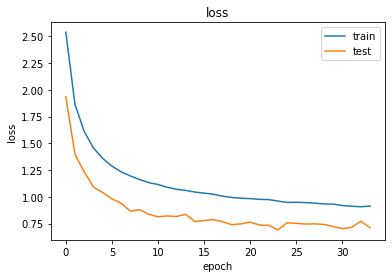

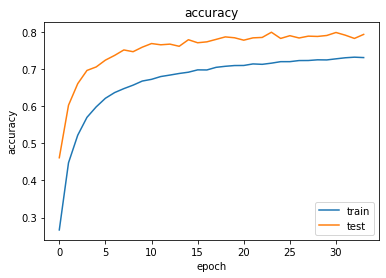

In [137]:
from matplotlib import pyplot
pyplot.title('loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()
pyplot.title('accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.plot(history.history['acc'], label='train') 
pyplot.plot(history.history['val_acc'], label='test') 
pyplot.legend() 
pyplot.show()
#pyplot.title('precision')
#pyplot.ylabel('precision')
#pyplot.xlabel('epoch')
#pyplot.plot(history.history['precision'], label='train') 
#pyplot.plot(history.history['val_precision'], label='test') 
#pyplot.legend() 
#pyplot.show()
#pyplot.title('recall')
#pyplot.ylabel('recall')
#pyplot.xlabel('epoch')
#pyplot.plot(history.history['recall'], label='train') 
#pyplot.plot(history.history['val_recall'], label='test') 
#pyplot.legend() 
#pyplot.show()

In [ ]:
#FUTURE PRECISSION RECALL AND F1
# accuracy: (tp + tn) / (p + n)
#accuracy = accuracy_score(testy, yhat_classes)
#print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
#precision = precision_score(testy, yhat_classes)
#print('Precision: %f' % precision)
# recall: tp / (tp + fn)
#recall = recall_score(testy, yhat_classes)
#print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
#f1 = f1_score(testy, yhat_classes)
#print('F1 score: %f' % f1)

# 7. Model persistence

## 7.1 Save and load model with Modelcheckpoint

In [122]:
from keras.models import load_model
#model=load_model('best_model.hdf5')

## 7.2 Save and load with joblib

Save the model to disk

In [123]:
# save the model to disk
import joblib
filename = 'modeljoblib50history.sav'
joblib.dump(history, filename)
print("Saved model to disk")

Saved model to disk


Load the model from disk

In [124]:
loaded_model = joblib.load(filename)
print("Load model from disk")

Load model from disk


## 7.3 Save and load with keras

In [31]:
# save model and architecture to single file
history.save("modelkeras50history.h5")
print("Saved model to disk")

AttributeError: 'History' object has no attribute 'save'

In [32]:
from keras.models import load_model
model=load_model('./models/modelkeras100.h5')

OSError: Unable to open file (unable to open file: name = './models/modelkeras100.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [125]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 188, 8)            3336      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 188, 8)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 188, 8)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 178, 16)           1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 178, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 178, 16)           0         
__________

# 8. Prediction

In [126]:
#Predict model
predicted = model.predict(all_wave_test_reshape)
#Conver probs from prediction in an array with just one with is most probable
arrayStringPredicted=[]
indexcounter=0
for i in predicted:
    index=np.argmax(i)
    word=classesTest[int(index)]
    arrayStringPredicted.append(word)
    indexcounter=indexcounter+1
#Array with labels
predicted=arrayStringPredicted
print(predicted)

['right', 'happy', 'right', 'right', 'right', 'right', 'three', 'right', 'bird', 'eight', 'right', 'right', 'right', 'right', 'right', 'right', 'left', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'happy', 'right', 'right', 'right', 'right', 'nine', 'right', 'right', 'right', 'right', 'right', 'right', 'nine', 'three', 'right', 'left', 'right', 'right', 'right', 'right', 'left', 'right', 'right', 'right', 'right', 'left', 'nine', 'right', 'right', 'left', 'happy', 'seven', 'one', 'right', 'three', 'right', 'right', 'right', 'right', 'backward', 'right', 'nine', 'house', 'right', 'right', 'nine', 'right', 'happy', 'right', 'five', 'marvin', 'right', 'right', 'right', 'right', 'three', 'three', 'right', 'right', 'right', 'right', 'right', 'right', 'happy', 'five', 'right', 'five', 'right', 'right', 'right', 'right', 'right', 'right', 'nine', 'marvin', 'right', 'right', 'marvin', 'right', 'right', 'left', 'right', 'three', 'three', 'right', 'right', 'ri

In [127]:
yTest=le.fit_transform(all_label_test)
yTest=np_utils.to_categorical(yTest, num_classes=len(classesTest))

In [128]:
print(yTest[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [130]:
arrayStringyTest=[]
indexcounter=0
for i in yTest:
    index=np.argmax(i)
    word=classesTest[int(index)]
    arrayStringyTest.append(word)
    indexcounter=indexcounter+1
#Array with labels
yTest=arrayStringyTest
print(yTest)

['right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 

In [131]:
def predict(audio,secs,sample_rate):
    prob=model.predict(audio.reshape(secs,sample_rate,1))
    index=np.argmax(prob[0])
    return classesTest[index]

In [132]:
import random
index=random.randint(0,len(all_wave_val)-1)
samples=all_wave_test[index].ravel()
print("Audio:",classesTest[np.argmax(yTest[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples,1,8000))

Audio: backward


ValueError: cannot reshape array of size 16000 into shape (1,8000,1)

# 9. Preprocessing Audio from microphone

## 9.1 Record your own voice 

In [3]:
samplerate = 16000  
duration = 4 # seconds
filename = './database_Google/Records/hola.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print
print("end")
print(mydata.shape)
sd.wait()
sf.write(filename, mydata, samplerate)

start
end
(64000, 1)


Plot and display the record

./database_Google/Records/hola.wav
16000


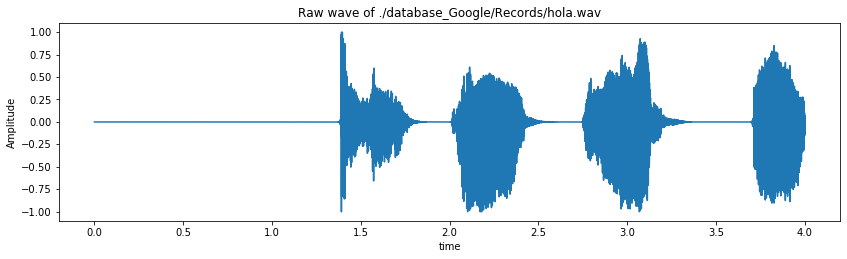

In [4]:
os.listdir(mainPath)
print(dataRecord+'hola.wav')
samples, sample_rate = librosa.load(dataRecord+'hola.wav', sr = samplerate)
print(sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + './database_Google/Records/hola.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(samples)/sample_rate, len(samples)), samples)
ipd.Audio(samples,rate=samplerate) 

## 9.2 Adding noise

In [ ]:
#Adding noise
samples, sample_rate = librosa.load(dataPath+'yes/ffd2ba2f_nohash_4.wav', sr = 16000)
#Use only noise samples from audio file
sample_noise=samples[13000:]
#Concatenate two sample_noise in order to add noise later 
default_noise=np.concatenate([default_noise,default_noise])
print('Noise shape:{}'.format(double_noise.shape))

## 9.3 Discover voice audio detection parts

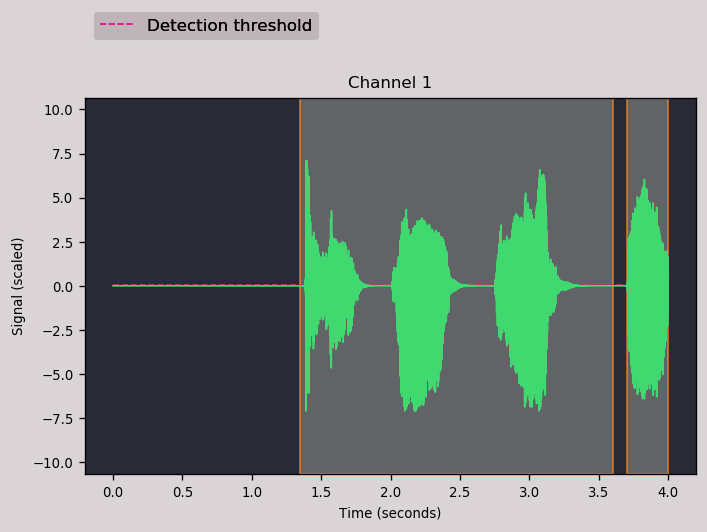

[0. 0. 0. ... 1. 0. 0.]
(36000,)
[  39.   71.   54. ...  155. 1356. 3133.]
(4800,)
AudioRegion(duration=2.250, sampling_rate=16000, sample_width=2, channels=1)


In [5]:
#File
file=dataRecord+'hola.wav'
#Sample rate
sample_rate=8000
#Auditok
region = AudioRegion.load(file)
regions = region.split_and_plot() # or just region.splitp()


## 9.4 Preprocess and predict my record

In [ ]:
def predictMyVoice(audio,sample_rate):
    prob=model.predict(audio)
    index=np.argmax(prob[0])
    return classesTest[index]

In [ ]:
#Number of split words 
no_words=len(regions)
test=[]
#Create an array test for each word
for i in range(no_words):
    test.append(regions[i].samples)
print(len(test[0]))
for i in test:
    if len(i)>sample_rate:
        #Compress the audio length
        #print(len(test[i]))
        size=len(test[i])
        speed_rate=size/sample_rate
        #print(speed_rate)
        test[i] = librosa.effects.time_stretch(test[i], speed_rate)
        #print(test[i] .shape)
        print('Current length of array:{}'.format(len(test[i])))
    if len(i)<sample_rate:
        #Expand audio length
        #print(len(test[i]))
        #size=len(test[i])
        #speed_rate=sample_rate/size
        #print(speed_rate)
        #test[i] = librosa.effects.time_stretch(test[i], speed_rate)
        #print('Current length of array:{}'.format(len(test[i])))
        #print(test[i].shape)
        #Add noise
        size=len(test[i])
        noise_added_length=sample_rate-size
        test[i]=np.concatenate([test[i],default_noise])#default_noise
        print('Current length of array:{}'.format(len(test[i])))

    #print("Audio: hola")
    #ipd.Audio(samples, rate=8000)
    print("Text:",predictMyVoice(test[i],1,sample_rate))

# 10. Analysis of the performance and error

## 10.1 Classification report

In [133]:
from sklearn import datasets, svm, metrics
print("Classification report for classifier %s:\n%s\n" % (model, metrics.classification_report(yTest, predicted)))

Classification report for classifier <keras.engine.training.Model object at 0x00000225E7C86978>:
              precision    recall  f1-score   support

    backward       0.77      0.76      0.76       159
         bed       0.78      0.67      0.72       183
        bird       0.79      0.76      0.77       153
         cat       0.72      0.68      0.70       168
         dog       0.73      0.64      0.68       192
        down       0.67      0.65      0.66       376
       eight       0.81      0.79      0.80       376
        five       0.82      0.71      0.76       408
      follow       0.76      0.65      0.70       165
     forward       0.63      0.54      0.59       147
        four       0.70      0.72      0.71       368
          go       0.65      0.71      0.68       364
       happy       0.67      0.91      0.77       177
       house       0.81      0.88      0.84       167
       learn       0.68      0.40      0.51       149
        left       0.79      0.78     

## 10.2 Confusion matrix

<Figure size 648x648 with 0 Axes>

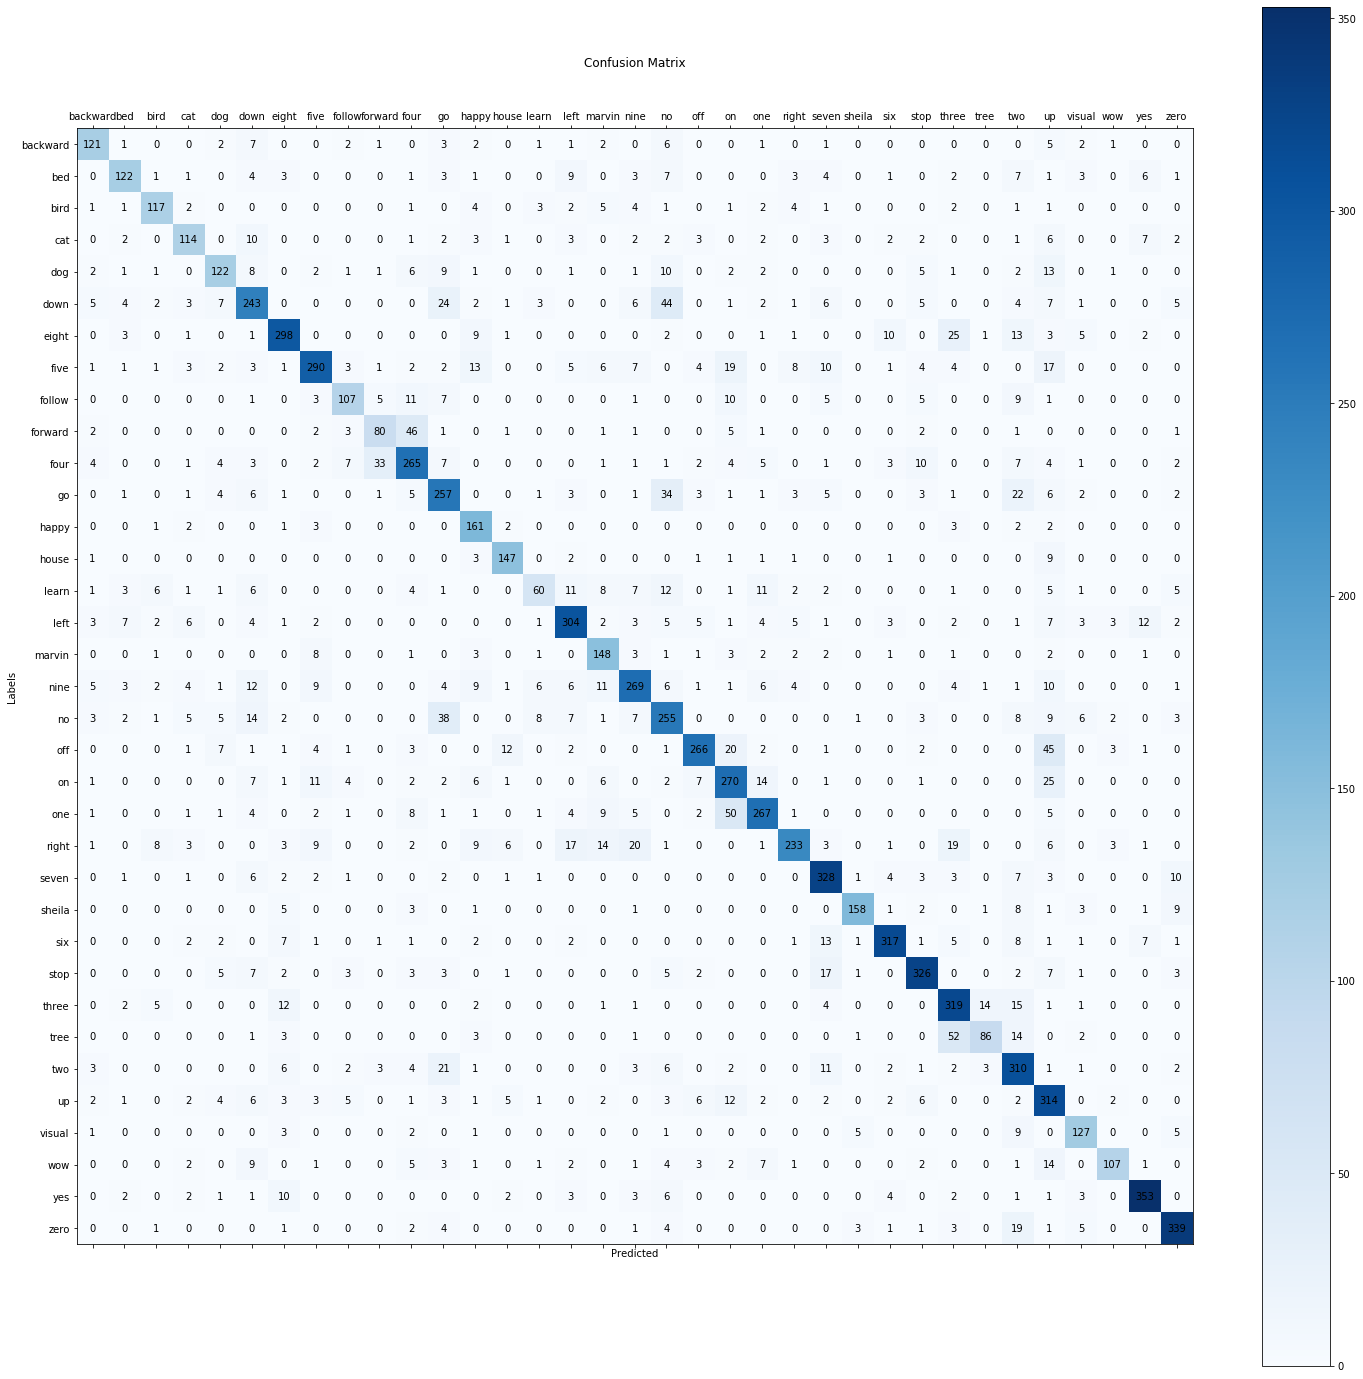

In [134]:
# Es lo mismo pero representa el número de veces que se predice, en vez del porcentaje
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(conf_matrix):
     # Calculate chart area size
    leftmargin = 0.5 # inches
    rightmargin = 0.5 # inches
    categorysize = 0.8 # inches
    sizelabels=10
    figwidth = leftmargin + rightmargin + (sizelabels* categorysize)           
    f = plt.figure(figsize=(figwidth, figwidth))
    labels=['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 
        'five', 'follow', 'forward', 'four', 'go', 'happy', 'house',
        'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one',
        'right', 'seven', 'sheila', 'six', 'stop','three', 'tree', 
        'two', 'up','visual', 'wow', 'yes', 'zero']
    #labels = ['0','1','2','3','4','5','6','7','8','9']
    fig = plt.figure(figsize=(25,25))
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_matrix, cmap=plt.get_cmap('Blues'))
    fig.colorbar(cax)
    ax.set_yticks([i for i in range(0,35)])
    ax.set_xticks([i for i in range(0,35)])
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels)
    for (i, j), z in np.ndenumerate(conf_matrix):
        ax.text(j, i, '{}'.format(z), ha='center', va='center')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Labels')
    plt.show()
    
plot_confusion_matrix(confusion_matrix(yTest, predicted))

## 10.3 Prediction training

In [117]:
from sklearn import metrics
#TRAINING
#Predict model
predictedtrain = model.predict(all_wave_train_reshape)
#Conver probs from prediction in an array with just one with is most probable
arrayStringPredictedtrain=[]
indexcounter=0
for i in predictedtrain:
    index=np.argmax(i)
    word=classesTest[int(index)]
    arrayStringPredictedtrain.append(word)
    indexcounter=indexcounter+1
#Array with labels
predictedtrain=arrayStringPredictedtrain
#print(predictedtrain)
#LABELS
arrayStringyTrain=[]
indexcounter=0
for i in yTrain:
    index=np.argmax(i)
    word=classesTest[int(index)]
    arrayStringyTrain.append(word)
    indexcounter=indexcounter+1
#Array with labels
yTrain=arrayStringyTrain
#print(yTrain)

print("Accuracy in training", metrics.accuracy_score(yTrain, predictedtrain))

Accuracy in training 0.823738934576502


## 10.4 Prediction testing

In [119]:
yTest=le.fit_transform(all_label_test)
yTest=np_utils.to_categorical(yTest, num_classes=len(classesTest))

In [120]:
from sklearn import metrics
#TESTING
#Predict model
predictedtest = model.predict(all_wave_test_reshape)
#Conver probs from prediction in an array with just one with is most probable
arrayStringPredictedtest=[]
indexcounter=0
for i in predictedtest:
    index=np.argmax(i)
    word=classesTest[int(index)]
    arrayStringPredictedtest.append(word)
    indexcounter=indexcounter+1
#Array with labels
predictedtest=arrayStringPredictedtest
#print(predictedtest)
#LABELS
arrayStringyTest=[]
indexcounter=0
for i in yTest:
    index=np.argmax(i)
    word=classesTest[int(index)]
    arrayStringyTest.append(word)
    indexcounter=indexcounter+1
#Array with labels
yTest=arrayStringyTest
#print(yTest)

y_test_pred = model.predict(all_wave_test_reshape)
print("Accuracy in testing", metrics.accuracy_score(yTest, predictedtest))

Accuracy in testing 0.7537439254190221


## 10.5 Learning curve

In [45]:
# POR HACER
# Curva de aprendizaje
# Observamos que no hay overfitting, porque, ya que la diferencia entre la training y la cross-validation curve se
# va haciendo más pequeña cuando hay mas muestras
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,scoring='accuracy',
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

Number of samples from train dataset:76364


TypeError: learning_curve() got an unexpected keyword argument 'return_times'

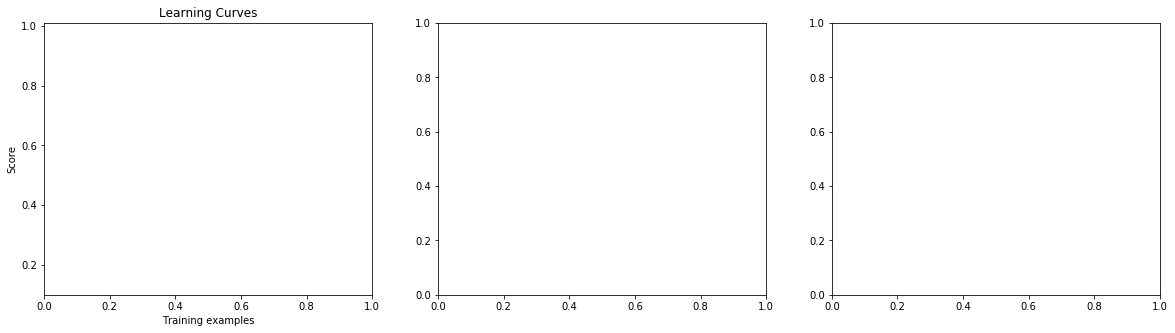

In [47]:
from sklearn.model_selection import learning_curve
print('Number of samples from train dataset:{}'.format(len(all_wave_train)))
title = "Learning Curves"
estimator = model
plot_learning_curve(model, title, predictedtrain, yTrain,ylim=(0.1, 1.01), cv=5, n_jobs=4)
plt.show()

In [135]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Number of samples from train dataset:(76364, 200, 32)


TypeError: Cannot clone object '<keras.engine.training.Model object at 0x00000225E7C86978>' (type <class 'keras.engine.training.Model'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.

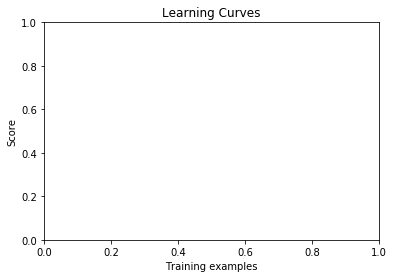

In [136]:
print('Number of samples from train dataset:{}'.format(all_wave_train_reshape.shape))
title = "Learning Curves"


plot_learning_curve(model, title, predictedtrain, yTrain,cv=5)
plt.show()